# Trabajo Practico
## Desarrollo de Modelos Analíticos (Machine Learning) K5051 -2024
### Grupo 3
#### Choque Llanqui, Edson Gustavo
#### Nigliazzo, Matias Ezequiel
#### Sanchez, Tomas Agustin

In [1]:
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)
data = pd.read_csv(r'data/data.csv', sep='|', dtype={'client_id':int},skipfooter = 1, engine='python')

In [2]:
data.shape

(238615, 77)

In [3]:
[x for x in data.columns if x.startswith('Saving')]

['SavingAccount_Active_ARG_Salary',
 'SavingAccount_Active_ARG',
 'SavingAccount_Active_DOLLAR',
 'SavingAccount_Balance_FirstDate',
 'SavingAccount_Balance_LastDate',
 'SavingAccount_Balance_Average',
 'SavingAccount_Days_with_use',
 'SavingAccount_Days_with_Credits',
 'SavingAccount_Days_with_Debits',
 'SavingAccount_Salary_Payment_Transactions',
 'SavingAccount_Transfer_In_Transactions',
 'SavingAccount_ATM_Extraction_Transactions',
 'SavingAccount_Service_Payment_Transactions',
 'SavingAccount_CreditCard_Payment_Transactions',
 'SavingAccount_Transfer_Out_Transactions',
 'SavingAccount_DebitCard_Spend_Transactions',
 'SavingAccount_Transactions_Transactions',
 'SavingAccount_Credits_Transactions',
 'SavingAccount_Debits_Transactions',
 'SavingAccount_Salary_Payment_Amount',
 'SavingAccount_Transfer_In_Amount',
 'SavingAccount_ATM_Extraction_Amount',
 'SavingAccount_Service_Payment_Amount',
 'SavingAccount_CreditCard_Payment_Amount',
 'SavingAccount_Transfer_Out_Amount',
 'SavingAcc

In [4]:
data.Month.value_counts()

Month
2019-04-01    26547
2019-03-01    26547
2019-02-01    26512
2019-01-01    26503
2018-08-01    26502
2018-10-01    26501
2018-09-01    26501
2018-12-01    26501
2018-11-01    26501
Name: count, dtype: int64

In [5]:
len(data.client_id.unique())

26560

In [6]:
#clientes en la base 26560

In [7]:
data_9m = pd.DataFrame(data.client_id.value_counts().reset_index())
data_9m.columns = ['client_id','cantidad_meses']

In [8]:
data_9m

client_id  cantidad_meses
0        5856970               9
1        5895899               9
2        4712252               9
3        7304330               9
4        6657428               9
...          ...             ...
26555    6623284               1
26556    4424661               1
26557    5643352               1
26558    6641590               1
26559     264018               1

[26560 rows x 2 columns]

In [9]:
data_9m[data_9m.cantidad_meses == 9].shape

(26483, 2)

In [10]:
#me quedo con los de 9 meses
data_9m = data_9m[data_9m.cantidad_meses == 9].copy()

In [11]:
#sin paquetes en el ultimo mes

In [12]:
data.Package_Active.value_counts()

Package_Active
No     234177
Yes      4438
Name: count, dtype: int64

In [13]:
#tenemos 9 meses, pero usaremos 2 para la prediccion, 1 para lead window y el resto pata el entrenamiento
data_sin_paquete = data[(data.Package_Active == 'No') & (data.Month == '2019-01-01')][['client_id']]

data_sin_paquete.shape

(26026, 1)

In [14]:
#condicion comercial, sera que el cliente tenga cobranding( que es lo de coto, cencusud, etc)

In [15]:
len(data[(data.CreditCard_CoBranding == 'Yes') & (data.Month == '2019-01-01')].client_id.unique())

2843

In [16]:
#prediction Window

In [17]:
data.Target.value_counts()

Target
0.0    176359
1.0     62256
Name: count, dtype: int64

In [18]:
data_Target = data[(data.Target == 1) & (data.Month.isin(['2019-04-01','2019-03-01']))][['client_id']].drop_duplicates()
data_Target.shape

data_Target['TGT'] = 1

In [19]:
data_cobranding = data[(data.CreditCard_CoBranding == 'Yes') & (data.Month == '2019-01-01')][['client_id']]
data_cobranding.shape

(2843, 1)

In [20]:
data_cruce_cobranding = data_cobranding.merge(data_Target, how='left', on='client_id').fillna(0)

data_cruce_cobranding.TGT.value_counts()

TGT
0.0    2836
1.0       7
Name: count, dtype: int64

In [21]:
# como vemos, los que tienen cobranding y con target 1, son solo 7. Esos no los voy a usar, son muy pocos, ademas
# hay una constraint de negocio de los bancos, que dice que a los que tienen cobranding, no les doy paquetes
#porque no tienen  mucha plata

In [22]:
## asi que lo que necesitaria es para cumplir el objetivo de "Vender paquetes" es:
# Cruzar todo y quedarse con los clientes aptos:
# 9 mese de data (no le vendo a los clientes nuevos)
# sin cobranding (porque si tiene cobranding se que no les voy a vender a ellos)
# sin paquete activo (no le voy a vender un producto que ya tiene)

In [23]:
data_cobranding_No = data[(data.CreditCard_CoBranding == 'No') & (data.Month == '2019-01-01')][['client_id']]

In [24]:
universo = data_9m.merge(data_sin_paquete, how='inner', on='client_id')\
                .merge(data_cobranding_No, how='inner', on='client_id')\
                .merge(data_Target, how='left', on='client_id').fillna(0)

universo.TGT.value_counts()
            

TGT
0.0    16368
1.0     6823
Name: count, dtype: int64

In [25]:
#en nuestro universo el 30% de las personas compran paquetes

## Exploratory Data Analysis

In [26]:
training_window = data[(data.Month.isin(['2018-08-01','2018-09-01','2018-10-01','2018-11-01','2018-12-01','2019-01-01']))]
training_window.shape

(159009, 77)

In [27]:
training_window

client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
238597    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
238603    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
238604    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
238608    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
238612    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                      No               Yes                    No          No   
1                      No                No                    No          No   
2                      No                No                    No          No   
3                      No               Yes                    No          No   
4                      No                No                    No          No   
...                   ...               ...                   ...         ...   
238597                 No               Yes                    No          No   
238603                 No               Yes                    No          No   
238604                 No               Yes                    No          No   
238608                 No                No                    No          No   
238612                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_External  \
0                   No  ...                         0.0   
1                   No  ...                         0.0   
2                   No  ...                         0.0   
3                   No  ...                         0.0   
4                   No  ...                         0.0   
...                ...  ...                         ...   
238597              No  ...                         0.0   
238603              No  ...                         0.0   
238604              No  ...                         0.0   
238608              No  ...                         0.0   
238612              No  ...                         0.0   

       CreditCard_Payment_Cash CreditCard_Payment_Web CreditCard_Payment_ATM  \
0                          0.0                    0.0                    0.0   
1                          0.0                    0.0                    0.0   
2                          0.0                    0.0                    0.0   
3                          0.0                    0.0                    0.0   
4                          0.0                    0.0                    0.0   
...                        ...                    ...                    ...   
238597                     0.0                    1.0                    0.0   
238603                     0.0                    1.0                    0.0   
238604                     0.0                    0.0                    0.0   
238608                     0.0                    0.0                    0.0   
238612                     0.0                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email Region  \
0                         0.0                1.0    Yes   Yes    NaN   
1                         0.0                0.0    Yes    No    NaN   
2                         0.0                0.0    Yes   Yes    NaN   
3                         0.0                0.0    Yes   Yes    NaN   
4                         0.0                0.0    Yes    No    NaN   
...                       ...               

In [28]:
training_window.client_id.value_counts()

client_id
5856970    6
3852147    6
1129478    6
711456     6
2531821    6
          ..
6264756    2
5124642    1
6623284    1
1419642    1
6858355    1
Name: count, Length: 26509, dtype: int64

In [29]:
#para quitar esos clientes que no tienen 6 registros,
#cruzare mi training_window(estos serian 6 meses) con el universo de trabajo(estos son nueve meses)

In [30]:
training_window = training_window.merge(universo, how='inner', on='client_id')

In [31]:
training_window.client_id.value_counts()

client_id
5856970    6
2428341    6
6454439    6
5678167    6
7308381    6
          ..
6210931    6
2758381    6
6348905    6
5982253    6
5967858    6
Name: count, Length: 23191, dtype: int64

## Identity features del ultimo mes de training window

In [32]:
#crear data frame con IF

In [33]:
dfIdentityFeatures = training_window[training_window.Month == '2019-01-01'][['client_id','Target','Investment_Numbers','CreditCard_Total_Limit']]
dfIdentityFeatures

client_id  Target  Investment_Numbers  CreditCard_Total_Limit
2         5928737     0.0                 0.0                     0.0
8         6018047     1.0                 0.0                 80000.0
9         5359038     1.0                 0.0                 64000.0
11        6890812     0.0                 0.0                     0.0
13         115383     0.0                 0.0                     0.0
...           ...     ...                 ...                     ...
139131    6570413     0.0                 0.0                 28000.0
139132    6258895     0.0                 0.0                     0.0
139138    6397274     0.0                 0.0                 40000.0
139139    6007291     0.0                 0.0                 96000.0
139145    6412619     0.0                 0.0                     0.0

[23191 rows x 4 columns]

## Transform Features del ultimo mes de training window

In [34]:
dfTransformFeatures = training_window[training_window.Month == '2019-01-01'][['client_id']]

columnas = ['CreditCard_Premium','CreditCard_Active','CreditCard_CoBranding','Loan_Active',
            'Mortgage_Active', 'SavingAccount_Active_ARG_Salary','SavingAccount_Active_ARG','SavingAccount_Active_DOLLAR'
           ,'DebitCard_Active','Investment_Active','Package_Active','Insurance_Life'
           ,'Insurance_Home','Insurance_Accidents','Insurance_Mobile','Insurance_ATM','Insurance_Unemployment']

for columna in columnas:
    dfTransformFeatures[columna] = np.where(training_window[training_window.Month == '2019-01-01'][columna] == 'Yes',1,0)
#----------    

dfTransformFeatures['Sex'] = np.where(training_window[training_window.Month == '2019-01-01']['Sex'] == 'F', 0, 1)

#--------
TiposSegurosColumnas = [x for x in training_window.columns if x.startswith('Insurance')]

dfInsurance = training_window[training_window.Month == '2019-01-01'][['client_id']]
for columna in TiposSegurosColumnas:
    dfInsurance[columna] = np.where(training_window[training_window.Month == '2019-01-01'][columna] == 'Yes',1,0)

dfTransformFeatures['Total_Seguros_del_UltimosMes'] = dfInsurance[TiposSegurosColumnas[0]] + dfInsurance[TiposSegurosColumnas[1]] + dfInsurance[TiposSegurosColumnas[2]] +dfInsurance[TiposSegurosColumnas[3]] +dfInsurance[TiposSegurosColumnas[4]]+dfInsurance[TiposSegurosColumnas[5]]


#---------------
dfTransformFeatures['Client_Age_grp'] = training_window[training_window.Month == '2019-01-01'][['Client_Age_grp']]

di = { 
 "Entre 40 y 49 años"          : 40,
 "Entre 30 y 39 años"                 : 30,
    "Entre 50 y 59 años"                 : 50,
    "Entre 60 y 64 años"                 : 60,
    "Entre 65 y 69 años"                 : 65,
    "Entre 18 y 29 años"                 : 18,
    "Mayor a 70 años"                 : 70,
    "Menor a 18 años"                 : 17,
 }
dfTransformFeatures.Client_Age_grp = dfTransformFeatures.Client_Age_grp.map(di)

#-----------------

#dfTransformFeatures['MaxSavingAccount_ATM_Extraction_Last6'] = tr

# total cantidad de seguros del ultimo mes,  grupos de edades ponerlos en numeros, maxima extraccion de atm de los ultmos 6 meses
dfTransformFeatures


client_id  CreditCard_Premium  CreditCard_Active  \
2         5928737                   0                  0   
8         6018047                   1                  1   
9         5359038                   1                  1   
11        6890812                   0                  0   
13         115383                   0                  0   
...           ...                 ...                ...   
139131    6570413                   0                  1   
139132    6258895                   0                  0   
139138    6397274                   0                  1   
139139    6007291                   1                  1   
139145    6412619                   0                  0   

        CreditCard_CoBranding  Loan_Active  Mortgage_Active  \
2                           0            0                0   
8                           0            0                0   
9                           0            1                0   
11                          0            1                0   
13                          0            0                0   
...                       ...          ...              ...   
139131                      0            0                0   
139132                      0            0                0   
139138                      0            0                0   
139139                      0            0                0   
139145                      0            1                0   

        SavingAccount_Active_ARG_Salary  SavingAccount_Active_ARG  \
2                                     0                         1   
8                                     0                         1   
9                                     1                         1   
11                                    0                         1   
13                                    0                         1   
...                                 ...                       ...   
139131                                0                         1   
139132                                0                         1   
139138                                0                         0   
139139                                0                         0   
139145                                0                         1   

        SavingAccount_Active_DOLLAR  DebitCard_Active  ...  Package_Active  \
2                                 1                 1  ...               0   
8                                 0                 1  ...               0   
9                                 1                 1  ...               0   
11                                1                 1  ...               0   
13                                0                 0  ...               0   
...                             ...               ...  ...             ...   
139131                            1                 1  ...               0   
139132                            1                 1  ...               0   
139138                            0                 0  ...               0   
139139                            0                 0  ...               0   
139145                            0                 1  ...               0   

        Insurance_Life  Insurance_Home  Insurance_Accidents  Insurance_Mobile  \
2                    0               0                    0                 0   
8                    0               0                    0                 0   
9                    0               0                    0                 0   
11                   0               0                    0                 0   
13                   0               0                    0                 0   
...                ...             ...                  ...               ...   
139131               0               0                    0                 0   
139132               0               0                    0                 0   
139138               0             

## Missing values

In [35]:
training_window.columns[training_window.isnull().any()].tolist()

['SavingAccount_Balance_Average', 'Region', 'CreditCard_Product']

## Tratamiento missing: SavingAccount_Balance_Average

In [36]:
training_window[training_window.SavingAccount_Balance_Average.fillna(-999) == -999]

client_id  Target       Month First_product_dt Last_product_dt  \
50026     4473325     0.0  2018-12-01       2008-05-27      2017-05-18   
50027     4837071     1.0  2018-12-01       2013-02-21      2018-09-04   
50029     4525957     1.0  2019-01-01       2012-10-16      2016-08-31   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
50026                 Yes               Yes                    No          No   
50027                  No                No                    No          No   
50029                 Yes               Yes                    No          No   
139145                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_Web CreditCard_Payment_ATM  \
50026               No  ...                    0.0                    0.0   
50027               No  ...                    0.0                    0.0   
50029               No  ...                    1.0                    0.0   
139145              No  ...                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email Region  \
50026                     0.0                0.0    Yes   Yes    NaN   
50027                     0.0                0.0    Yes   Yes    NaN   
50029                     0.0                0.0    Yes   Yes    NaN   
139145                    0.0                0.0    Yes    No    NaN   

       CreditCard_Product cantidad_meses  TGT  
50026                 NaN              9  0.0  
50027                 NaN              9  1.0  
50029                 NaN              9  1.0  
139145                NaN              9  0.0  

[4 rows x 79 columns]

In [37]:
training_window[training_window.client_id == '6412619']['SavingAccount_Balance_Average']

Series([], Name: SavingAccount_Balance_Average, dtype: float64)

In [38]:
training_window['SavingAccount_Balance_Average'] = np.where(training_window.SavingAccount_Balance_Average.isnull(),
    training_window.SavingAccount_Balance_FirstDate - training_window.SavingAccount_Debits_Amounts + training_window.SavingAccount_Credits_Amounts,
    training_window.SavingAccount_Balance_Average)

In [39]:
training_window[training_window.client_id == '6412619']['SavingAccount_Balance_Average']

Series([], Name: SavingAccount_Balance_Average, dtype: float64)

## Tratamiento missing: Region

In [40]:
training_window[training_window.Region.fillna('Empty') == 'Empty']

client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                      No               Yes                    No          No   
1                      No                No                    No          No   
2                      No                No                    No          No   
3                      No               Yes                    No          No   
4                      No                No                    No          No   
...                   ...               ...                   ...         ...   
139141                 No               Yes                    No          No   
139142                 No               Yes                    No          No   
139143                 No               Yes                    No          No   
139144                 No                No                    No          No   
139145                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_Web CreditCard_Payment_ATM  \
0                   No  ...                    0.0                    0.0   
1                   No  ...                    0.0                    0.0   
2                   No  ...                    0.0                    0.0   
3                   No  ...                    0.0                    0.0   
4                   No  ...                    0.0                    0.0   
...                ...  ...                    ...                    ...   
139141              No  ...                    1.0                    0.0   
139142              No  ...                    1.0                    0.0   
139143              No  ...                    0.0                    0.0   
139144              No  ...                    0.0                    0.0   
139145              No  ...                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email Region  \
0                         0.0                1.0    Yes   Yes    NaN   
1                         0.0                0.0    Yes    No    NaN   
2                         0.0                0.0    Yes   Yes    NaN   
3                         0.0                0.0    Yes   Yes    NaN   
4                         0.0                0.0    Yes    No    NaN   
...                       ...                ...    ...   ...    ...   
139141                    0.0                0.0     No   Yes    NaN   
139142                    0.0                0.0    Yes   Yes    NaN   
139143                    1.0                0.0    Yes    No    NaN   
139144                    0.0                0.0    Yes   Yes    NaN   
139145                    0.0                0.0    Yes    No    NaN   

       CreditCard_Product cantidad_meses  TGT  
0                     NaN              9  1.0  
1                     NaN              9  0.0  
2                     NaN              9  0.0  
3                     NaN              9  0.0  
4                     NaN              9  0.0  
...                   ...            ...  ...  
139141              

In [41]:
data[data.Month == '2019-04-01']

client_id  Target       Month First_product_dt Last_product_dt  \
9         5775560     0.0  2019-04-01       2013-08-22      2014-08-01   
13        5800470     0.0  2019-04-01       2013-08-23      2018-03-26   
17        3540244     0.0  2019-04-01       2018-09-07      2018-09-07   
43        6912865     0.0  2019-04-01       2017-08-17      2019-01-04   
47        6595044     0.0  2019-04-01       2016-01-14      2017-09-26   
...           ...     ...         ...              ...             ...   
238564    5678167     1.0  2019-04-01       2013-02-26      2018-11-28   
238589    6948039     1.0  2019-04-01       2017-08-14      2019-01-10   
238590    1818546     1.0  2019-04-01       2013-12-10      2018-02-07   
238611    6377583     0.0  2019-04-01       2015-06-03      2019-01-04   
238613    5542402     0.0  2019-04-01       2012-09-13      2012-09-13   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
9                      No               Yes                    No          No   
13                     No               Yes                   Yes          No   
17                     No                No                    No          No   
43                     No                No                    No          No   
47                     No               Yes                    No          No   
...                   ...               ...                   ...         ...   
238564                 No               Yes                    No          No   
238589                 No               Yes                    No          No   
238590                 No               Yes                    No          No   
238611                 No               Yes                    No         Yes   
238613                 No               Yes                    No          No   

       Mortgage_Active  ... CreditCard_Payment_External  \
9                   No  ...                         0.0   
13                  No  ...                         0.0   
17                  No  ...                         0.0   
43                  No  ...                         0.0   
47                  No  ...                         0.0   
...                ...  ...                         ...   
238564              No  ...                         0.0   
238589              No  ...                         0.0   
238590              No  ...                         0.0   
238611              No  ...                         0.0   
238613              No  ...                         0.0   

       CreditCard_Payment_Cash CreditCard_Payment_Web CreditCard_Payment_ATM  \
9                          0.0                    0.0                    0.0   
13                         0.0                    0.0                    0.0   
17                         0.0                    0.0                    0.0   
43                         0.0                    0.0                    0.0   
47                         0.0                    0.0                    0.0   
...                        ...                    ...                    ...   
238564                     0.0                    0.0                    0.0   
238589                     0.0                    0.0                    0.0   
238590                     1.0                    0.0                    0.0   
238611                     0.0                    0.0                    0.0   
238613                     0.0                    0.0                    1.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email  \
9                         0.0                0.0    Yes   Yes   
13                        0.0                0.0    Yes   Yes   
17                        0.0                0.0     No    No   
43                        1.0                0.0    Yes   Yes   
47                        0.0                0.0    Yes    No   
...                       ...                ...    ...   ...   
238564               

In [42]:
training_window.Region.value_counts()

Series([], Name: count, dtype: int64)

In [43]:
training_window['Region'].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: Region, dtype: object

In [44]:
training_win_buffer = training_window.copy()

data_last_Moth = data[data.Month == '2019-04-01'][['client_id','Region']].copy()
data_last_Moth.rename(columns={'Region':'RegionUpdated'}, inplace=True)

training_win_buffer = training_win_buffer.merge(data_last_Moth, how='left', on='client_id')

training_window['Region'] = training_win_buffer['RegionUpdated']

training_window


client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                      No               Yes                    No          No   
1                      No                No                    No          No   
2                      No                No                    No          No   
3                      No               Yes                    No          No   
4                      No                No                    No          No   
...                   ...               ...                   ...         ...   
139141                 No               Yes                    No          No   
139142                 No               Yes                    No          No   
139143                 No               Yes                    No          No   
139144                 No                No                    No          No   
139145                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_Web CreditCard_Payment_ATM  \
0                   No  ...                    0.0                    0.0   
1                   No  ...                    0.0                    0.0   
2                   No  ...                    0.0                    0.0   
3                   No  ...                    0.0                    0.0   
4                   No  ...                    0.0                    0.0   
...                ...  ...                    ...                    ...   
139141              No  ...                    1.0                    0.0   
139142              No  ...                    1.0                    0.0   
139143              No  ...                    0.0                    0.0   
139144              No  ...                    0.0                    0.0   
139145              No  ...                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email  \
0                         0.0                1.0    Yes   Yes   
1                         0.0                0.0    Yes    No   
2                         0.0                0.0    Yes   Yes   
3                         0.0                0.0    Yes   Yes   
4                         0.0                0.0    Yes    No   
...                       ...                ...    ...   ...   
139141                    0.0                0.0     No   Yes   
139142                    0.0                0.0    Yes   Yes   
139143                    1.0                0.0    Yes    No   
139144                    0.0                0.0    Yes   Yes   
139145                    0.0                0.0    Yes    No   

                               Region CreditCard_Product cantidad_meses  TGT  
0                          AMBA Resto                NaN              9  1.0  
1                       REGION CENTRO                NaN              9  0.0  
2       REGION NORTE GRANDE ARGENTINO                NaN              9  0.0  
3                         REGION CUYO                NaN              9  0.0  
4                       REGION CENTRO        

In [45]:
training_window['Region'].describe()

count           139110
unique               7
top       BUENOS AIRES
freq             41904
Name: Region, dtype: object

In [46]:
training_window.Region.value_counts()

Region
BUENOS AIRES                     41904
REGION CENTRO                    27474
REGION NORTE GRANDE ARGENTINO    22044
REGION PATAGONICA                14592
CABA Centro/Norte                12288
AMBA Resto                       10968
REGION CUYO                       9840
Name: count, dtype: int64

### Missing values Region que no se pudieron completar

In [47]:
training_window[training_window.Region.fillna('Empty') == 'Empty']

client_id  Target       Month First_product_dt Last_product_dt  \
5618      2181839     0.0  2018-08-01       2006-10-05      2006-10-05   
12257      921872     0.0  2018-09-01       2005-11-24      2005-11-24   
18700     2181839     0.0  2019-01-01       2006-10-05      2006-10-05   
20460      436555     0.0  2018-11-01       2005-02-09      2005-02-09   
25548      727081     0.0  2018-08-01       2005-07-18      2005-07-18   
37210      535416     0.0  2018-09-01       2005-04-13      2005-04-13   
37430      833913     0.0  2018-08-01       2005-08-31      2014-01-24   
44841      436555     0.0  2018-08-01       2005-02-09      2005-02-09   
53787     2181839     0.0  2018-09-01       2006-10-05      2006-10-05   
55285      921872     0.0  2018-11-01       2005-11-24      2005-11-24   
57045      436555     0.0  2018-10-01       2005-02-09      2005-02-09   
62988      921872     0.0  2018-12-01       2005-11-24      2005-11-24   
67184      833913     0.0  2019-01-01       2005-08-31      2014-01-24   
77610      727081     0.0  2018-09-01       2005-07-18      2005-07-18   
82529     2181839     0.0  2018-10-01       2006-10-05      2006-10-05   
85105      436555     0.0  2018-09-01       2005-02-09      2005-02-09   
87881      535416     0.0  2018-10-01       2005-04-13      2005-04-13   
89371     2181839     0.0  2018-12-01       2006-10-05      2006-10-05   
93734      833913     0.0  2018-11-01       2005-08-31      2014-01-24   
93761      833913     0.0  2018-10-01       2005-08-31      2014-01-24   
94231     2181839     0.0  2018-11-01       2006-10-05      2006-10-05   
97122      727081     0.0  2018-11-01       2005-07-18      2005-07-18   
99710      535416     0.0  2018-12-01       2005-04-13      2005-04-13   
101314     535416     0.0  2019-01-01       2005-04-13      2005-04-13   
101414     727081     0.0  2019-01-01       2005-07-18      2005-07-18   
103617     727081     0.0  2018-10-01       2005-07-18      2005-07-18   
105080     535416     0.0  2018-11-01       2005-04-13      2005-04-13   
108222     833913     0.0  2018-09-01       2005-08-31      2014-01-24   
109178     833913     0.0  2018-12-01       2005-08-31      2014-01-24   
118693     921872     0.0  2018-10-01       2005-11-24      2005-11-24   
120440     727081     0.0  2018-12-01       2005-07-18      2005-07-18   
122807     436555     0.0  2018-12-01       2005-02-09      2005-02-09   
130135     921872     0.0  2018-08-01       2005-11-24      2005-11-24   
132195     921872     0.0  2019-01-01       2005-11-24      2005-11-24   
135035     436555     0.0  2019-01-01       2005-02-09      2005-02-09   
139104     535416     0.0  2018-08-01       2005-04-13      2005-04-13   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
5618                   No                No                    No          No   
12257                  No                No                    No          No   
18700                  No                No                    No          No   
20460                  No                No                    No          No   
25548                  No                No                    No          No   
37210                  No                No                    No          No   
37430                  No                No                    No          No   
44841                  No                No                    No          No   
53787                  No                No                    No          No   
55285                  No                No                    No          No   
57045                  No                No                    No          No   
62988                  No                No                    No          No   
67184                  No                No                    No          No   
77610                  No                No                    No          No   
82529                  No                No           

In [48]:
data[(data.Month == '2019-04-01') & (data.client_id == '833913')]

Empty DataFrame
Columns: [client_id, Target, Month, First_product_dt, Last_product_dt, CreditCard_Premium, CreditCard_Active, CreditCard_CoBranding, Loan_Active, Mortgage_Active, SavingAccount_Active_ARG_Salary, SavingAccount_Active_ARG, SavingAccount_Active_DOLLAR, DebitCard_Active, Investment_Active, Package_Active, Insurance_Life, Insurance_Home, Insurance_Accidents, Insurance_Mobile, Insurance_ATM, Insurance_Unemployment, Sex, Client_Age_grp, SavingAccount_Balance_FirstDate, SavingAccount_Balance_LastDate, SavingAccount_Balance_Average, SavingAccount_Days_with_use, SavingAccount_Days_with_Credits, SavingAccount_Days_with_Debits, SavingAccount_Salary_Payment_Transactions, SavingAccount_Transfer_In_Transactions, SavingAccount_ATM_Extraction_Transactions, SavingAccount_Service_Payment_Transactions, SavingAccount_CreditCard_Payment_Transactions, SavingAccount_Transfer_Out_Transactions, SavingAccount_DebitCard_Spend_Transactions, SavingAccount_Transactions_Transactions, SavingAccount_Credits_Transactions, SavingAccount_Debits_Transactions, SavingAccount_Salary_Payment_Amount, SavingAccount_Transfer_In_Amount, SavingAccount_ATM_Extraction_Amount, SavingAccount_Service_Payment_Amount, SavingAccount_CreditCard_Payment_Amount, SavingAccount_Transfer_Out_Amount, SavingAccount_DebitCard_Spend_Amount, SavingAccount_Total_Amount, SavingAccount_Credits_Amounts, SavingAccount_Debits_Amounts, Operations_Bank, Operations_Terminal, Operations_HomeBanking, Operations_Mobile, Operations_Ivr, Operations_Telemarketer, Operations_ATM, CreditCard_Balance_ARG, CreditCard_Balance_DOLLAR, CreditCard_Total_Limit, CreditCard_Total_Spending, CreditCard_Spending_1_Installment, CreditCard_Spending_Installments, CreditCard_Spending_CrossBoarder, CreditCard_Spending_Aut_Debits, CreditCard_Revolving, CreditCard_Payment_Aut_Debit, CreditCard_Payment_External, CreditCard_Payment_Cash, CreditCard_Payment_Web, CreditCard_Payment_ATM, CreditCard_Payment_TAS, Investment_Numbers, Mobile, Email, Region, CreditCard_Product]
Index: []

[0 rows x 77 columns]

In [49]:
data[data.client_id == '833913']

Empty DataFrame
Columns: [client_id, Target, Month, First_product_dt, Last_product_dt, CreditCard_Premium, CreditCard_Active, CreditCard_CoBranding, Loan_Active, Mortgage_Active, SavingAccount_Active_ARG_Salary, SavingAccount_Active_ARG, SavingAccount_Active_DOLLAR, DebitCard_Active, Investment_Active, Package_Active, Insurance_Life, Insurance_Home, Insurance_Accidents, Insurance_Mobile, Insurance_ATM, Insurance_Unemployment, Sex, Client_Age_grp, SavingAccount_Balance_FirstDate, SavingAccount_Balance_LastDate, SavingAccount_Balance_Average, SavingAccount_Days_with_use, SavingAccount_Days_with_Credits, SavingAccount_Days_with_Debits, SavingAccount_Salary_Payment_Transactions, SavingAccount_Transfer_In_Transactions, SavingAccount_ATM_Extraction_Transactions, SavingAccount_Service_Payment_Transactions, SavingAccount_CreditCard_Payment_Transactions, SavingAccount_Transfer_Out_Transactions, SavingAccount_DebitCard_Spend_Transactions, SavingAccount_Transactions_Transactions, SavingAccount_Credits_Transactions, SavingAccount_Debits_Transactions, SavingAccount_Salary_Payment_Amount, SavingAccount_Transfer_In_Amount, SavingAccount_ATM_Extraction_Amount, SavingAccount_Service_Payment_Amount, SavingAccount_CreditCard_Payment_Amount, SavingAccount_Transfer_Out_Amount, SavingAccount_DebitCard_Spend_Amount, SavingAccount_Total_Amount, SavingAccount_Credits_Amounts, SavingAccount_Debits_Amounts, Operations_Bank, Operations_Terminal, Operations_HomeBanking, Operations_Mobile, Operations_Ivr, Operations_Telemarketer, Operations_ATM, CreditCard_Balance_ARG, CreditCard_Balance_DOLLAR, CreditCard_Total_Limit, CreditCard_Total_Spending, CreditCard_Spending_1_Installment, CreditCard_Spending_Installments, CreditCard_Spending_CrossBoarder, CreditCard_Spending_Aut_Debits, CreditCard_Revolving, CreditCard_Payment_Aut_Debit, CreditCard_Payment_External, CreditCard_Payment_Cash, CreditCard_Payment_Web, CreditCard_Payment_ATM, CreditCard_Payment_TAS, Investment_Numbers, Mobile, Email, Region, CreditCard_Product]
Index: []

[0 rows x 77 columns]

In [50]:
training_window['Region'] = np.where(training_window['Region'].isna(), 
                                                          'BUENOS AIRES',
                                                         training_window['Region'])

In [51]:
training_window[training_window.Region.fillna('Empty') == 'Empty']

Empty DataFrame
Columns: [client_id, Target, Month, First_product_dt, Last_product_dt, CreditCard_Premium, CreditCard_Active, CreditCard_CoBranding, Loan_Active, Mortgage_Active, SavingAccount_Active_ARG_Salary, SavingAccount_Active_ARG, SavingAccount_Active_DOLLAR, DebitCard_Active, Investment_Active, Package_Active, Insurance_Life, Insurance_Home, Insurance_Accidents, Insurance_Mobile, Insurance_ATM, Insurance_Unemployment, Sex, Client_Age_grp, SavingAccount_Balance_FirstDate, SavingAccount_Balance_LastDate, SavingAccount_Balance_Average, SavingAccount_Days_with_use, SavingAccount_Days_with_Credits, SavingAccount_Days_with_Debits, SavingAccount_Salary_Payment_Transactions, SavingAccount_Transfer_In_Transactions, SavingAccount_ATM_Extraction_Transactions, SavingAccount_Service_Payment_Transactions, SavingAccount_CreditCard_Payment_Transactions, SavingAccount_Transfer_Out_Transactions, SavingAccount_DebitCard_Spend_Transactions, SavingAccount_Transactions_Transactions, SavingAccount_Credits_Transactions, SavingAccount_Debits_Transactions, SavingAccount_Salary_Payment_Amount, SavingAccount_Transfer_In_Amount, SavingAccount_ATM_Extraction_Amount, SavingAccount_Service_Payment_Amount, SavingAccount_CreditCard_Payment_Amount, SavingAccount_Transfer_Out_Amount, SavingAccount_DebitCard_Spend_Amount, SavingAccount_Total_Amount, SavingAccount_Credits_Amounts, SavingAccount_Debits_Amounts, Operations_Bank, Operations_Terminal, Operations_HomeBanking, Operations_Mobile, Operations_Ivr, Operations_Telemarketer, Operations_ATM, CreditCard_Balance_ARG, CreditCard_Balance_DOLLAR, CreditCard_Total_Limit, CreditCard_Total_Spending, CreditCard_Spending_1_Installment, CreditCard_Spending_Installments, CreditCard_Spending_CrossBoarder, CreditCard_Spending_Aut_Debits, CreditCard_Revolving, CreditCard_Payment_Aut_Debit, CreditCard_Payment_External, CreditCard_Payment_Cash, CreditCard_Payment_Web, CreditCard_Payment_ATM, CreditCard_Payment_TAS, Investment_Numbers, Mobile, Email, Region, CreditCard_Product, cantidad_meses, TGT]
Index: []

[0 rows x 79 columns]

In [52]:
training_window.Region.value_counts()

Region
BUENOS AIRES                     41940
REGION CENTRO                    27474
REGION NORTE GRANDE ARGENTINO    22044
REGION PATAGONICA                14592
CABA Centro/Norte                12288
AMBA Resto                       10968
REGION CUYO                       9840
Name: count, dtype: int64

## Tratamiento missing: CreditCard_Product

In [53]:
training_window.CreditCard_Product.value_counts()

Series([], Name: count, dtype: int64)

In [54]:
training_window[training_window.CreditCard_Product.fillna('Empty') == 'Empty']

client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                      No               Yes                    No          No   
1                      No                No                    No          No   
2                      No                No                    No          No   
3                      No               Yes                    No          No   
4                      No                No                    No          No   
...                   ...               ...                   ...         ...   
139141                 No               Yes                    No          No   
139142                 No               Yes                    No          No   
139143                 No               Yes                    No          No   
139144                 No                No                    No          No   
139145                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_Web CreditCard_Payment_ATM  \
0                   No  ...                    0.0                    0.0   
1                   No  ...                    0.0                    0.0   
2                   No  ...                    0.0                    0.0   
3                   No  ...                    0.0                    0.0   
4                   No  ...                    0.0                    0.0   
...                ...  ...                    ...                    ...   
139141              No  ...                    1.0                    0.0   
139142              No  ...                    1.0                    0.0   
139143              No  ...                    0.0                    0.0   
139144              No  ...                    0.0                    0.0   
139145              No  ...                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email  \
0                         0.0                1.0    Yes   Yes   
1                         0.0                0.0    Yes    No   
2                         0.0                0.0    Yes   Yes   
3                         0.0                0.0    Yes   Yes   
4                         0.0                0.0    Yes    No   
...                       ...                ...    ...   ...   
139141                    0.0                0.0     No   Yes   
139142                    0.0                0.0    Yes   Yes   
139143                    1.0                0.0    Yes    No   
139144                    0.0                0.0    Yes   Yes   
139145                    0.0                0.0    Yes    No   

                               Region CreditCard_Product cantidad_meses  TGT  
0                          AMBA Resto                NaN              9  1.0  
1                       REGION CENTRO                NaN              9  0.0  
2       REGION NORTE GRANDE ARGENTINO                NaN              9  0.0  
3                         REGION CUYO                NaN              9  0.0  
4                       REGION CENTRO        

In [55]:
training_window['CreditCard_Product'].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: CreditCard_Product, dtype: object

In [56]:
CreditActive_clients = training_window[(training_window.CreditCard_Active == 'Yes') & (training_window.Month == '2019-01-01')]['client_id']

CreditCardProduct_buffer = data[(data.Month == '2019-04-01') & (data.client_id.isin(CreditActive_clients))][['client_id','CreditCard_Product']].copy()

CreditCardProduct_buffer.rename(columns={'CreditCard_Product':'CreditCard_ProductUpdated'}, inplace=True)

training_win_buffer2 = training_window.copy()

training_win_buffer2 = training_win_buffer2.merge(CreditCardProduct_buffer, how='left', on='client_id')

training_window['CreditCard_Product'] = training_win_buffer2['CreditCard_ProductUpdated']

training_window


client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                      No               Yes                    No          No   
1                      No                No                    No          No   
2                      No                No                    No          No   
3                      No               Yes                    No          No   
4                      No                No                    No          No   
...                   ...               ...                   ...         ...   
139141                 No               Yes                    No          No   
139142                 No               Yes                    No          No   
139143                 No               Yes                    No          No   
139144                 No                No                    No          No   
139145                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_Web CreditCard_Payment_ATM  \
0                   No  ...                    0.0                    0.0   
1                   No  ...                    0.0                    0.0   
2                   No  ...                    0.0                    0.0   
3                   No  ...                    0.0                    0.0   
4                   No  ...                    0.0                    0.0   
...                ...  ...                    ...                    ...   
139141              No  ...                    1.0                    0.0   
139142              No  ...                    1.0                    0.0   
139143              No  ...                    0.0                    0.0   
139144              No  ...                    0.0                    0.0   
139145              No  ...                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email  \
0                         0.0                1.0    Yes   Yes   
1                         0.0                0.0    Yes    No   
2                         0.0                0.0    Yes   Yes   
3                         0.0                0.0    Yes   Yes   
4                         0.0                0.0    Yes    No   
...                       ...                ...    ...   ...   
139141                    0.0                0.0     No   Yes   
139142                    0.0                0.0    Yes   Yes   
139143                    1.0                0.0    Yes    No   
139144                    0.0                0.0    Yes   Yes   
139145                    0.0                0.0    Yes    No   

                               Region CreditCard_Product cantidad_meses  TGT  
0                          AMBA Resto     J55660202XX012              9  1.0  
1                       REGION CENTRO                NaN              9  0.0  
2       REGION NORTE GRANDE ARGENTINO                NaN              9  0.0  
3                         REGION CUYO     J55660202XX012              9  0.0  
4                       REGION CENTRO        

In [57]:
training_window['CreditCard_Product'].describe()

count              88590
unique                 7
top       J55660104XX012
freq               49572
Name: CreditCard_Product, dtype: object

In [58]:
training_window.CreditCard_Product.value_counts()

CreditCard_Product
J55660104XX012    49572
J55660202XX012    34554
J55660102XX012     2412
J55660702XX012     1494
J55661002XX012      372
J55660124XX012      180
J55660123XX012        6
Name: count, dtype: int64

### Missing values CreditCard_Product que no se pudieron completar

In [59]:
training_window[training_window.CreditCard_Product.fillna('Empty') == 'Empty']

client_id  Target       Month First_product_dt Last_product_dt  \
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
5         6412264     0.0  2018-09-01       2016-01-27      2019-01-03   
6         6318899     0.0  2018-10-01       2015-03-26      2018-01-31   
...           ...     ...         ...              ...             ...   
139122    5940877     0.0  2018-08-01       2014-04-08      2018-12-19   
139132    6258895     0.0  2019-01-01       2015-03-12      2018-03-02   
139135    6351091     0.0  2018-10-01       2015-05-06      2018-04-04   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
1                      No                No                    No          No   
2                      No                No                    No          No   
4                      No                No                    No          No   
5                      No                No                    No          No   
6                      No                No                    No          No   
...                   ...               ...                   ...         ...   
139122                 No                No                    No          No   
139132                 No                No                    No          No   
139135                 No                No                    No          No   
139144                 No                No                    No          No   
139145                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_Web CreditCard_Payment_ATM  \
1                   No  ...                    0.0                    0.0   
2                   No  ...                    0.0                    0.0   
4                   No  ...                    0.0                    0.0   
5                   No  ...                    0.0                    0.0   
6                   No  ...                    0.0                    0.0   
...                ...  ...                    ...                    ...   
139122              No  ...                    0.0                    0.0   
139132              No  ...                    0.0                    0.0   
139135              No  ...                    0.0                    0.0   
139144              No  ...                    0.0                    0.0   
139145              No  ...                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email  \
1                         0.0                0.0    Yes    No   
2                         0.0                0.0    Yes   Yes   
4                         0.0                0.0    Yes    No   
5                         0.0                0.0    Yes    No   
6                         0.0                0.0    Yes   Yes   
...                       ...                ...    ...   ...   
139122                    0.0                0.0    Yes   Yes   
139132                    0.0                0.0    Yes   Yes   
139135                    0.0                0.0    Yes   Yes   
139144                    0.0                0.0    Yes   Yes   
139145                    0.0                0.0    Yes    No   

                               Region CreditCard_Product cantidad_meses  TGT  
1                       REGION CENTRO                NaN              9  0.0  
2       REGION NORTE GRANDE ARGENTINO                NaN              9  0.0  
4                       REGION CENTRO                NaN              9  0.0  
5       REGION NORTE GRANDE ARGENTINO                NaN              9  0.0  
6       REGION NORTE GRANDE ARGENTINO        

In [60]:
data[data.client_id == '5967858']

Empty DataFrame
Columns: [client_id, Target, Month, First_product_dt, Last_product_dt, CreditCard_Premium, CreditCard_Active, CreditCard_CoBranding, Loan_Active, Mortgage_Active, SavingAccount_Active_ARG_Salary, SavingAccount_Active_ARG, SavingAccount_Active_DOLLAR, DebitCard_Active, Investment_Active, Package_Active, Insurance_Life, Insurance_Home, Insurance_Accidents, Insurance_Mobile, Insurance_ATM, Insurance_Unemployment, Sex, Client_Age_grp, SavingAccount_Balance_FirstDate, SavingAccount_Balance_LastDate, SavingAccount_Balance_Average, SavingAccount_Days_with_use, SavingAccount_Days_with_Credits, SavingAccount_Days_with_Debits, SavingAccount_Salary_Payment_Transactions, SavingAccount_Transfer_In_Transactions, SavingAccount_ATM_Extraction_Transactions, SavingAccount_Service_Payment_Transactions, SavingAccount_CreditCard_Payment_Transactions, SavingAccount_Transfer_Out_Transactions, SavingAccount_DebitCard_Spend_Transactions, SavingAccount_Transactions_Transactions, SavingAccount_Credits_Transactions, SavingAccount_Debits_Transactions, SavingAccount_Salary_Payment_Amount, SavingAccount_Transfer_In_Amount, SavingAccount_ATM_Extraction_Amount, SavingAccount_Service_Payment_Amount, SavingAccount_CreditCard_Payment_Amount, SavingAccount_Transfer_Out_Amount, SavingAccount_DebitCard_Spend_Amount, SavingAccount_Total_Amount, SavingAccount_Credits_Amounts, SavingAccount_Debits_Amounts, Operations_Bank, Operations_Terminal, Operations_HomeBanking, Operations_Mobile, Operations_Ivr, Operations_Telemarketer, Operations_ATM, CreditCard_Balance_ARG, CreditCard_Balance_DOLLAR, CreditCard_Total_Limit, CreditCard_Total_Spending, CreditCard_Spending_1_Installment, CreditCard_Spending_Installments, CreditCard_Spending_CrossBoarder, CreditCard_Spending_Aut_Debits, CreditCard_Revolving, CreditCard_Payment_Aut_Debit, CreditCard_Payment_External, CreditCard_Payment_Cash, CreditCard_Payment_Web, CreditCard_Payment_ATM, CreditCard_Payment_TAS, Investment_Numbers, Mobile, Email, Region, CreditCard_Product]
Index: []

[0 rows x 77 columns]

In [61]:
training_window['CreditCard_Product'] = np.where(training_window['CreditCard_Product'].isna(), 
                                                          'No',
                                                         training_window['CreditCard_Product'])

In [62]:
training_window[training_window.CreditCard_Product.fillna('Empty') == 'Empty']

Empty DataFrame
Columns: [client_id, Target, Month, First_product_dt, Last_product_dt, CreditCard_Premium, CreditCard_Active, CreditCard_CoBranding, Loan_Active, Mortgage_Active, SavingAccount_Active_ARG_Salary, SavingAccount_Active_ARG, SavingAccount_Active_DOLLAR, DebitCard_Active, Investment_Active, Package_Active, Insurance_Life, Insurance_Home, Insurance_Accidents, Insurance_Mobile, Insurance_ATM, Insurance_Unemployment, Sex, Client_Age_grp, SavingAccount_Balance_FirstDate, SavingAccount_Balance_LastDate, SavingAccount_Balance_Average, SavingAccount_Days_with_use, SavingAccount_Days_with_Credits, SavingAccount_Days_with_Debits, SavingAccount_Salary_Payment_Transactions, SavingAccount_Transfer_In_Transactions, SavingAccount_ATM_Extraction_Transactions, SavingAccount_Service_Payment_Transactions, SavingAccount_CreditCard_Payment_Transactions, SavingAccount_Transfer_Out_Transactions, SavingAccount_DebitCard_Spend_Transactions, SavingAccount_Transactions_Transactions, SavingAccount_Credits_Transactions, SavingAccount_Debits_Transactions, SavingAccount_Salary_Payment_Amount, SavingAccount_Transfer_In_Amount, SavingAccount_ATM_Extraction_Amount, SavingAccount_Service_Payment_Amount, SavingAccount_CreditCard_Payment_Amount, SavingAccount_Transfer_Out_Amount, SavingAccount_DebitCard_Spend_Amount, SavingAccount_Total_Amount, SavingAccount_Credits_Amounts, SavingAccount_Debits_Amounts, Operations_Bank, Operations_Terminal, Operations_HomeBanking, Operations_Mobile, Operations_Ivr, Operations_Telemarketer, Operations_ATM, CreditCard_Balance_ARG, CreditCard_Balance_DOLLAR, CreditCard_Total_Limit, CreditCard_Total_Spending, CreditCard_Spending_1_Installment, CreditCard_Spending_Installments, CreditCard_Spending_CrossBoarder, CreditCard_Spending_Aut_Debits, CreditCard_Revolving, CreditCard_Payment_Aut_Debit, CreditCard_Payment_External, CreditCard_Payment_Cash, CreditCard_Payment_Web, CreditCard_Payment_ATM, CreditCard_Payment_TAS, Investment_Numbers, Mobile, Email, Region, CreditCard_Product, cantidad_meses, TGT]
Index: []

[0 rows x 79 columns]

In [63]:
training_window.CreditCard_Product.value_counts()

CreditCard_Product
No                50556
J55660104XX012    49572
J55660202XX012    34554
J55660102XX012     2412
J55660702XX012     1494
J55661002XX012      372
J55660124XX012      180
J55660123XX012        6
Name: count, dtype: int64

In [64]:
training_window.columns[training_window.isnull().any()].tolist()

[]

## Outliers

In [65]:
training_window['SavingAccount_Days_with_use'].describe()

count    139146.000000
mean          2.512685
std           3.831400
min           0.000000
25%           0.000000
50%           0.000000
75%           4.000000
max          41.000000
Name: SavingAccount_Days_with_use, dtype: float64

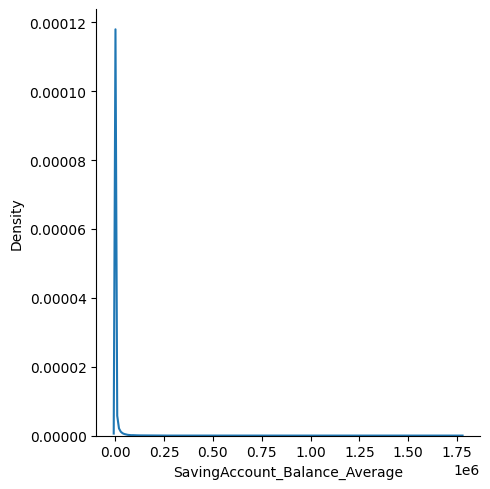

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a distribution plot
sns.displot(training_window['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

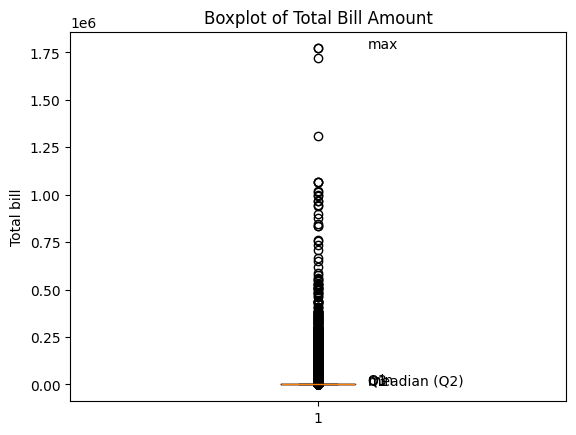

In [67]:
plt.boxplot(training_window['SavingAccount_Balance_Average'])

# add labels for five number summary
plt.text(x = 1.1, y = training_window['SavingAccount_Balance_Average'].min(), s ='min')
plt.text(x = 1.1, y = training_window['SavingAccount_Balance_Average'].quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = training_window['SavingAccount_Balance_Average'].median(), s ='meadian (Q2)')
plt.text(x = 1.1, y = training_window['SavingAccount_Balance_Average'].quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = training_window['SavingAccount_Balance_Average'].max(), s ='max')


# add the graph title and axes labels
plt.title('Boxplot of Total Bill Amount')
plt.ylabel('Total bill')

# display the plot
plt.show()

In [68]:
training_window['SavingAccount_Balance_Average'].describe()

count    1.391460e+05
mean     4.094871e+03
std      2.293939e+04
min     -5.665900e+02
25%      0.000000e+00
50%      1.032500e+01
75%      1.473138e+03
max      1.771201e+06
Name: SavingAccount_Balance_Average, dtype: float64

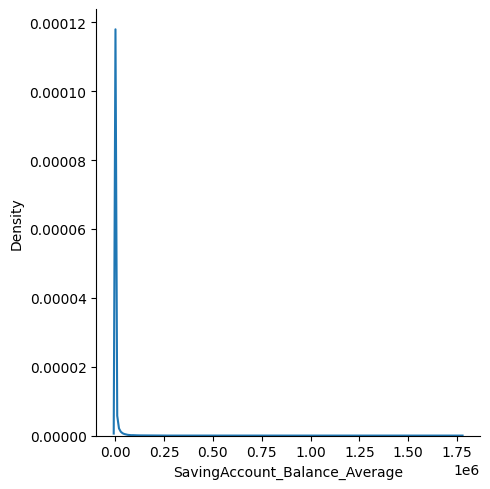

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a distribution plot
sns.displot(training_window['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [70]:
p95 = training_window['SavingAccount_Balance_Average'].quantile(0.95)
p99 = training_window['SavingAccount_Balance_Average'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Balance_Average'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          17043.66
p99          70055.67999999813
Three sigma  68818.178586892


In [71]:
training_window['SavingAccount_Balance_Average'] = np.where(training_window['SavingAccount_Balance_Average'] > three_sigma, 
                                                          three_sigma,
                                                         training_window['SavingAccount_Balance_Average'])

training_window['SavingAccount_Balance_Average'].describe()

count    139146.000000
mean       3179.457488
std        9821.897057
min        -566.590000
25%           0.000000
50%          10.325000
75%        1473.137500
max       68818.178587
Name: SavingAccount_Balance_Average, dtype: float64

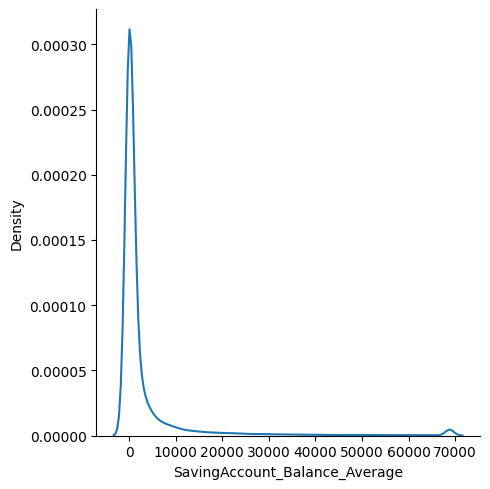

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a distribution plot
sns.displot(training_window['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [73]:
training_window['SavingAccount_Balance_Average'] = np.where(training_window['SavingAccount_Balance_Average'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_Balance_Average'])

training_window['SavingAccount_Balance_Average'].describe()

count    139146.000000
mean       2026.112910
std        4351.634834
min        -566.590000
25%           0.000000
50%          10.325000
75%        1473.137500
max       17043.660000
Name: SavingAccount_Balance_Average, dtype: float64

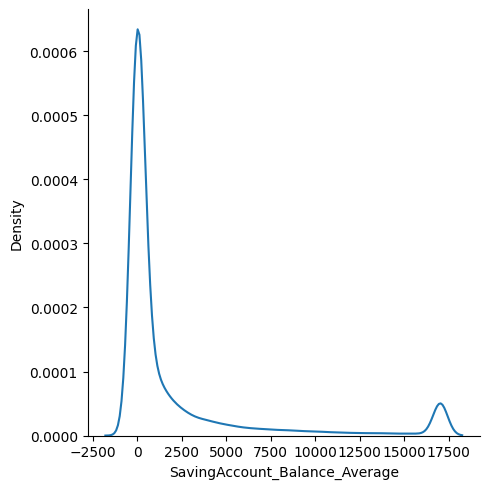

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a distribution plot
sns.displot(training_window['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

### Analisis de Outliers de variables 1 al 30

In [75]:
variables_analisis_outliers = ['SavingAccount_Days_with_Credits',
                               'SavingAccount_Days_with_Debits',
                               'SavingAccount_Salary_Payment_Transactions',
                               'SavingAccount_Transfer_In_Transactions',
                               'SavingAccount_ATM_Extraction_Transactions',
                               'SavingAccount_CreditCard_Payment_Transactions',
                               'SavingAccount_Transfer_Out_Transactions',
                               'SavingAccount_DebitCard_Spend_Transactions',
                               'SavingAccount_Transactions_Transactions',
                               'SavingAccount_Credits_Transactions',
                               'SavingAccount_Debits_Transactions',
                               'SavingAccount_Salary_Payment_Amount',
                               'SavingAccount_Transfer_In_Amount',
                               'SavingAccount_ATM_Extraction_Amount',
                               'SavingAccount_CreditCard_Payment_Amount',
                               'SavingAccount_Transfer_Out_Amount',
                               'SavingAccount_DebitCard_Spend_Amount',
                               'SavingAccount_Total_Amount',
                               'SavingAccount_Credits_Amounts',
                               'SavingAccount_Debits_Amounts',
                               'Operations_HomeBanking',
                               'Operations_Mobile',
                               'CreditCard_Balance_ARG',
                               'CreditCard_Balance_DOLLAR',
                               'CreditCard_Total_Limit',
                               'CreditCard_Total_Spending',
                               'CreditCard_Spending_1_Installment',
                               'CreditCard_Spending_CrossBoarder',
                               'CreditCard_Spending_Aut_Debits',
                               'CreditCard_Revolving']

************************************************************ 
Variable  SavingAccount_Days_with_Credits
 


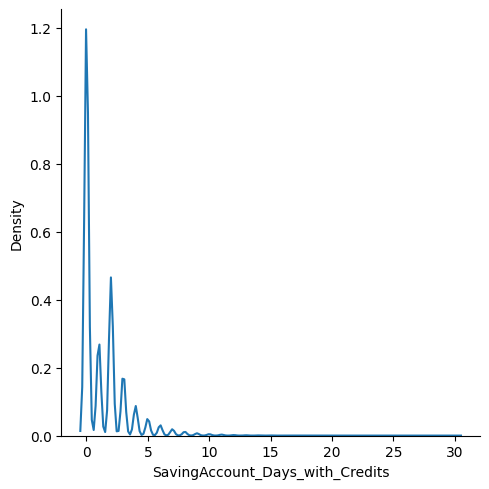

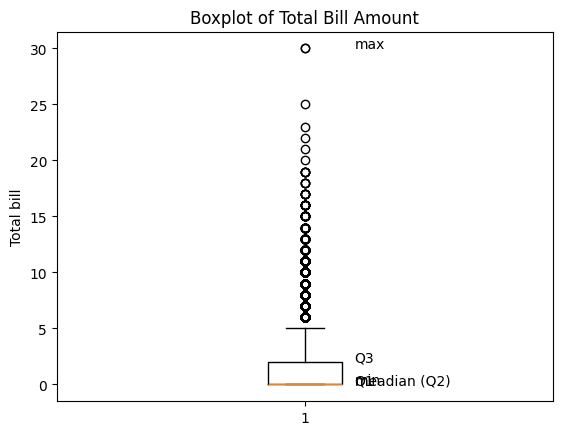

p95          5.0
p99          8.0
Three sigma  5.3821836766669335
************************************************************ 
Variable  SavingAccount_Days_with_Debits
 


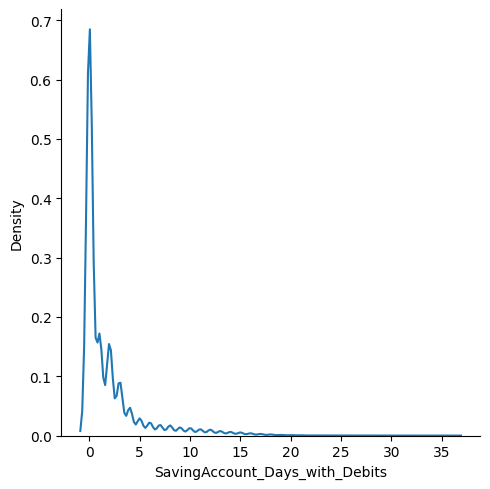

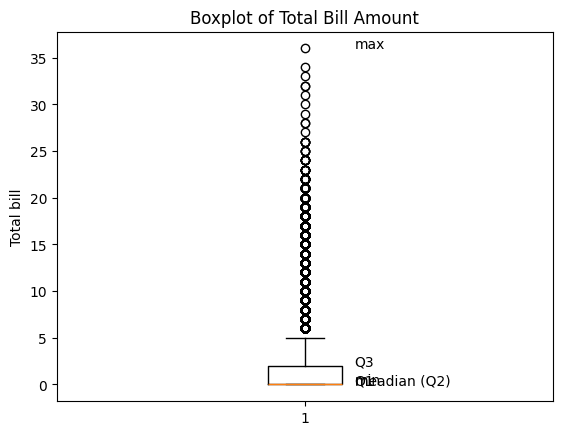

p95          9.0
p99          15.0
Three sigma  9.723007390387242
************************************************************ 
Variable  SavingAccount_Salary_Payment_Transactions
 


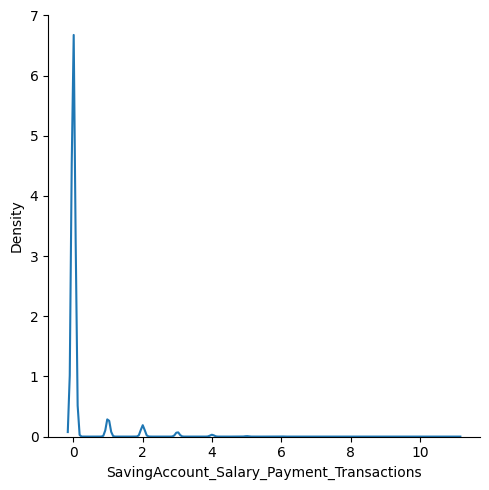

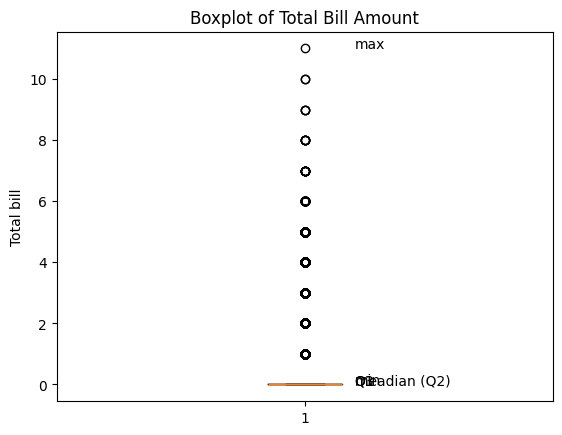

p95          1.0
p99          3.0
Three sigma  1.7306415659542151
************************************************************ 
Variable  SavingAccount_Transfer_In_Transactions
 


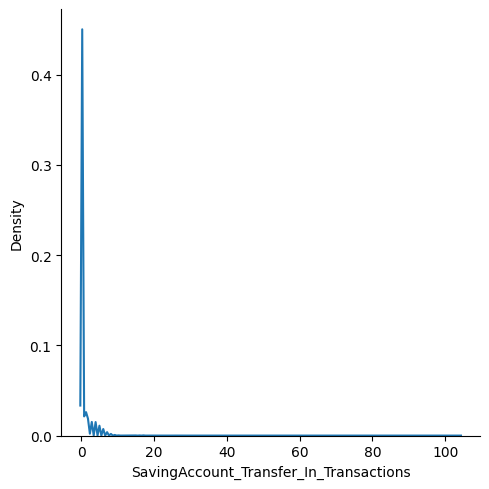

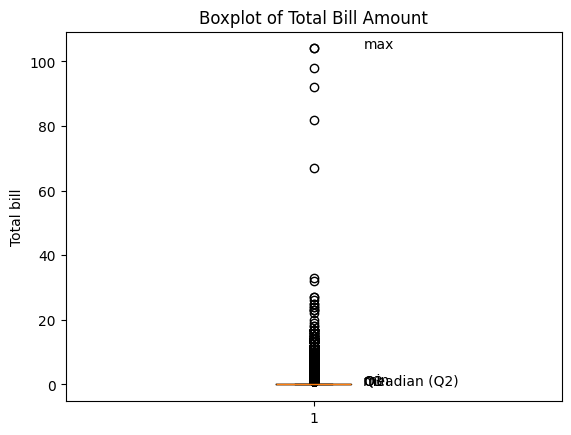

p95          2.0
p99          4.0
Three sigma  3.4065241487924736
************************************************************ 
Variable  SavingAccount_ATM_Extraction_Transactions
 


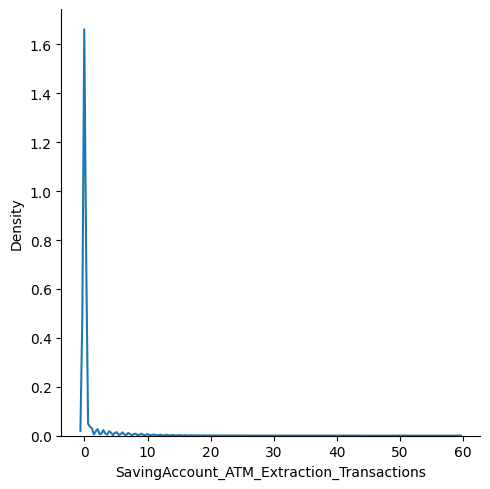

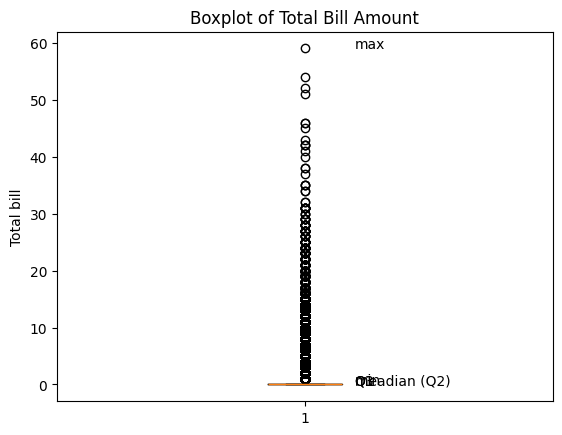

p95          4.0
p99          12.0
Three sigma  6.793744483785929
************************************************************ 
Variable  SavingAccount_CreditCard_Payment_Transactions
 


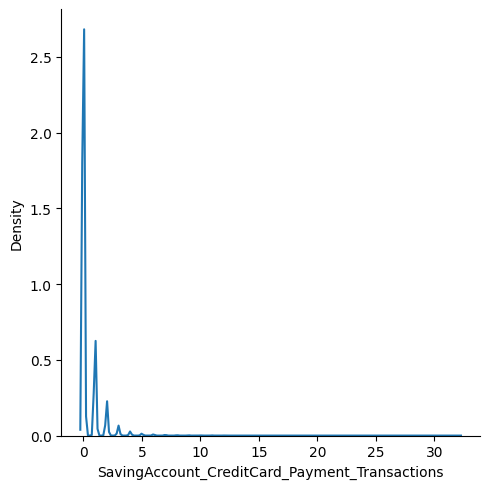

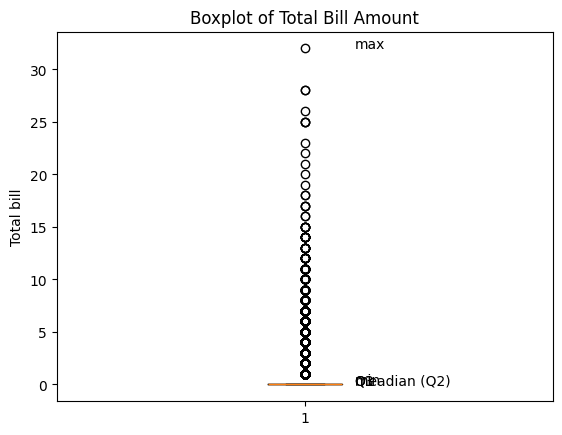

p95          2.0
p99          4.0
Three sigma  2.820305708750473
************************************************************ 
Variable  SavingAccount_Transfer_Out_Transactions
 


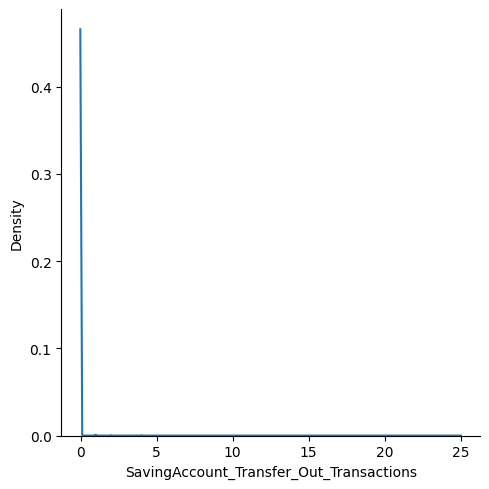

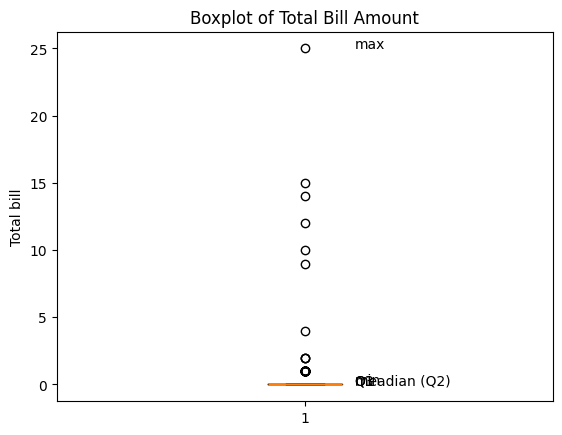

p95          0.0
p99          0.0
Three sigma  0.3047514185040877
************************************************************ 
Variable  SavingAccount_DebitCard_Spend_Transactions
 


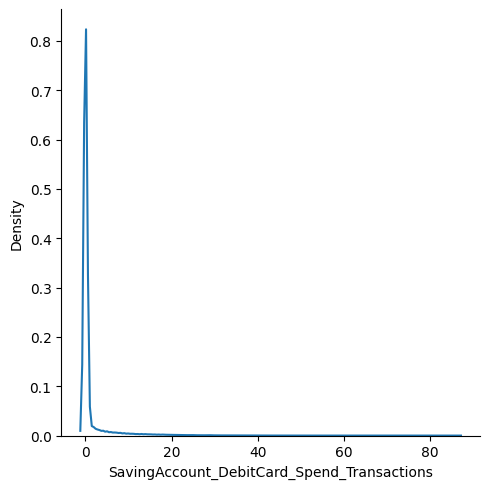

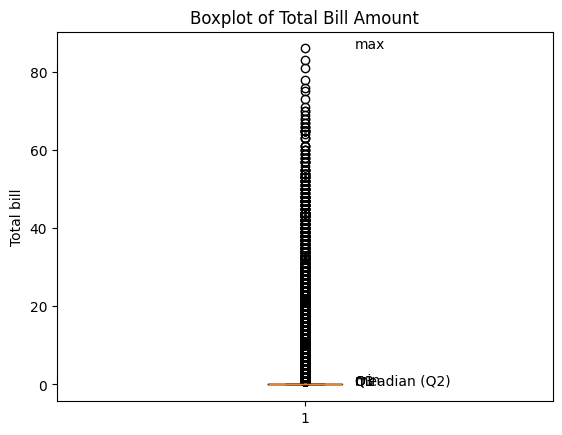

p95          7.0
p99          22.0
Three sigma  12.865522801673926
************************************************************ 
Variable  SavingAccount_Transactions_Transactions
 


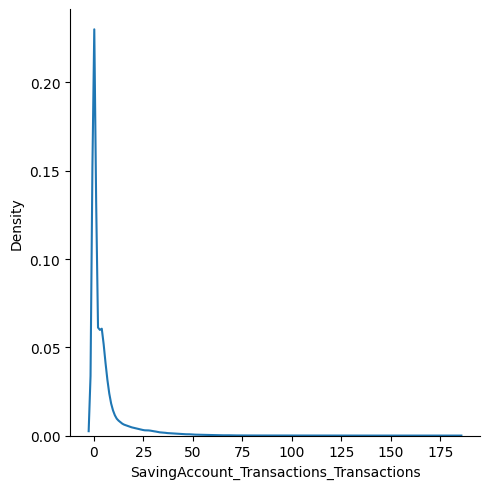

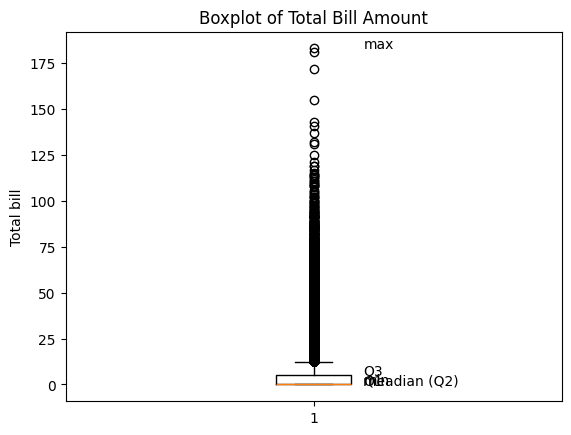

p95          24.0
p99          47.0
Three sigma  28.791754836314986
************************************************************ 
Variable  SavingAccount_Credits_Transactions
 


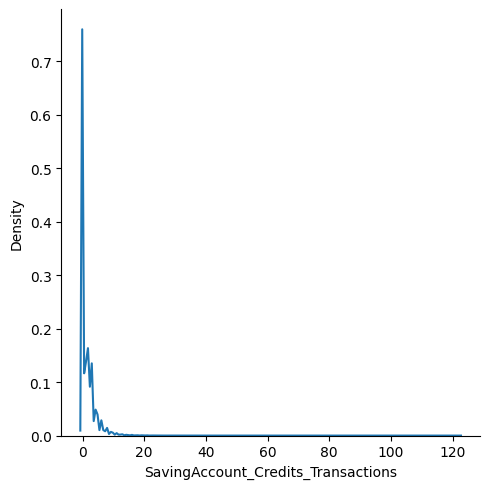

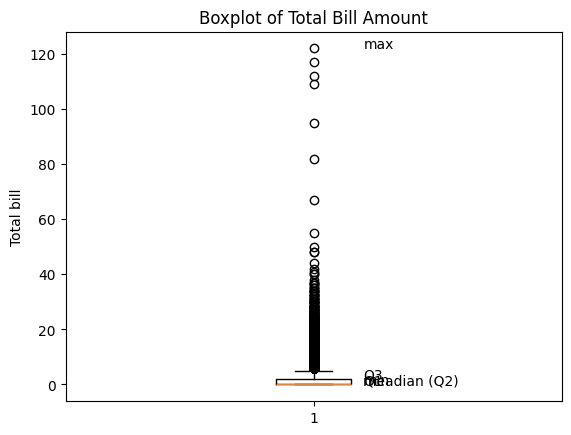

p95          6.0
p99          11.0
Three sigma  7.817126304056519
************************************************************ 
Variable  SavingAccount_Debits_Transactions
 


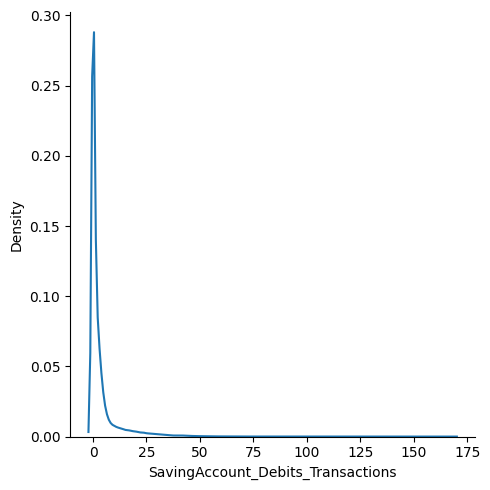

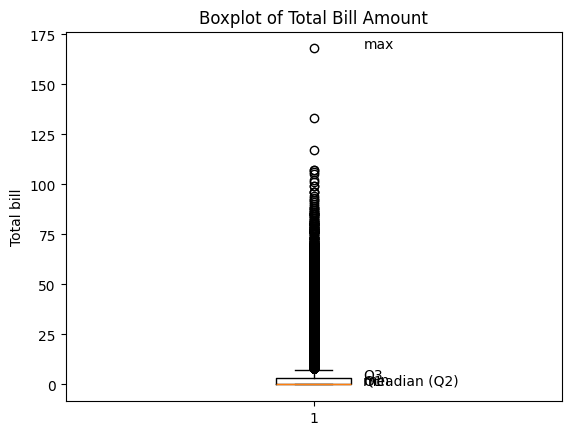

p95          19.0
p99          38.0
Three sigma  22.894184199079866
************************************************************ 
Variable  SavingAccount_Salary_Payment_Amount
 


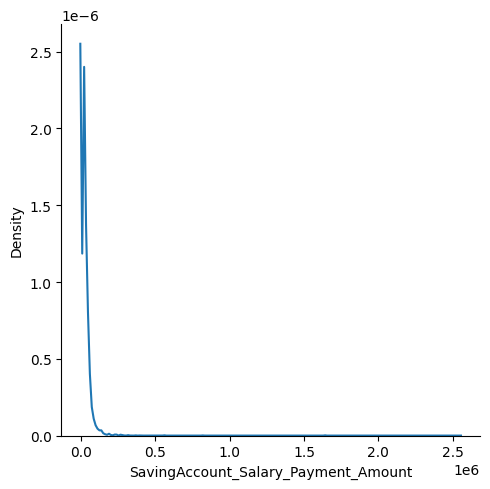

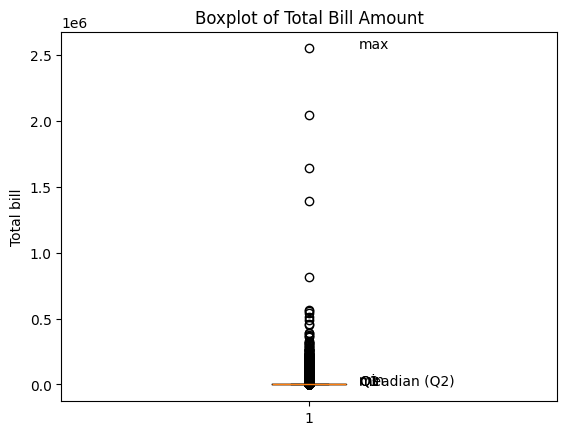

p95          22890.7775
p99          58568.9505
Three sigma  50991.24006782155
************************************************************ 
Variable  SavingAccount_Transfer_In_Amount
 


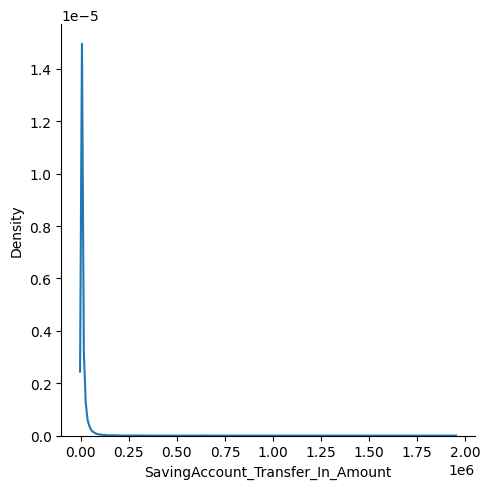

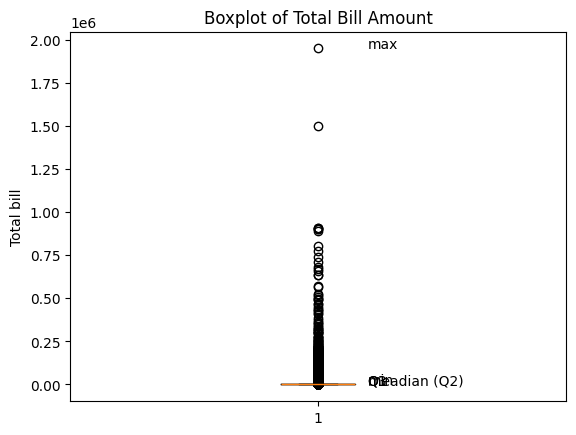

p95          13000.0
p99          43000.0
Three sigma  46628.46407356864
************************************************************ 
Variable  SavingAccount_ATM_Extraction_Amount
 


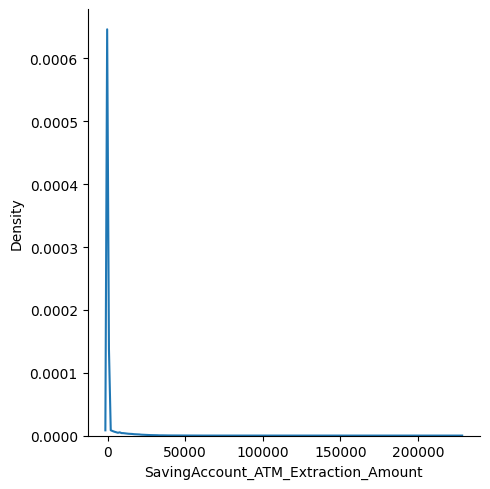

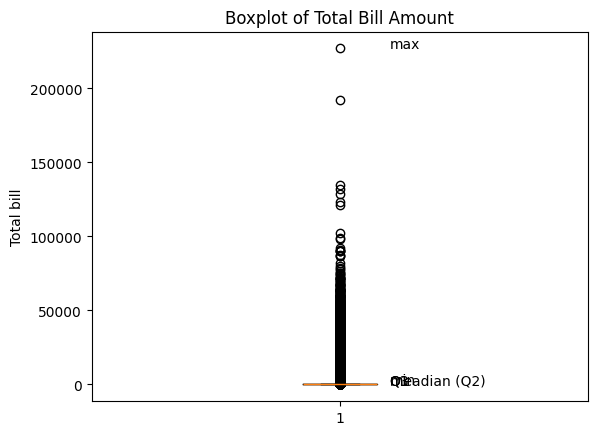

p95          8600.0
p99          25400.0
Three sigma  15161.853538210948
************************************************************ 
Variable  SavingAccount_CreditCard_Payment_Amount
 


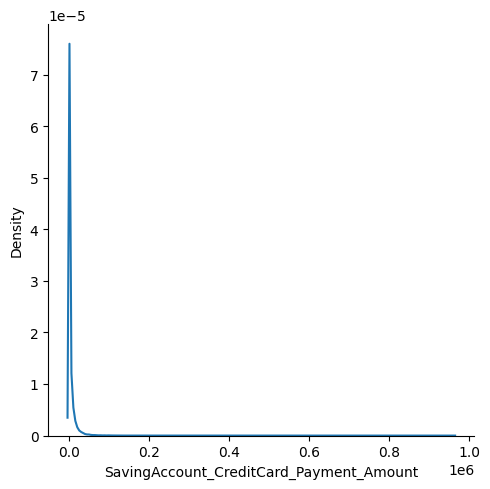

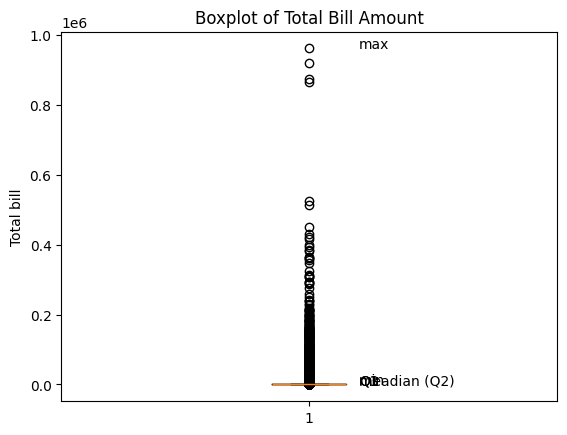

p95          11868.3125
p99          33823.049999999756
Three sigma  31971.212947940097
************************************************************ 
Variable  SavingAccount_Transfer_Out_Amount
 


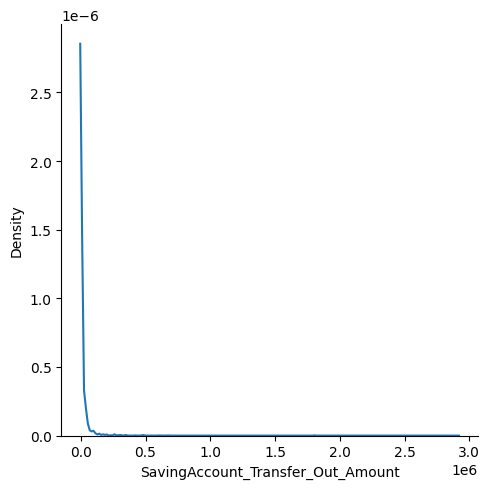

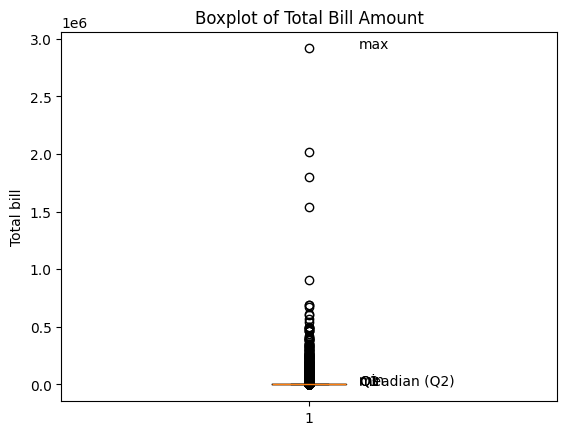

p95          0.0
p99          21453.013999999937
Three sigma  47523.41379065669
************************************************************ 
Variable  SavingAccount_DebitCard_Spend_Amount
 


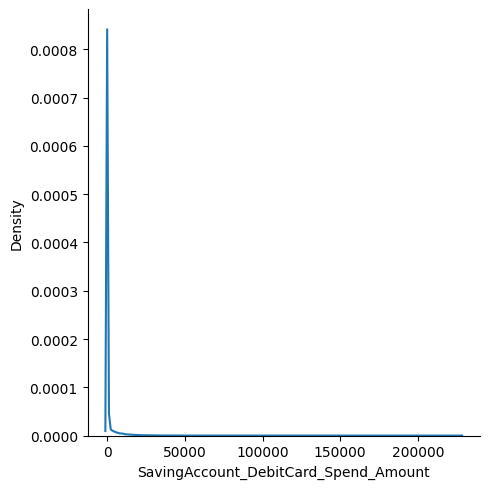

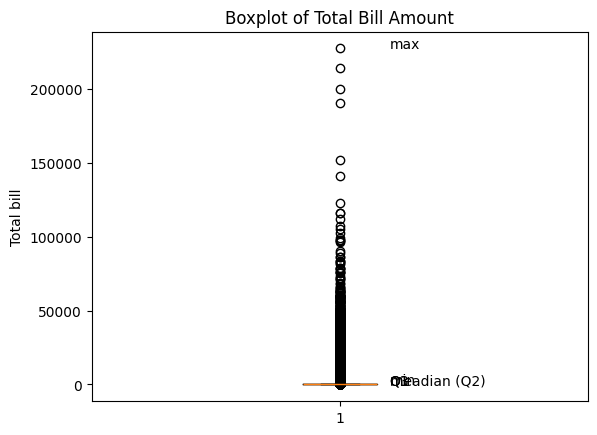

p95          6350.3125
p99          20862.84349999993
Three sigma  13168.561377041347
************************************************************ 
Variable  SavingAccount_Total_Amount
 


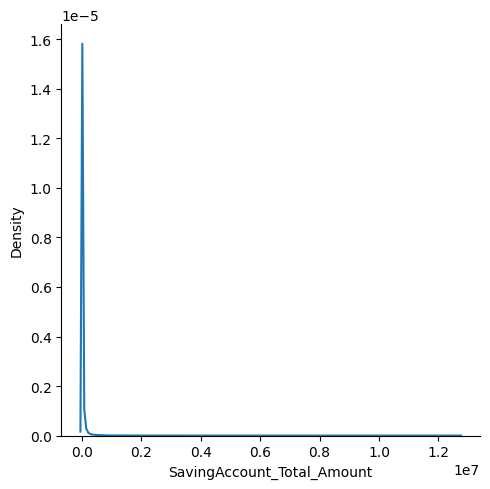

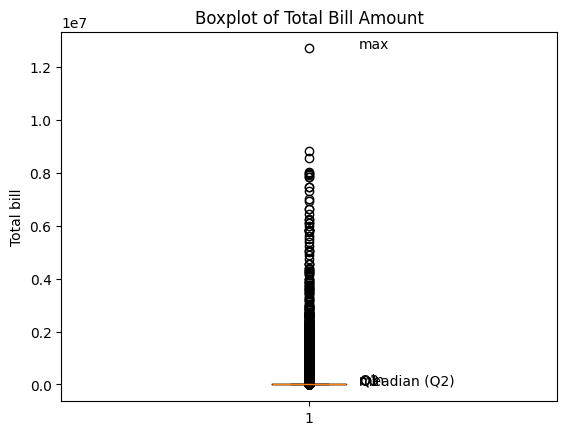

p95          109939.47
p99          527795.7179999923
Three sigma  536040.4438446803
************************************************************ 
Variable  SavingAccount_Credits_Amounts
 


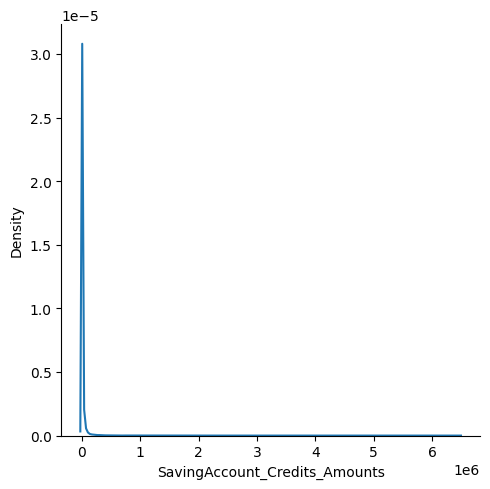

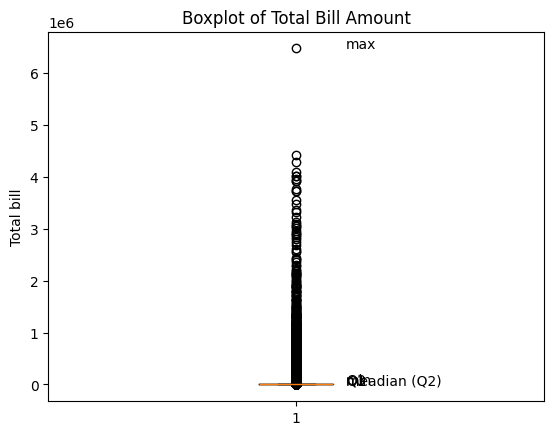

p95          54835.455
p99          269663.80649999913
Three sigma  271204.21506443416
************************************************************ 
Variable  SavingAccount_Debits_Amounts
 


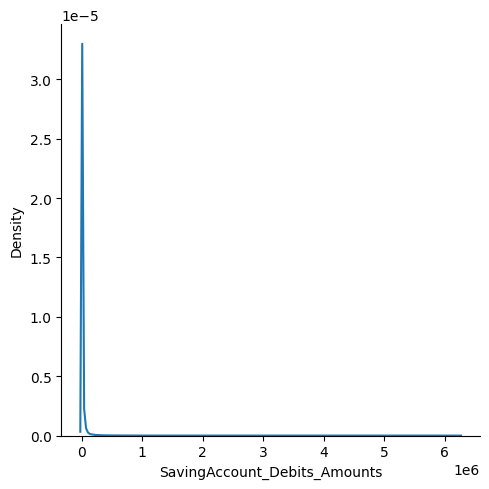

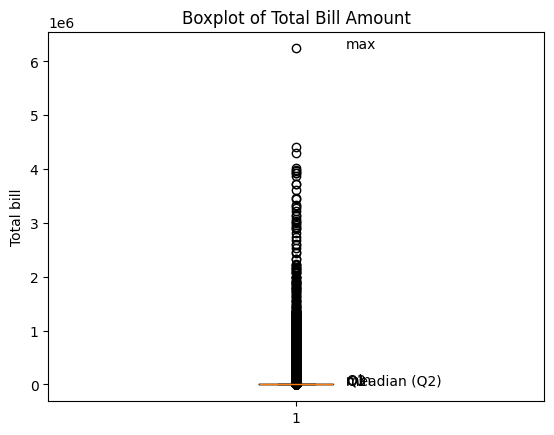

p95          54108.784999999996
p99          268277.130499996
Three sigma  269760.6696250981
************************************************************ 
Variable  Operations_HomeBanking
 


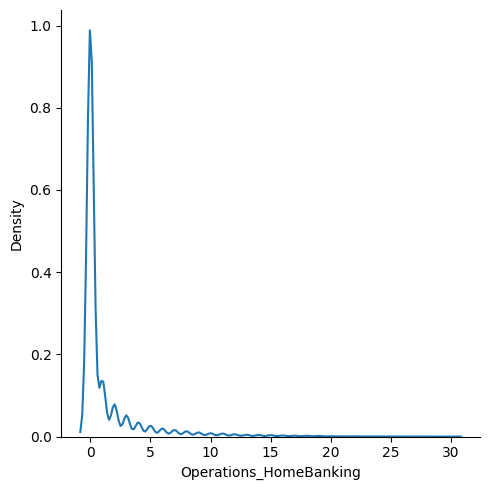

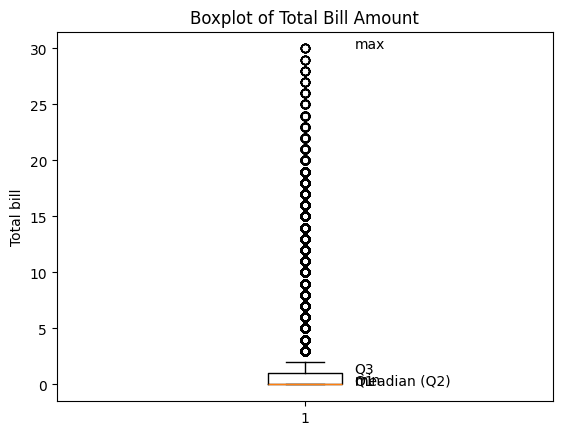

p95          7.0
p99          15.0
Three sigma  8.928026498997632
************************************************************ 
Variable  Operations_Mobile
 


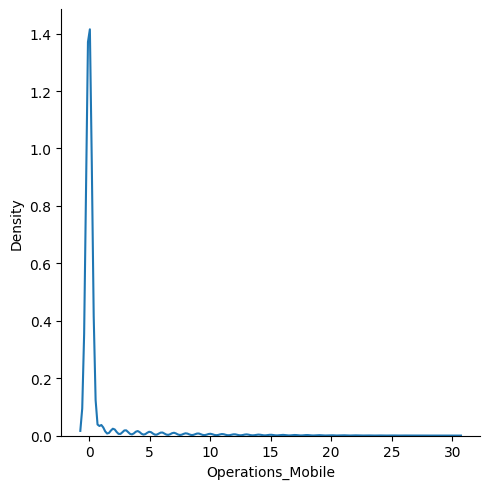

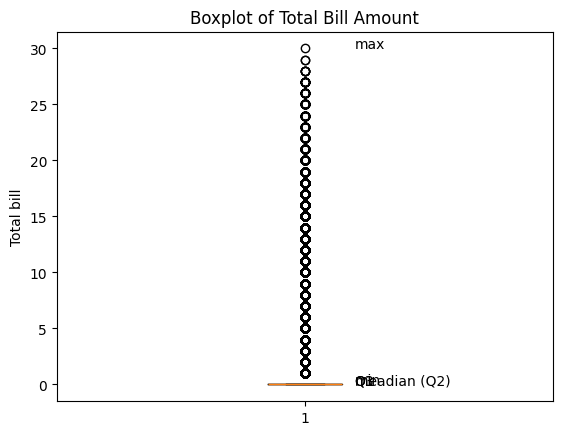

p95          5.0
p99          14.0
Three sigma  7.72057758014084
************************************************************ 
Variable  CreditCard_Balance_ARG
 


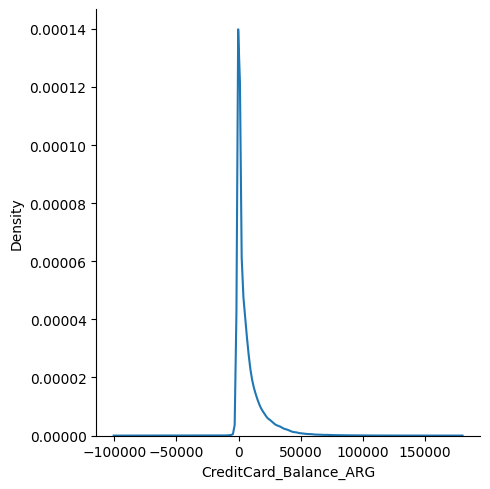

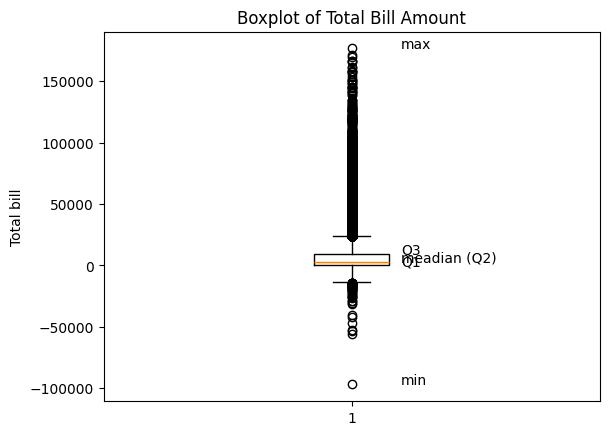

p95          30815.11
p99          55138.89599999998
Three sigma  35962.00973574623
************************************************************ 
Variable  CreditCard_Balance_DOLLAR
 


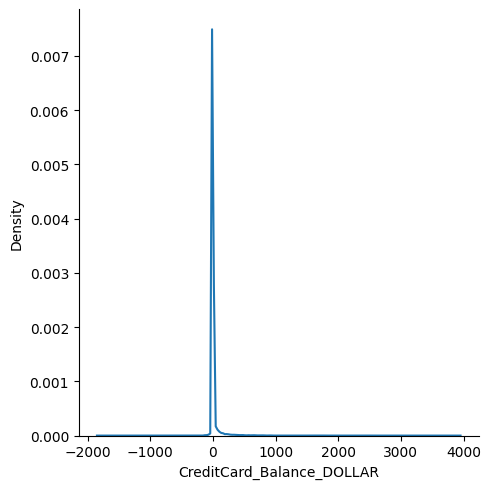

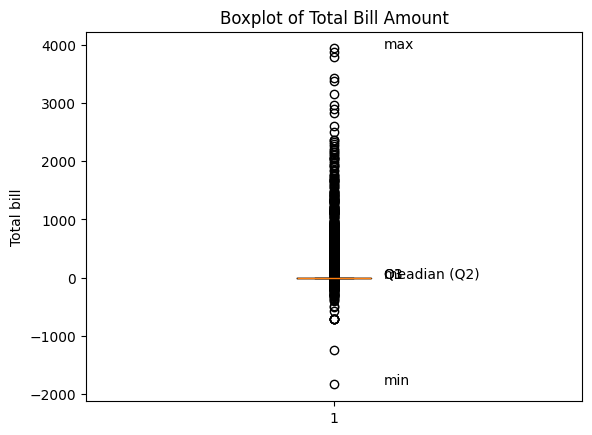

p95          0.99
p99          132.93649999999963
Three sigma  200.20502558797813
************************************************************ 
Variable  CreditCard_Total_Limit
 


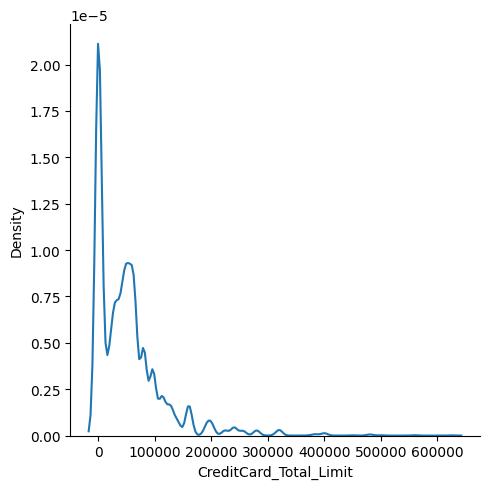

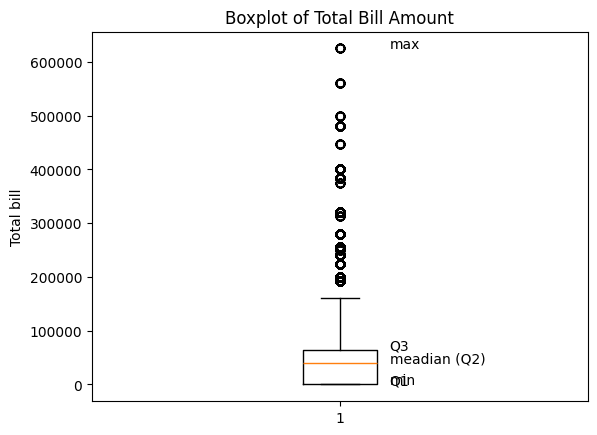

p95          160000.0
p99          280000.0
Three sigma  184838.11811993475
************************************************************ 
Variable  CreditCard_Total_Spending
 


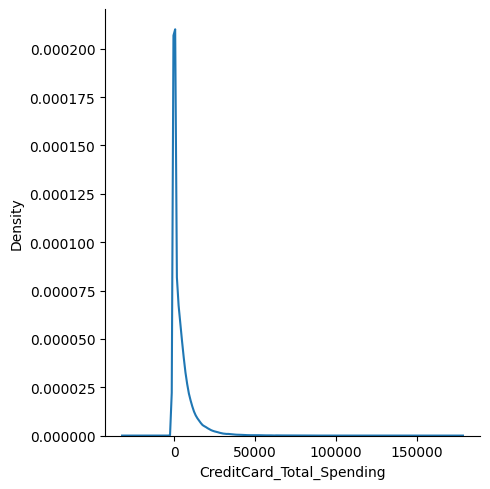

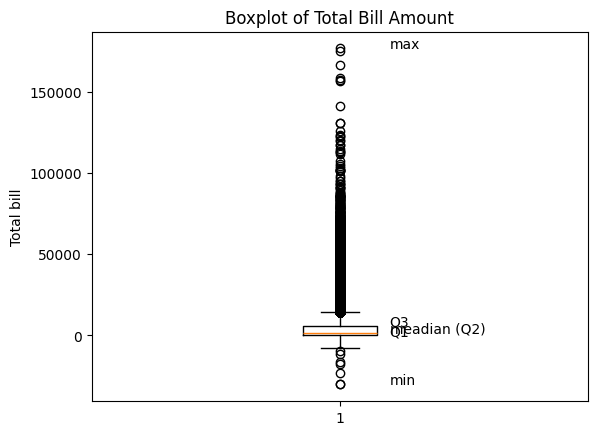

p95          17131.6725
p99          33148.23549999999
Three sigma  21870.01520929554
************************************************************ 
Variable  CreditCard_Spending_1_Installment
 


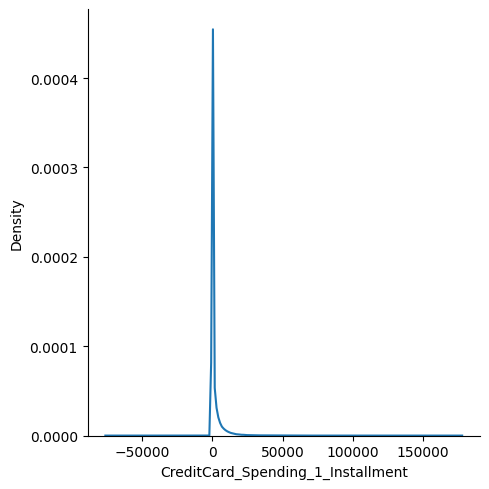

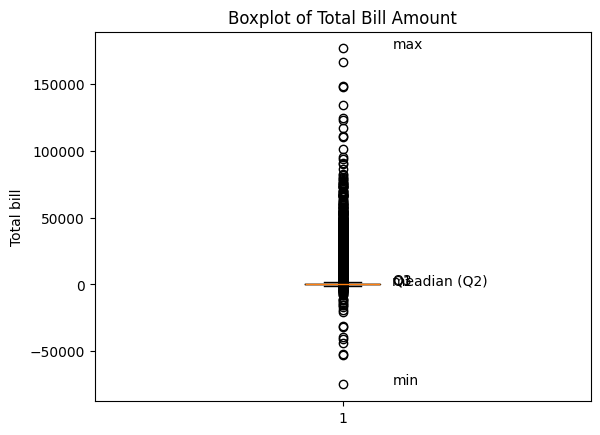

p95          7739.59
p99          19681.75649999997
Three sigma  12897.110532905726
************************************************************ 
Variable  CreditCard_Spending_CrossBoarder
 


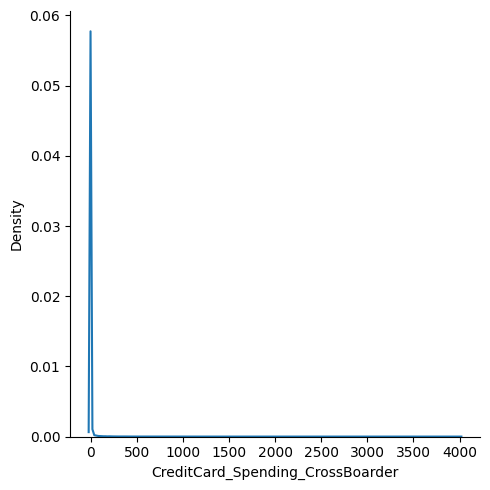

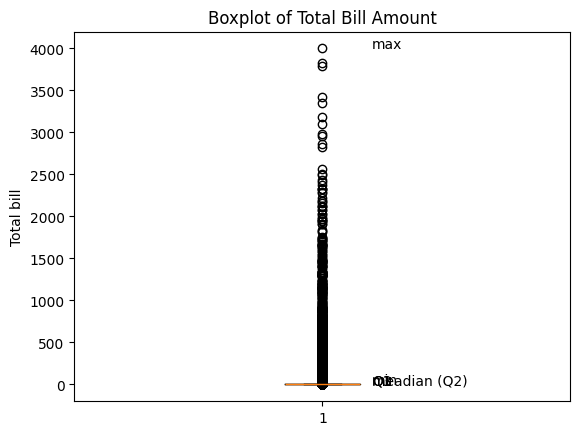

p95          0.99
p99          143.6204999999987
Three sigma  212.90138519851982
************************************************************ 
Variable  CreditCard_Spending_Aut_Debits
 


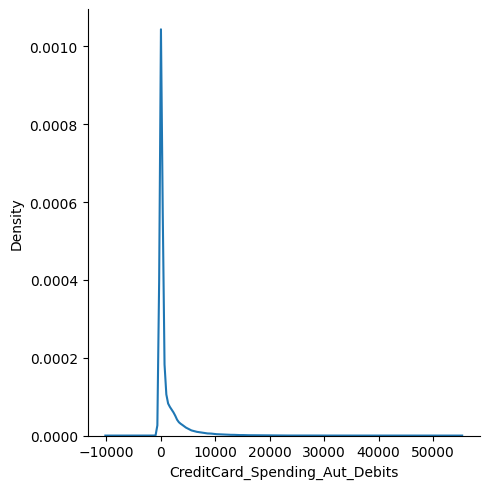

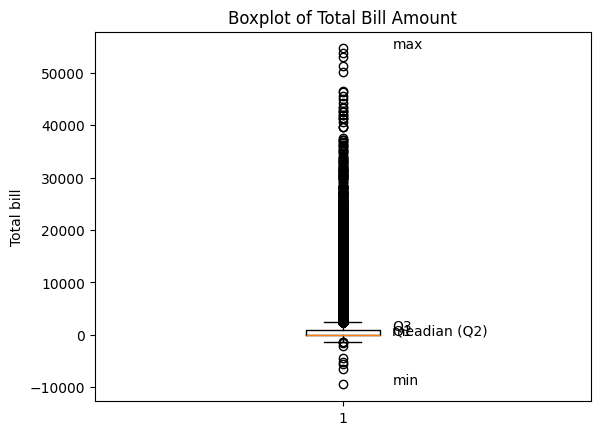

p95          5619.7275
p99          12510.912499999991
Three sigma  7806.871328247001
************************************************************ 
Variable  CreditCard_Revolving
 


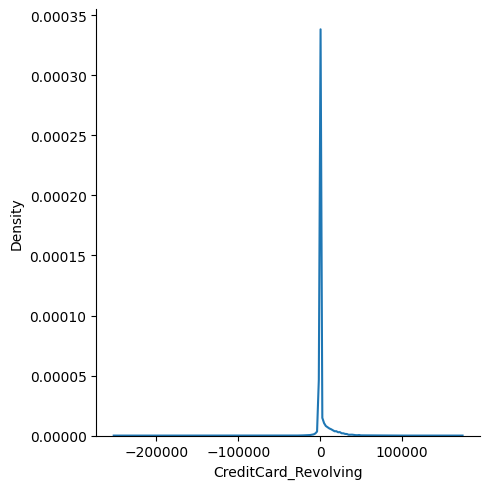

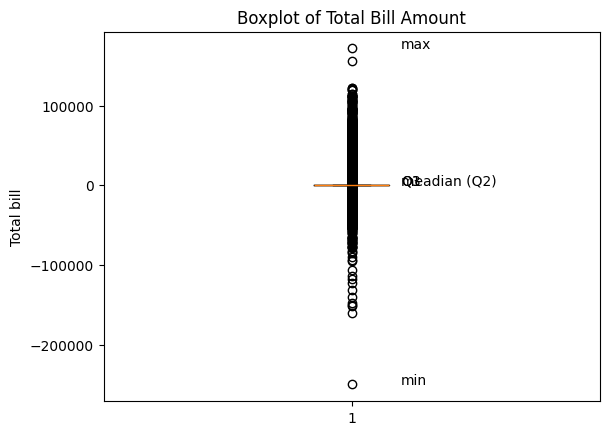

p95          17291.8975
p99          36175.25699999951
Three sigma  23840.512630865414


In [76]:
for variables_analizables in variables_analisis_outliers:
    print('************************************************************ ')
    print('Variable ', variables_analizables)
    print(' ')
    
    training_window[variables_analizables].describe()
    # plot a distribution plot
    sns.displot(training_window[variables_analizables], kind='kde')

    # display the plot
    plt.show()
    
    plt.boxplot(training_window[variables_analizables])

    # add labels for five number summary
    plt.text(x = 1.1, y = training_window[variables_analizables].min(), s ='min')
    plt.text(x = 1.1, y = training_window[variables_analizables].quantile(0.25), s ='Q1')
    plt.text(x = 1.1, y = training_window[variables_analizables].median(), s ='meadian (Q2)')
    plt.text(x = 1.1, y = training_window[variables_analizables].quantile(0.75), s ='Q3')
    plt.text(x = 1.1, y = training_window[variables_analizables].max(), s ='max')


    # add the graph title and axes labels
    plt.title('Boxplot of Total Bill Amount')
    plt.ylabel('Total bill')

    # display the plot
    plt.show()
    
    p95 = training_window[variables_analizables].quantile(0.95)
    p99 = training_window[variables_analizables].quantile(0.99)
    three_sigma = 3 * training_window[variables_analizables].std()

    print('p95         ', p95)
    print('p99         ', p99)
    print('Three sigma ', three_sigma)
    
    training_window[variables_analizables].describe()
    

## quitando outliers Variable: SavingAccount_Days_with_Credits

In [77]:
p95 = training_window['SavingAccount_Days_with_Credits'].quantile(0.95)
p99 = training_window['SavingAccount_Days_with_Credits'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Days_with_Credits'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          5.0
p99          8.0
Three sigma  5.3821836766669335


In [78]:
training_window['SavingAccount_Days_with_Credits'] = np.where(training_window['SavingAccount_Days_with_Credits'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_Days_with_Credits'])

training_window['SavingAccount_Days_with_Credits'].describe()

count    139146.000000
mean          1.232504
std           1.691454
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max           8.000000
Name: SavingAccount_Days_with_Credits, dtype: float64

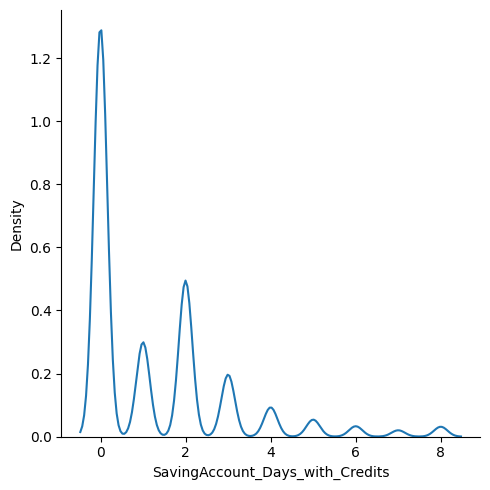

In [79]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Days_with_Credits'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Days_with_Debits

In [80]:
p95 = training_window['SavingAccount_Days_with_Debits'].quantile(0.95)
p99 = training_window['SavingAccount_Days_with_Debits'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Days_with_Debits'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          9.0
p99          15.0
Three sigma  9.723007390387242


In [81]:
training_window['SavingAccount_Days_with_Debits'] = np.where(training_window['SavingAccount_Days_with_Debits'] > three_sigma, 
                                                          three_sigma,
                                                         training_window['SavingAccount_Days_with_Debits'])

training_window['SavingAccount_Days_with_Debits'].describe()

count    139146.000000
mean          1.690302
std           2.649375
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max           9.723007
Name: SavingAccount_Days_with_Debits, dtype: float64

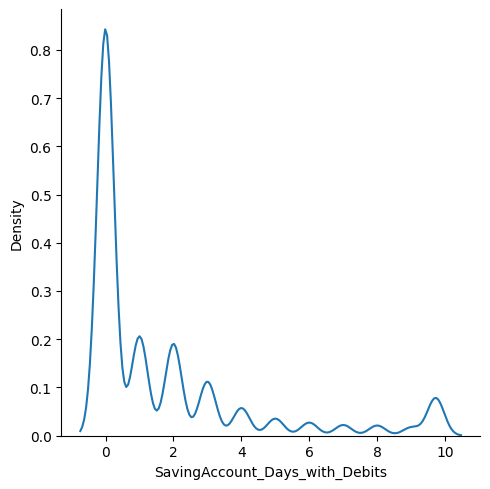

In [82]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Days_with_Debits'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable:  SavingAccount_Salary_Payment_Transactions

In [83]:
p95 = training_window['SavingAccount_Salary_Payment_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_Salary_Payment_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Salary_Payment_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          1.0
p99          3.0
Three sigma  1.7306415659542151


In [84]:
training_window['SavingAccount_Salary_Payment_Transactions'] = np.where(training_window['SavingAccount_Salary_Payment_Transactions'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_Salary_Payment_Transactions'])

training_window['SavingAccount_Salary_Payment_Transactions'].describe()

count    139146.000000
mean          0.142534
std           0.520272
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: SavingAccount_Salary_Payment_Transactions, dtype: float64

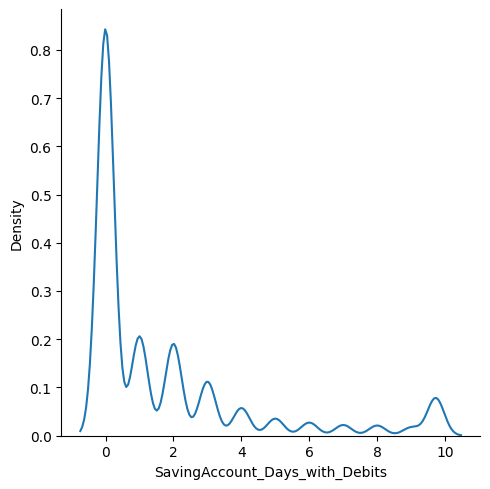

In [85]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Days_with_Debits'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable:  SavingAccount_Transfer_In_Transactions

In [86]:
p95 = training_window['SavingAccount_Transfer_In_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_Transfer_In_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Transfer_In_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          2.0
p99          4.0
Three sigma  3.4065241487924736


In [87]:
training_window['SavingAccount_Transfer_In_Transactions'] = np.where(training_window['SavingAccount_Transfer_In_Transactions'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_Transfer_In_Transactions'])

training_window['SavingAccount_Transfer_In_Transactions'].describe()

count    139146.000000
mean          0.314993
std           0.750827
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: SavingAccount_Transfer_In_Transactions, dtype: float64

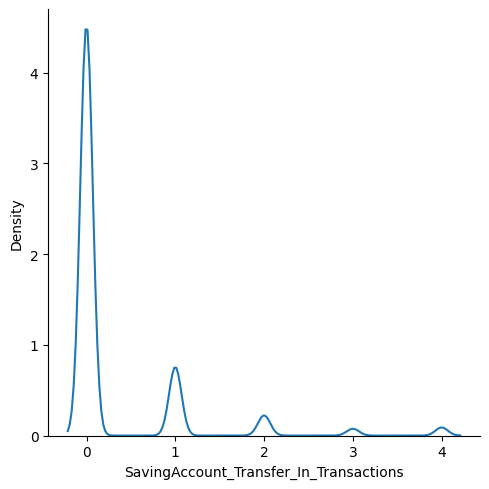

In [88]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Transfer_In_Transactions'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_ATM_Extraction_Transactions

In [89]:
p95 = training_window['SavingAccount_ATM_Extraction_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_ATM_Extraction_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_ATM_Extraction_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          4.0
p99          12.0
Three sigma  6.793744483785929


In [90]:
training_window['SavingAccount_ATM_Extraction_Transactions'] = np.where(training_window['SavingAccount_ATM_Extraction_Transactions'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_ATM_Extraction_Transactions'])

training_window['SavingAccount_ATM_Extraction_Transactions'].describe()

count    139146.000000
mean          0.320505
std           1.006634
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: SavingAccount_ATM_Extraction_Transactions, dtype: float64

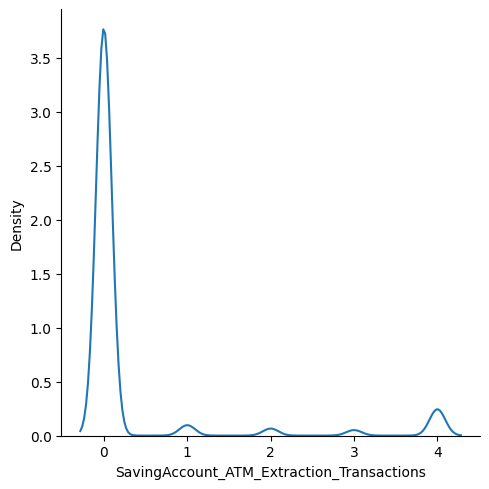

In [91]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_ATM_Extraction_Transactions'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_CreditCard_Payment_Transactions

In [92]:
p95 = training_window['SavingAccount_CreditCard_Payment_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_CreditCard_Payment_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_CreditCard_Payment_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          2.0
p99          4.0
Three sigma  2.820305708750473


In [93]:
training_window['SavingAccount_CreditCard_Payment_Transactions'] = np.where(training_window['SavingAccount_CreditCard_Payment_Transactions'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_CreditCard_Payment_Transactions'])

training_window['SavingAccount_CreditCard_Payment_Transactions'].describe()

count    139146.000000
mean          0.359170
std           0.767203
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: SavingAccount_CreditCard_Payment_Transactions, dtype: float64

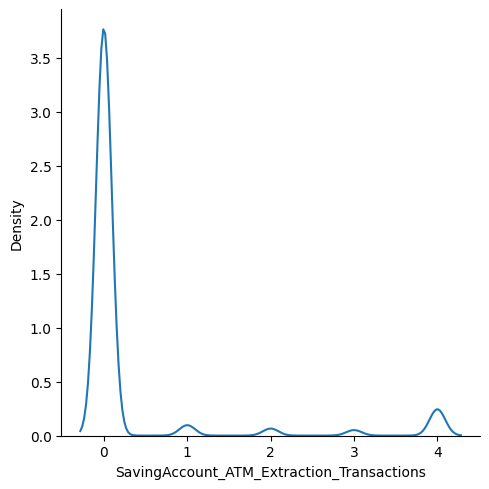

In [94]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_ATM_Extraction_Transactions'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Transfer_Out_Transactions

In [95]:
p95 = training_window['SavingAccount_Transfer_Out_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_Transfer_Out_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Transfer_Out_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          0.0
p99          0.0
Three sigma  0.3047514185040877


In [96]:
training_window.SavingAccount_Transfer_Out_Transactions.value_counts()

SavingAccount_Transfer_Out_Transactions
0.0     139099
1.0         37
2.0          3
10.0         1
9.0          1
15.0         1
25.0         1
14.0         1
4.0          1
12.0         1
Name: count, dtype: int64

In [97]:
# revisar, preguntar sobre esta variable: SavingAccount_Transfer_Out_Transactions

## quitando outliers Variable: SavingAccount_DebitCard_Spend_Transactions

In [98]:
p95 = training_window['SavingAccount_DebitCard_Spend_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_DebitCard_Spend_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_DebitCard_Spend_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          7.0
p99          22.0
Three sigma  12.865522801673926


In [99]:
training_window['SavingAccount_DebitCard_Spend_Transactions'] = np.where(training_window['SavingAccount_DebitCard_Spend_Transactions'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_DebitCard_Spend_Transactions'])

training_window['SavingAccount_DebitCard_Spend_Transactions'].describe()

count    139146.000000
mean          0.991390
std           3.528173
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          22.000000
Name: SavingAccount_DebitCard_Spend_Transactions, dtype: float64

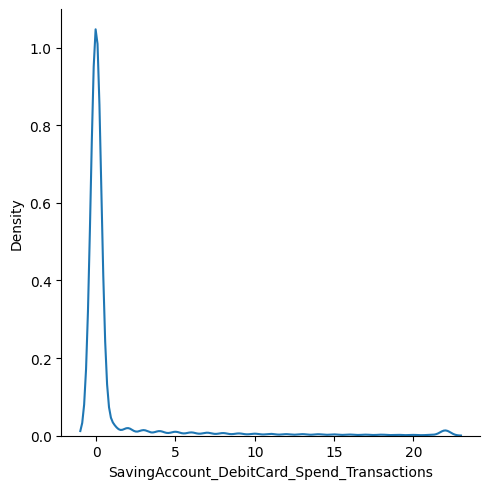

In [100]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_DebitCard_Spend_Transactions'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Transactions_Transactions

In [101]:
p95 = training_window['SavingAccount_Transactions_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_Transactions_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Transactions_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          24.0
p99          47.0
Three sigma  28.791754836314986


In [102]:
training_window['SavingAccount_Transactions_Transactions'] = np.where(training_window['SavingAccount_Transactions_Transactions'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_Transactions_Transactions'])

training_window['SavingAccount_Transactions_Transactions'].describe()

count    139146.000000
mean          4.765656
std           8.710314
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max          47.000000
Name: SavingAccount_Transactions_Transactions, dtype: float64

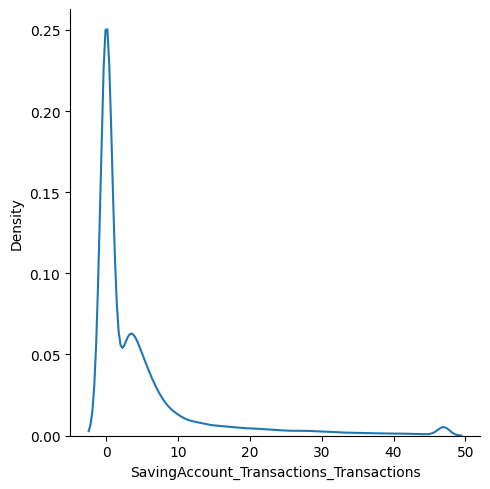

In [103]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Transactions_Transactions'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Credits_Transactions

In [104]:
p95 = training_window['SavingAccount_Credits_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_Credits_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Credits_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          6.0
p99          11.0
Three sigma  7.817126304056519


In [105]:
training_window['SavingAccount_Credits_Transactions'] = np.where(training_window['SavingAccount_Credits_Transactions'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_Credits_Transactions'])

training_window['SavingAccount_Credits_Transactions'].describe()

count    139146.000000
mean          1.509573
std           2.220993
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          11.000000
Name: SavingAccount_Credits_Transactions, dtype: float64

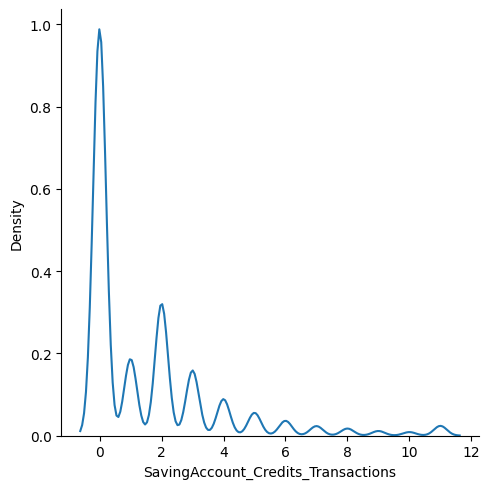

In [106]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Credits_Transactions'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Debits_Transactions

In [107]:
p95 = training_window['SavingAccount_Debits_Transactions'].quantile(0.95)
p99 = training_window['SavingAccount_Debits_Transactions'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Debits_Transactions'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          19.0
p99          38.0
Three sigma  22.894184199079866


In [108]:
training_window['SavingAccount_Debits_Transactions'] = np.where(training_window['SavingAccount_Debits_Transactions'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_Debits_Transactions'])

training_window['SavingAccount_Debits_Transactions'].describe()

count    139146.000000
mean          3.222780
std           6.824929
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          38.000000
Name: SavingAccount_Debits_Transactions, dtype: float64

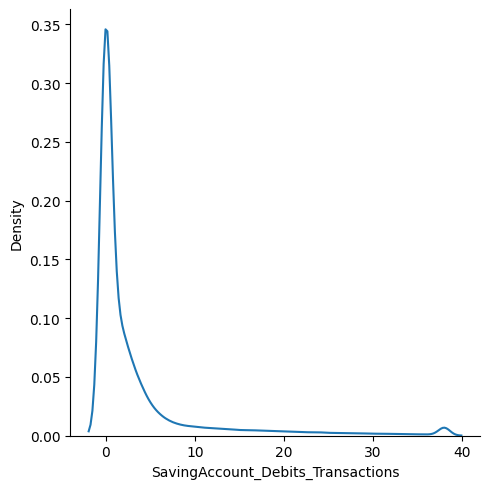

In [109]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Debits_Transactions'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Salary_Payment_Amount

In [110]:
p95 = training_window['SavingAccount_Salary_Payment_Amount'].quantile(0.95)
p99 = training_window['SavingAccount_Salary_Payment_Amount'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Salary_Payment_Amount'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          22890.7775
p99          58568.9505
Three sigma  50991.24006782155


In [111]:
training_window['SavingAccount_Salary_Payment_Amount'] = np.where(training_window['SavingAccount_Salary_Payment_Amount'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_Salary_Payment_Amount'])

training_window['SavingAccount_Salary_Payment_Amount'].describe()

count    139146.000000
mean       1621.769465
std        5617.856081
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       22890.777500
Name: SavingAccount_Salary_Payment_Amount, dtype: float64

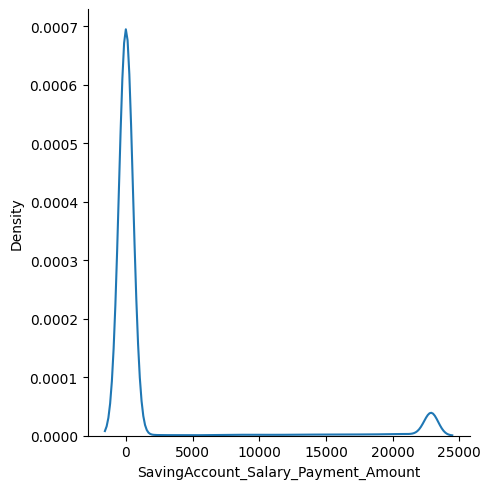

In [112]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Salary_Payment_Amount'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Transfer_In_Amount

In [113]:
p95 = training_window['SavingAccount_Transfer_In_Amount'].quantile(0.95)
p99 = training_window['SavingAccount_Transfer_In_Amount'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Transfer_In_Amount'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          13000.0
p99          43000.0
Three sigma  46628.46407356864


In [114]:
training_window['SavingAccount_Transfer_In_Amount'] = np.where(training_window['SavingAccount_Transfer_In_Amount'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_Transfer_In_Amount'])

training_window['SavingAccount_Transfer_In_Amount'].describe()

count    139146.000000
mean       1420.367686
std        3444.238763
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       13000.000000
Name: SavingAccount_Transfer_In_Amount, dtype: float64

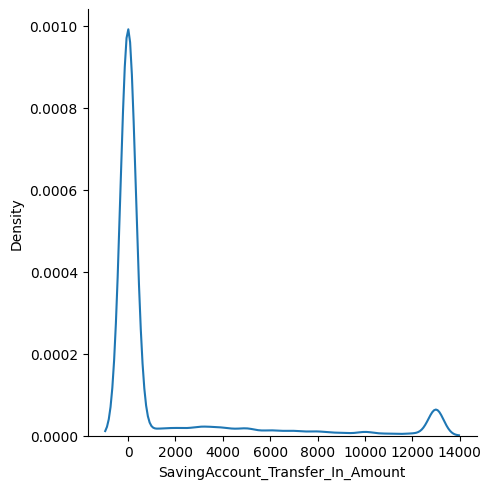

In [115]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Transfer_In_Amount'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_ATM_Extraction_Amount

In [116]:
p95 = training_window['SavingAccount_ATM_Extraction_Amount'].quantile(0.95)
p99 = training_window['SavingAccount_ATM_Extraction_Amount'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_ATM_Extraction_Amount'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          8600.0
p99          25400.0
Three sigma  15161.853538210948


In [117]:
training_window['SavingAccount_ATM_Extraction_Amount'] = np.where(training_window['SavingAccount_ATM_Extraction_Amount'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_ATM_Extraction_Amount'])

training_window['SavingAccount_ATM_Extraction_Amount'].describe()

count    139146.000000
mean        642.253338
std        2102.709382
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        8600.000000
Name: SavingAccount_ATM_Extraction_Amount, dtype: float64

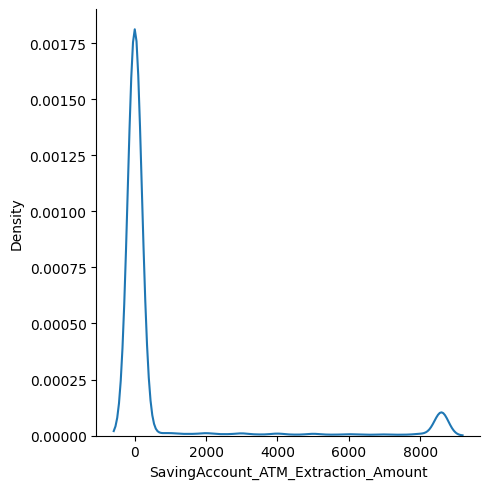

In [118]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_ATM_Extraction_Amount'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_CreditCard_Payment_Amount

In [119]:
p95 = training_window['SavingAccount_CreditCard_Payment_Amount'].quantile(0.95)
p99 = training_window['SavingAccount_CreditCard_Payment_Amount'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_CreditCard_Payment_Amount'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          11868.3125
p99          33823.049999999756
Three sigma  31971.212947940097


In [120]:
training_window['SavingAccount_CreditCard_Payment_Amount'] = np.where(training_window['SavingAccount_CreditCard_Payment_Amount'] > three_sigma, 
                                                          three_sigma,
                                                         training_window['SavingAccount_CreditCard_Payment_Amount'])

training_window['SavingAccount_CreditCard_Payment_Amount'].describe()

count    139146.000000
mean       1840.757643
std        5226.661125
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       31971.212948
Name: SavingAccount_CreditCard_Payment_Amount, dtype: float64

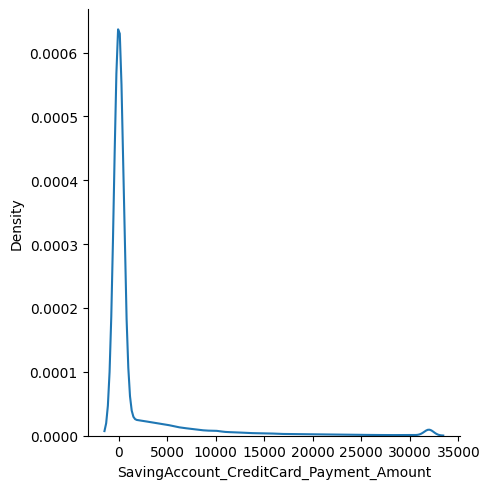

In [121]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_CreditCard_Payment_Amount'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Transfer_Out_Amount

In [122]:
p95 = training_window['SavingAccount_Transfer_Out_Amount'].quantile(0.95)
p99 = training_window['SavingAccount_Transfer_Out_Amount'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Transfer_Out_Amount'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          0.0
p99          21453.013999999937
Three sigma  47523.41379065669


In [123]:
training_window['SavingAccount_Transfer_Out_Amount'] = np.where(training_window['SavingAccount_Transfer_Out_Amount'] > p99, 
                                                          p99,
                                                         training_window['SavingAccount_Transfer_Out_Amount'])

training_window['SavingAccount_Transfer_Out_Amount'].describe()

count    139146.000000
mean        451.299070
std        2652.509583
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       21453.014000
Name: SavingAccount_Transfer_Out_Amount, dtype: float64

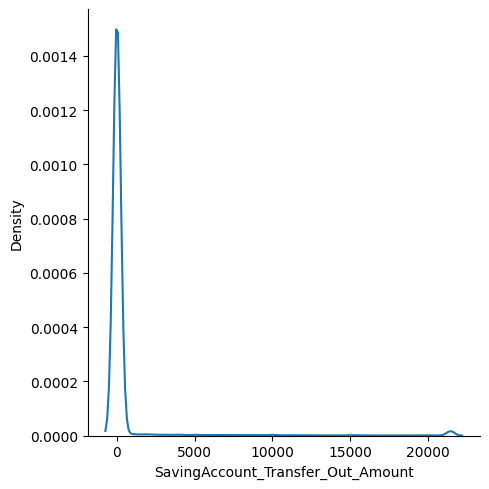

In [124]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Transfer_Out_Amount'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_DebitCard_Spend_Amount

In [125]:
p95 = training_window['SavingAccount_DebitCard_Spend_Amount'].quantile(0.95)
p99 = training_window['SavingAccount_DebitCard_Spend_Amount'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_DebitCard_Spend_Amount'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          6350.3125
p99          20862.84349999993
Three sigma  13168.561377041347


In [126]:
training_window['SavingAccount_DebitCard_Spend_Amount'] = np.where(training_window['SavingAccount_DebitCard_Spend_Amount'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_DebitCard_Spend_Amount'])

training_window['SavingAccount_DebitCard_Spend_Amount'].describe()

count    139146.000000
mean        504.030718
std        1567.015956
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        6350.312500
Name: SavingAccount_DebitCard_Spend_Amount, dtype: float64

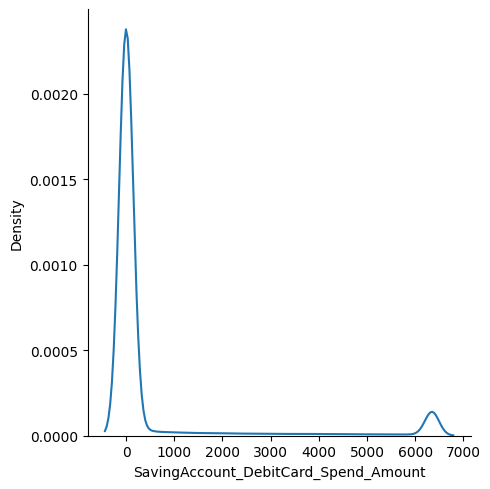

In [127]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_DebitCard_Spend_Amount'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Total_Amount

In [128]:
p95 = training_window['SavingAccount_Total_Amount'].quantile(0.95)
p99 = training_window['SavingAccount_Total_Amount'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Total_Amount'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          109939.47
p99          527795.7179999923
Three sigma  536040.4438446803


In [129]:
training_window['SavingAccount_Total_Amount'] = np.where(training_window['SavingAccount_Total_Amount'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_Total_Amount'])

training_window['SavingAccount_Total_Amount'].describe()

count    139146.000000
mean      15375.232616
std       29201.571404
min           0.000000
25%           0.000000
50%           0.000000
75%       14466.357500
max      109939.470000
Name: SavingAccount_Total_Amount, dtype: float64

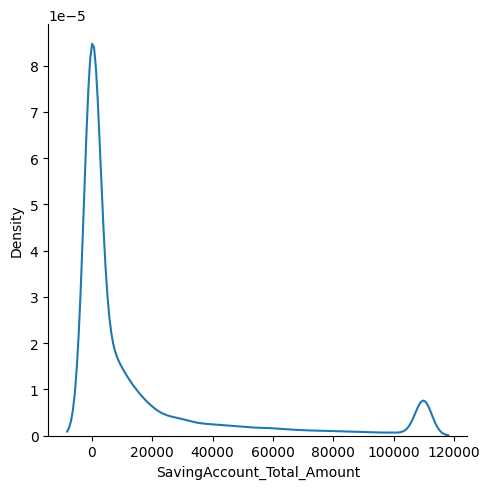

In [130]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Total_Amount'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: SavingAccount_Credits_Amounts

In [131]:
p95 = training_window['SavingAccount_Credits_Amounts'].quantile(0.95)
p99 = training_window['SavingAccount_Credits_Amounts'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Credits_Amounts'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          54835.455
p99          269663.80649999913
Three sigma  271204.21506443416


In [132]:
training_window['SavingAccount_Credits_Amounts'] = np.where(training_window['SavingAccount_Credits_Amounts'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_Credits_Amounts'])

training_window['SavingAccount_Credits_Amounts'].describe()

count    139146.000000
mean       7558.049240
std       14577.499232
min           0.000000
25%           0.000000
50%           0.000000
75%        7000.250000
max       54835.455000
Name: SavingAccount_Credits_Amounts, dtype: float64

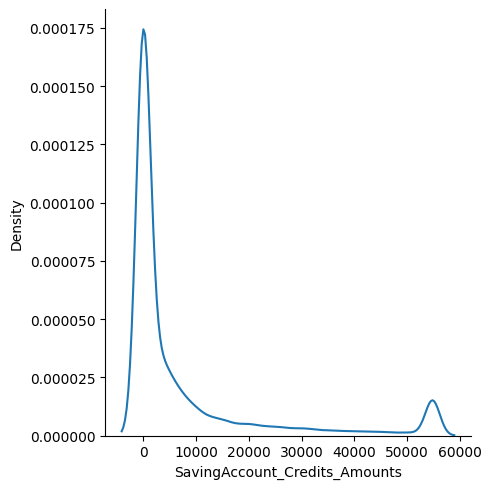

In [133]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Credits_Amounts'], kind='kde')

# display the plot
plt.show()

In [134]:
## quitando outliers Variable: SavingAccount_Debits_Amounts

In [135]:
p95 = training_window['SavingAccount_Debits_Amounts'].quantile(0.95)
p99 = training_window['SavingAccount_Debits_Amounts'].quantile(0.99)
three_sigma = 3 * training_window['SavingAccount_Debits_Amounts'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          54108.784999999996
p99          268277.130499996
Three sigma  269760.6696250981


In [136]:
training_window['SavingAccount_Debits_Amounts'] = np.where(training_window['SavingAccount_Debits_Amounts'] > p95, 
                                                          p95,
                                                         training_window['SavingAccount_Debits_Amounts'])

training_window['SavingAccount_Debits_Amounts'].describe()

count    139146.000000
mean       7539.658027
std       14341.236934
min           0.000000
25%           0.000000
50%           0.000000
75%        7102.057500
max       54108.785000
Name: SavingAccount_Debits_Amounts, dtype: float64

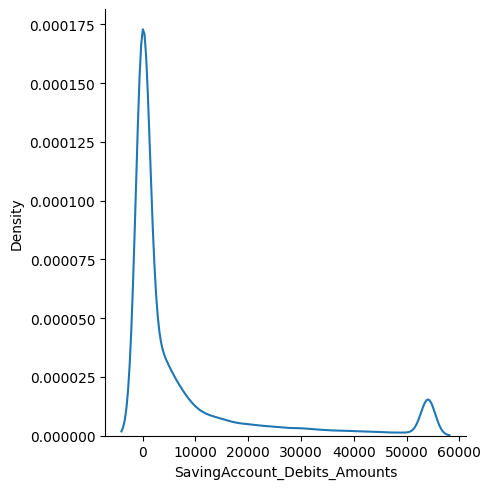

In [137]:
# plot a distribution plot
sns.displot(training_window['SavingAccount_Debits_Amounts'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: Operations_HomeBanking

In [138]:
p95 = training_window['Operations_HomeBanking'].quantile(0.95)
p99 = training_window['Operations_HomeBanking'].quantile(0.99)
three_sigma = 3 * training_window['Operations_HomeBanking'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          7.0
p99          15.0
Three sigma  8.928026498997632


In [139]:
training_window['Operations_HomeBanking'] = np.where(training_window['Operations_HomeBanking'] > p99, 
                                                          p99,
                                                         training_window['Operations_HomeBanking'])

training_window['Operations_HomeBanking'].describe()

count    139146.000000
mean          1.213186
std           2.761946
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: Operations_HomeBanking, dtype: float64

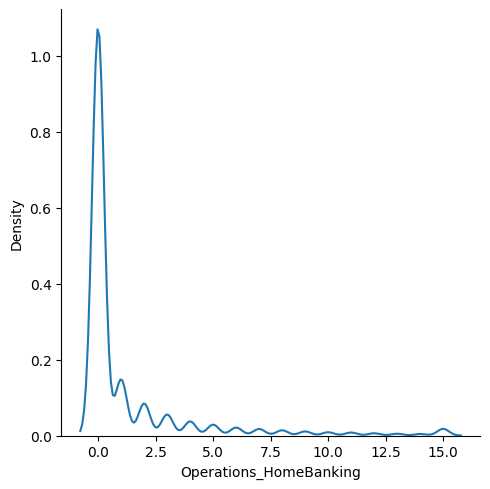

In [140]:
# plot a distribution plot
sns.displot(training_window['Operations_HomeBanking'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: Operations_Mobile

In [141]:
p95 = training_window['Operations_Mobile'].quantile(0.95)
p99 = training_window['Operations_Mobile'].quantile(0.99)
three_sigma = 3 * training_window['Operations_Mobile'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          5.0
p99          14.0
Three sigma  7.72057758014084


In [142]:
training_window['Operations_Mobile'] = np.where(training_window['Operations_Mobile'] > p99, 
                                                          p99,
                                                         training_window['Operations_Mobile'])

training_window['Operations_Mobile'].describe()

count    139146.000000
mean          0.624617
std           2.277957
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.000000
Name: Operations_Mobile, dtype: float64

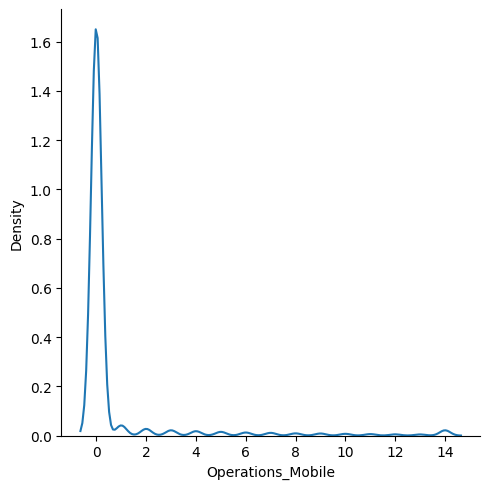

In [143]:
# plot a distribution plot
sns.displot(training_window['Operations_Mobile'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: CreditCard_Balance_ARG

In [144]:
p95 = training_window['CreditCard_Balance_ARG'].quantile(0.95)
p99 = training_window['CreditCard_Balance_ARG'].quantile(0.99)
np99 = -training_window['CreditCard_Balance_ARG'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Balance_ARG'].std()

print('p95         ', p95)
print('p99         ', p99)
print('np99         ', np99)
print('Three sigma ', three_sigma)

p95          30815.11
p99          55138.89599999998
np99          -55138.89599999998
Three sigma  35962.00973574623


In [145]:
training_window['CreditCard_Balance_ARG'] = np.where(training_window['CreditCard_Balance_ARG'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Balance_ARG'])

training_window['CreditCard_Balance_ARG'] = np.where(training_window['CreditCard_Balance_ARG'] < np99, 
                                                          np99,
                                                         training_window['CreditCard_Balance_ARG'])

training_window['CreditCard_Balance_ARG'].describe()

count    139146.000000
mean       7084.210404
std       10832.826535
min      -55138.896000
25%           0.000000
50%        2716.210000
75%        9483.642500
max       55138.896000
Name: CreditCard_Balance_ARG, dtype: float64

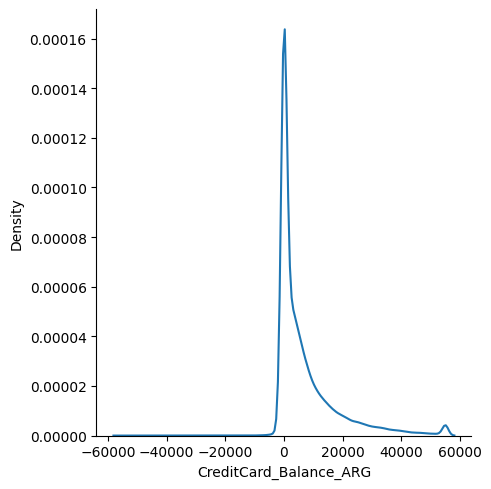

In [146]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Balance_ARG'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: CreditCard_Balance_DOLLAR

In [147]:
p95 = training_window['CreditCard_Balance_DOLLAR'].quantile(0.95)
p99 = training_window['CreditCard_Balance_DOLLAR'].quantile(0.99)
np99 = -training_window['CreditCard_Balance_DOLLAR'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Balance_DOLLAR'].std()

print('p95         ', p95)
print('p99         ', p99)
print('np99         ', np99)
print('Three sigma ', three_sigma)

p95          0.99
p99          132.93649999999963
np99          -132.93649999999963
Three sigma  200.20502558797813


In [148]:
training_window['CreditCard_Balance_DOLLAR'] = np.where(training_window['CreditCard_Balance_DOLLAR'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Balance_DOLLAR'])

training_window['CreditCard_Balance_DOLLAR'] = np.where(training_window['CreditCard_Balance_DOLLAR'] < np99, 
                                                          np99,
                                                         training_window['CreditCard_Balance_DOLLAR'])

training_window['CreditCard_Balance_DOLLAR'].describe()

count    139146.000000
mean          2.161760
std          15.995588
min        -132.936500
25%           0.000000
50%           0.000000
75%           0.000000
max         132.936500
Name: CreditCard_Balance_DOLLAR, dtype: float64

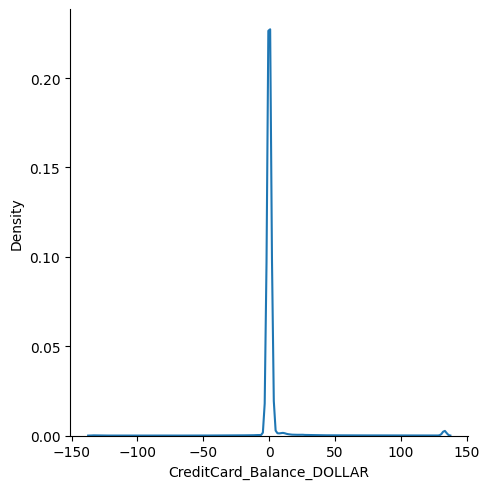

In [149]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Balance_DOLLAR'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: CreditCard_Total_Limit

In [150]:
p95 = training_window['CreditCard_Total_Limit'].quantile(0.95)
p99 = training_window['CreditCard_Total_Limit'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Total_Limit'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          160000.0
p99          280000.0
Three sigma  184838.11811993475


In [151]:
training_window['CreditCard_Total_Limit'] = np.where(training_window['CreditCard_Total_Limit'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Total_Limit'])

training_window['CreditCard_Total_Limit'].describe()

count    139146.000000
mean      51060.982709
std       56753.331259
min           0.000000
25%           0.000000
50%       40000.000000
75%       64000.000000
max      280000.000000
Name: CreditCard_Total_Limit, dtype: float64

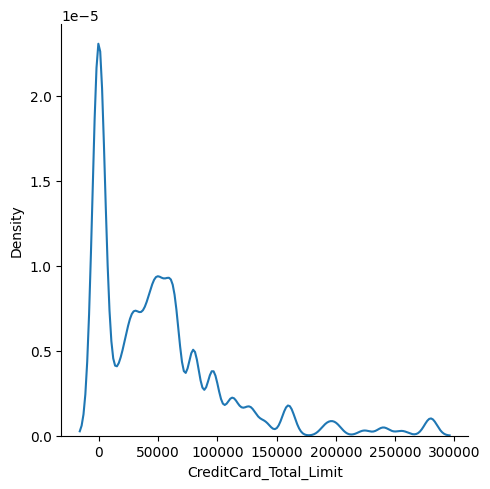

In [152]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Total_Limit'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: CreditCard_Total_Spending

In [153]:
p95 = training_window['CreditCard_Total_Spending'].quantile(0.95)
p99 = training_window['CreditCard_Total_Spending'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Total_Spending'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          17131.6725
p99          33148.23549999999
Three sigma  21870.01520929554


In [154]:
training_window['CreditCard_Total_Spending'] = np.where(training_window['CreditCard_Total_Spending'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Total_Spending'])

training_window['CreditCard_Total_Spending'].describe()

count    139146.000000
mean       4076.655867
std        6249.673704
min      -30164.770000
25%           0.000000
50%        1482.710000
75%        5656.147500
max       33148.235500
Name: CreditCard_Total_Spending, dtype: float64

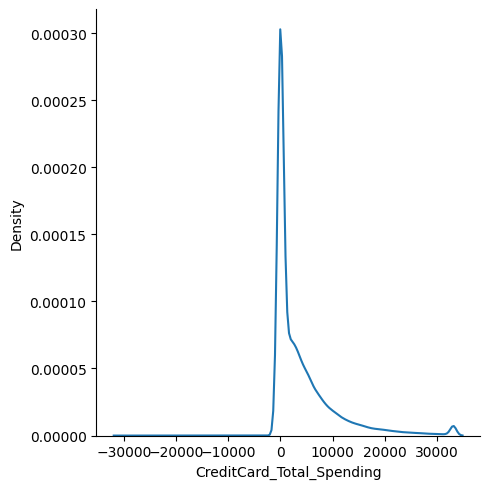

In [155]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Total_Spending'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: CreditCard_Spending_1_Installment

In [156]:
p95 = training_window['CreditCard_Spending_1_Installment'].quantile(0.95)
p99 = training_window['CreditCard_Spending_1_Installment'].quantile(0.99)
np99 = -training_window['CreditCard_Spending_1_Installment'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Spending_1_Installment'].std()

print('p95         ', p95)
print('p99         ', p99)
print('np99         ', np99)
print('Three sigma ', three_sigma)

p95          7739.59
p99          19681.75649999997
np99          -19681.75649999997
Three sigma  12897.110532905726


In [157]:
training_window['CreditCard_Spending_1_Installment'] = np.where(training_window['CreditCard_Spending_1_Installment'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Spending_1_Installment'])

training_window['CreditCard_Spending_1_Installment'] = np.where(training_window['CreditCard_Spending_1_Installment'] < np99, 
                                                          np99,
                                                         training_window['CreditCard_Spending_1_Installment'])

training_window['CreditCard_Spending_1_Installment'].describe()

count    139146.000000
mean       1268.888989
std        3255.660124
min      -19681.756500
25%           0.000000
50%           0.000000
75%         656.180000
max       19681.756500
Name: CreditCard_Spending_1_Installment, dtype: float64

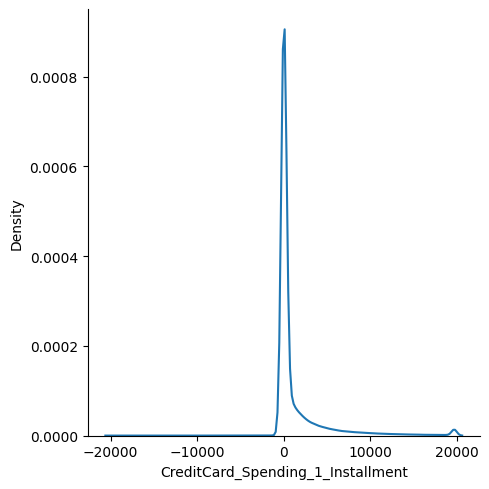

In [158]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Spending_1_Installment'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: CreditCard_Spending_CrossBoarder

In [159]:
p95 = training_window['CreditCard_Spending_CrossBoarder'].quantile(0.95)
p99 = training_window['CreditCard_Spending_CrossBoarder'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Spending_CrossBoarder'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          0.99
p99          143.6204999999987
Three sigma  212.90138519851982


In [160]:
training_window['CreditCard_Spending_CrossBoarder'] = np.where(training_window['CreditCard_Spending_CrossBoarder'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Spending_CrossBoarder'])

training_window['CreditCard_Spending_CrossBoarder'].describe()

count    139146.000000
mean          2.589213
std          16.595921
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         143.620500
Name: CreditCard_Spending_CrossBoarder, dtype: float64

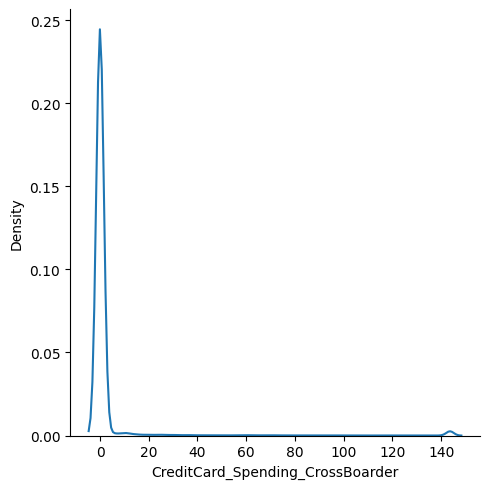

In [161]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Spending_CrossBoarder'], kind='kde')

# display the plot
plt.show()

## quitando outliers Variable: CreditCard_Spending_Aut_Debits

In [162]:
p95 = training_window['CreditCard_Spending_Aut_Debits'].quantile(0.95)
p99 = training_window['CreditCard_Spending_Aut_Debits'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Spending_Aut_Debits'].std()

print('p95         ', p95)
print('p99         ', p99)
print('Three sigma ', three_sigma)

p95          5619.7275
p99          12510.912499999991
Three sigma  7806.871328247001


In [163]:
training_window['CreditCard_Spending_Aut_Debits'] = np.where(training_window['CreditCard_Spending_Aut_Debits'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Spending_Aut_Debits'])

training_window['CreditCard_Spending_Aut_Debits'].describe()

count    139146.000000
mean       1033.300702
std        2209.574033
min       -9476.360000
25%           0.000000
50%           0.000000
75%         947.745000
max       12510.912500
Name: CreditCard_Spending_Aut_Debits, dtype: float64

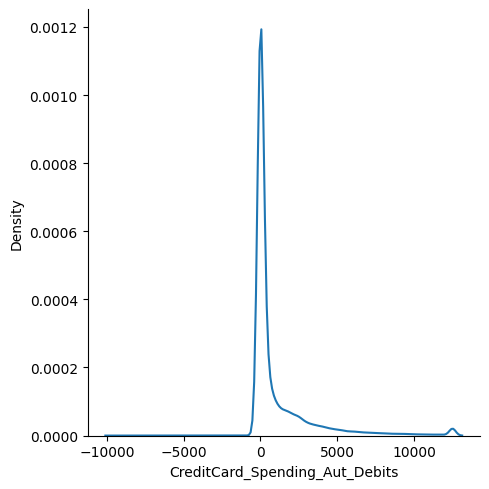

In [164]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Spending_Aut_Debits'], kind='kde')

# display the plot
plt.show()

In [165]:
## quitando outliers Variable: CreditCard_Revolving

In [166]:
p95 = training_window['CreditCard_Revolving'].quantile(0.95)
p99 = training_window['CreditCard_Revolving'].quantile(0.99)
np99 = -training_window['CreditCard_Revolving'].quantile(0.99)
three_sigma = 3 * training_window['CreditCard_Revolving'].std()

print('p95         ', p95)
print('p99         ', p99)
print('np99         ', np99)
print('Three sigma ', three_sigma)

p95          17291.8975
p99          36175.25699999951
np99          -36175.25699999951
Three sigma  23840.512630865414


In [167]:
training_window['CreditCard_Revolving'] = np.where(training_window['CreditCard_Revolving'] > p99, 
                                                          p99,
                                                         training_window['CreditCard_Revolving'])

training_window['CreditCard_Revolving'] = np.where(training_window['CreditCard_Revolving'] < np99, 
                                                          np99,
                                                         training_window['CreditCard_Revolving'])
training_window['CreditCard_Revolving'].describe()

count    139146.000000
mean       2040.762848
std        6810.370574
min      -36175.257000
25%           0.000000
50%           0.000000
75%           0.000000
max       36175.257000
Name: CreditCard_Revolving, dtype: float64

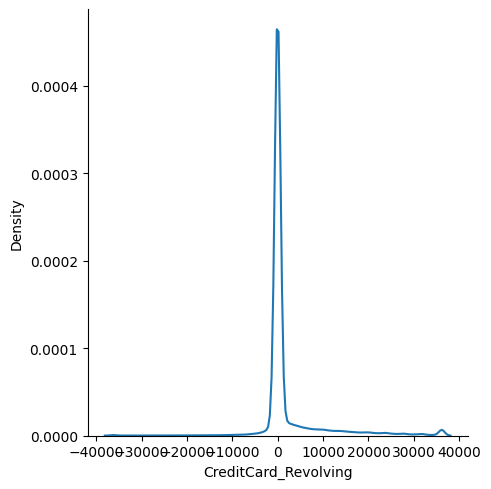

In [168]:
# plot a distribution plot
sns.displot(training_window['CreditCard_Revolving'], kind='kde')

# display the plot
plt.show()

# Transform Features

In [169]:
training_window

client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

       CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                      No               Yes                    No          No   
1                      No                No                    No          No   
2                      No                No                    No          No   
3                      No               Yes                    No          No   
4                      No                No                    No          No   
...                   ...               ...                   ...         ...   
139141                 No               Yes                    No          No   
139142                 No               Yes                    No          No   
139143                 No               Yes                    No          No   
139144                 No                No                    No          No   
139145                 No                No                    No         Yes   

       Mortgage_Active  ... CreditCard_Payment_Web CreditCard_Payment_ATM  \
0                   No  ...                    0.0                    0.0   
1                   No  ...                    0.0                    0.0   
2                   No  ...                    0.0                    0.0   
3                   No  ...                    0.0                    0.0   
4                   No  ...                    0.0                    0.0   
...                ...  ...                    ...                    ...   
139141              No  ...                    1.0                    0.0   
139142              No  ...                    1.0                    0.0   
139143              No  ...                    0.0                    0.0   
139144              No  ...                    0.0                    0.0   
139145              No  ...                    0.0                    0.0   

       CreditCard_Payment_TAS Investment_Numbers Mobile Email  \
0                         0.0                1.0    Yes   Yes   
1                         0.0                0.0    Yes    No   
2                         0.0                0.0    Yes   Yes   
3                         0.0                0.0    Yes   Yes   
4                         0.0                0.0    Yes    No   
...                       ...                ...    ...   ...   
139141                    0.0                0.0     No   Yes   
139142                    0.0                0.0    Yes   Yes   
139143                    1.0                0.0    Yes    No   
139144                    0.0                0.0    Yes   Yes   
139145                    0.0                0.0    Yes    No   

                               Region CreditCard_Product cantidad_meses  TGT  
0                          AMBA Resto     J55660202XX012              9  1.0  
1                       REGION CENTRO                 No              9  0.0  
2       REGION NORTE GRANDE ARGENTINO                 No              9  0.0  
3                         REGION CUYO     J55660202XX012              9  0.0  
4                       REGION CENTRO        

### variables con valores (Yes/No), (M/F) y las edades

In [170]:
columnas = ['CreditCard_Premium','CreditCard_Active','CreditCard_CoBranding','Loan_Active',
            'Mortgage_Active', 'SavingAccount_Active_ARG_Salary','SavingAccount_Active_ARG','SavingAccount_Active_DOLLAR'
           ,'DebitCard_Active','Investment_Active','Package_Active','Insurance_Life'
           ,'Insurance_Home','Insurance_Accidents','Insurance_Mobile','Insurance_ATM','Insurance_Unemployment','Mobile','Email']

for columna in columnas:
    training_window[columna] = np.where(training_window[columna] == 'Yes',1,0)
#----------    

training_window['Sex'] = np.where(training_window['Sex'] == 'F', 0, 1)

#---------------

di = { 
 "Entre 40 y 49 años"          : 40,
 "Entre 30 y 39 años"                 : 30,
    "Entre 50 y 59 años"                 : 50,
    "Entre 60 y 64 años"                 : 60,
    "Entre 65 y 69 años"                 : 65,
    "Entre 18 y 29 años"                 : 18,
    "Mayor a 70 años"                 : 70,
    "Menor a 18 años"                 : 17,
 }
training_window.Client_Age_grp = training_window.Client_Age_grp.map(di)


In [171]:
training_window['Client_Age_grp'].value_counts()

Client_Age_grp
40    38313
30    34063
50    30588
60    12282
65     9685
18     7509
70     6701
17        5
Name: count, dtype: int64

In [172]:
training_window

client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

        CreditCard_Premium  CreditCard_Active  CreditCard_CoBranding  \
0                        0                  1                      0   
1                        0                  0                      0   
2                        0                  0                      0   
3                        0                  1                      0   
4                        0                  0                      0   
...                    ...                ...                    ...   
139141                   0                  1                      0   
139142                   0                  1                      0   
139143                   0                  1                      0   
139144                   0                  0                      0   
139145                   0                  0                      0   

        Loan_Active  Mortgage_Active  ...  CreditCard_Payment_Web  \
0                 0                0  ...                     0.0   
1                 0                0  ...                     0.0   
2                 0                0  ...                     0.0   
3                 0                0  ...                     0.0   
4                 0                0  ...                     0.0   
...             ...              ...  ...                     ...   
139141            0                0  ...                     1.0   
139142            0                0  ...                     1.0   
139143            0                0  ...                     0.0   
139144            0                0  ...                     0.0   
139145            1                0  ...                     0.0   

        CreditCard_Payment_ATM  CreditCard_Payment_TAS  Investment_Numbers  \
0                          0.0                     0.0                 1.0   
1                          0.0                     0.0                 0.0   
2                          0.0                     0.0                 0.0   
3                          0.0                     0.0                 0.0   
4                          0.0                     0.0                 0.0   
...                        ...                     ...                 ...   
139141                     0.0                     0.0                 0.0   
139142                     0.0                     0.0                 0.0   
139143                     0.0                     1.0                 0.0   
139144                     0.0                     0.0                 0.0   
139145                     0.0                     0.0                 0.0   

        Mobile  Email                         Region  CreditCard_Product  \
0            1      1                     AMBA Resto      J55660202XX012   
1            1      0                  REGION CENTRO                  No   
2            1      1  REGION NORTE GRANDE ARGENTINO                  No   
3            1      1                    REGION CUYO      J55660202XX012   
4            1      0                  REGION CENTRO                  No   
...        ...    ...           

### One Hot Encoding en variable Region

In [173]:
training_window = pd.get_dummies(training_window, columns = ['Region'])

training_window

client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

        CreditCard_Premium  CreditCard_Active  CreditCard_CoBranding  \
0                        0                  1                      0   
1                        0                  0                      0   
2                        0                  0                      0   
3                        0                  1                      0   
4                        0                  0                      0   
...                    ...                ...                    ...   
139141                   0                  1                      0   
139142                   0                  1                      0   
139143                   0                  1                      0   
139144                   0                  0                      0   
139145                   0                  0                      0   

        Loan_Active  Mortgage_Active  ...  CreditCard_Product  cantidad_meses  \
0                 0                0  ...      J55660202XX012               9   
1                 0                0  ...                  No               9   
2                 0                0  ...                  No               9   
3                 0                0  ...      J55660202XX012               9   
4                 0                0  ...                  No               9   
...             ...              ...  ...                 ...             ...   
139141            0                0  ...      J55660104XX012               9   
139142            0                0  ...      J55660202XX012               9   
139143            0                0  ...      J55660202XX012               9   
139144            0                0  ...                  No               9   
139145            1                0  ...                  No               9   

        TGT  Region_AMBA Resto  Region_BUENOS AIRES  Region_CABA Centro/Norte  \
0       1.0               True                False                     False   
1       0.0              False                False                     False   
2       0.0              False                False                     False   
3       0.0              False                False                     False   
4       0.0              False                False                     False   
...     ...                ...                  ...                       ...   
139141  0.0              False                 True                     False   
139142  1.0              False                False                     False   
139143  1.0              False                False                     False   
139144  0.0              False                 True                     False   
139145  0.0              False                False                     False   

        Region_REGION CENTRO  Region_REGION CUYO  \
0                      False               False   
1                       True               False   
2                      False               False   
3                      False                True   
4                       True               False

In [174]:
columnas = ['Region_AMBA Resto','Region_BUENOS AIRES','Region_CABA Centro/Norte',
            'Region_REGION CENTRO', 'Region_REGION CUYO','Region_REGION NORTE GRANDE ARGENTINO','Region_REGION PATAGONICA']

for columna in columnas:
    training_window[columna] = np.where(training_window[columna] == True,1,0)
    
training_window    

client_id  Target       Month First_product_dt Last_product_dt  \
0         5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1         6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3          475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4         3615172     0.0  2018-09-01       2017-12-27      2017-12-28   
...           ...     ...         ...              ...             ...   
139141    1673642     0.0  2018-11-01       2017-08-18      2017-09-26   
139142    6145735     1.0  2018-11-01       2014-10-26      2014-10-26   
139143    5638786     1.0  2018-11-01       2012-12-26      2017-03-08   
139144    3824781     0.0  2018-08-01       2014-11-27      2019-01-04   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

        CreditCard_Premium  CreditCard_Active  CreditCard_CoBranding  \
0                        0                  1                      0   
1                        0                  0                      0   
2                        0                  0                      0   
3                        0                  1                      0   
4                        0                  0                      0   
...                    ...                ...                    ...   
139141                   0                  1                      0   
139142                   0                  1                      0   
139143                   0                  1                      0   
139144                   0                  0                      0   
139145                   0                  0                      0   

        Loan_Active  Mortgage_Active  ...  CreditCard_Product  cantidad_meses  \
0                 0                0  ...      J55660202XX012               9   
1                 0                0  ...                  No               9   
2                 0                0  ...                  No               9   
3                 0                0  ...      J55660202XX012               9   
4                 0                0  ...                  No               9   
...             ...              ...  ...                 ...             ...   
139141            0                0  ...      J55660104XX012               9   
139142            0                0  ...      J55660202XX012               9   
139143            0                0  ...      J55660202XX012               9   
139144            0                0  ...                  No               9   
139145            1                0  ...                  No               9   

        TGT  Region_AMBA Resto  Region_BUENOS AIRES  Region_CABA Centro/Norte  \
0       1.0                  1                    0                         0   
1       0.0                  0                    0                         0   
2       0.0                  0                    0                         0   
3       0.0                  0                    0                         0   
4       0.0                  0                    0                         0   
...     ...                ...                  ...                       ...   
139141  0.0                  0                    1                         0   
139142  1.0                  0                    0                         0   
139143  1.0                  0                    0                         0   
139144  0.0                  0                    1                         0   
139145  0.0                  0                    0                         0   

        Region_REGION CENTRO  Region_REGION CUYO  \
0                          0                   0   
1                          1                   0   
2                          0                   0   
3                          0                   1   
4                          1                   0

### Identity Features to ABT

In [175]:
training_window.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139146 entries, 0 to 139145
Data columns (total 85 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   client_id                                      139146 non-null  int32  
 1   Target                                         139146 non-null  float64
 2   Month                                          139146 non-null  object 
 3   First_product_dt                               139146 non-null  object 
 4   Last_product_dt                                139146 non-null  object 
 5   CreditCard_Premium                             139146 non-null  int32  
 6   CreditCard_Active                              139146 non-null  int32  
 7   CreditCard_CoBranding                          139146 non-null  int32  
 8   Loan_Active                                    139146 non-null  int32  
 9   Mortgage_Active                      

In [176]:
identity_features = training_window[training_window.Month == '2019-01-01'][['client_id',
                                                                             'Target',
                                                                             'Month',
                                                                             'First_product_dt',
                                                                             'Last_product_dt',
                                                                             'CreditCard_Premium',
                                                                             'CreditCard_Active',
                                                                             'Loan_Active',
                                                                             'Mortgage_Active',
                                                                             'DebitCard_Active',
                                                                             'Investment_Active',
                                                                             'Sex',
                                                                             'Client_Age_grp',
                                                                             'Mobile',
                                                                             'Email',
                                                                             'CreditCard_Product',
                                                                             'Region_AMBA Resto',
                                                                             'Region_BUENOS AIRES',
                                                                             'Region_CABA Centro/Norte',
                                                                             'Region_REGION CENTRO',
                                                                             'Region_REGION CUYO',
                                                                             'Region_REGION NORTE GRANDE ARGENTINO',
                                                                             'Region_REGION PATAGONICA',
                                                                             'SavingAccount_Active_ARG_Salary',
                                                                             'SavingAccount_Active_ARG',
                                                                             'SavingAccount_Active_DOLLAR',
                                                                             'SavingAccount_Days_with_Credits',
                               'SavingAccount_Days_with_Debits',
                               'SavingAccount_Salary_Payment_Transactions',
                               'SavingAccount_Transfer_In_Transactions',
                               'SavingAccount_ATM_Extraction_Transactions',
                               'SavingAccount_CreditCard_Payment_Transactions',
                               'SavingAccount_Transfer_Out_Transactions',
                               'SavingAccount_DebitCard_Spend_Transactions',
                               'SavingAccount_Transactions_Transactions',
                               'SavingAccount_Credits_Transactions',
                               'SavingAccount_Debits_Transactions',
                               'SavingAccount_Salary_Payment_Amount',
                               'SavingAccount_Transfer_In_Amount',
                               'SavingAccount_ATM_Extraction_Amount',
                               'SavingAccount_CreditCard_Payment_Amount',
                               'SavingAccount_Transfer_Out_Amount',
                               'SavingAccount_DebitCard_Spend_Amount',
                               'SavingAccount_Total_Amount',
                               'SavingAccount_Credits_Amounts',
                               'SavingAccount_Debits_Amounts',
                               'Operations_HomeBanking',
                               'Operations_Mobile',
                               'CreditCard_Balance_ARG',
                               'CreditCard_Balance_DOLLAR',
                               'CreditCard_Total_Limit',
                               'CreditCard_Total_Spending',
                               'CreditCard_Spending_1_Installment',
                               'CreditCard_Spending_CrossBoarder',
                               'CreditCard_Spending_Aut_Debits',
                               'CreditCard_Revolving',
                                'TGT']].copy()

identity_features

client_id  Target       Month First_product_dt Last_product_dt  \
2         5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
8         6018047     1.0  2019-01-01       2014-04-29      2017-05-31   
9         5359038     1.0  2019-01-01       2016-01-07      2017-05-24   
11        6890812     0.0  2019-01-01       2017-06-09      2018-08-27   
13         115383     0.0  2019-01-01       2004-07-30      2004-07-30   
...           ...     ...         ...              ...             ...   
139131    6570413     0.0  2019-01-01       2015-12-04      2018-11-02   
139132    6258895     0.0  2019-01-01       2015-03-12      2018-03-02   
139138    6397274     0.0  2019-01-01       2015-06-23      2015-06-23   
139139    6007291     0.0  2019-01-01       2014-04-13      2014-04-13   
139145    6412619     0.0  2019-01-01       2015-07-08      2018-06-02   

        CreditCard_Premium  CreditCard_Active  Loan_Active  Mortgage_Active  \
2                        0                  0            0                0   
8                        1                  1            0                0   
9                        1                  1            1                0   
11                       0                  0            1                0   
13                       0                  0            0                0   
...                    ...                ...          ...              ...   
139131                   0                  1            0                0   
139132                   0                  0            0                0   
139138                   0                  1            0                0   
139139                   1                  1            0                0   
139145                   0                  0            1                0   

        DebitCard_Active  ...  Operations_Mobile  CreditCard_Balance_ARG  \
2                      1  ...                0.0                    0.00   
8                      1  ...                0.0                16397.20   
9                      1  ...                0.0                 6906.73   
11                     1  ...                0.0                    0.00   
13                     0  ...                0.0                    0.00   
...                  ...  ...                ...                     ...   
139131                 1  ...                1.0                  537.43   
139132                 1  ...                0.0                    0.00   
139138                 0  ...                0.0                 1475.18   
139139                 0  ...                0.0                33148.43   
139145                 1  ...                0.0                    0.00   

        CreditCard_Balance_DOLLAR  CreditCard_Total_Limit  \
2                            0.00                     0.0   
8                            0.00                 80000.0   
9                           33.67                 64000.0   
11                           0.00                     0.0   
13                           0.00                     0.0   
...                           ...                     ...   
139131                       0.00                 28000.0   
139132                       0.00                     0.0   
139138                       0.00                 40000.0   
139139                       0.00                 96000.0   
139145                       0.00                     0.0   

        CreditCard_Total_Spending CreditCard_Spending_1_Installment  \
2                            0.00                              0.00   
8                        16068.08                           1000.00   
9                         6919.64                           1840.00   
11                           0.00                              0.00   
13                           0.00                              0.00   
...                           ...                               ...   
139131                     

### Tratamiento de variables con fechas

In [177]:
dateColumns = ['Month','First_product_dt','Last_product_dt']

identity_features.drop(columns=dateColumns, inplace=True)

identity_features

client_id  Target  CreditCard_Premium  CreditCard_Active  Loan_Active  \
2         5928737     0.0                   0                  0            0   
8         6018047     1.0                   1                  1            0   
9         5359038     1.0                   1                  1            1   
11        6890812     0.0                   0                  0            1   
13         115383     0.0                   0                  0            0   
...           ...     ...                 ...                ...          ...   
139131    6570413     0.0                   0                  1            0   
139132    6258895     0.0                   0                  0            0   
139138    6397274     0.0                   0                  1            0   
139139    6007291     0.0                   1                  1            0   
139145    6412619     0.0                   0                  0            1   

        Mortgage_Active  DebitCard_Active  Investment_Active  Sex  \
2                     0                 1                  0    1   
8                     0                 1                  0    1   
9                     0                 1                  0    1   
11                    0                 1                  0    1   
13                    0                 0                  0    1   
...                 ...               ...                ...  ...   
139131                0                 1                  0    0   
139132                0                 1                  0    0   
139138                0                 0                  0    1   
139139                0                 0                  0    0   
139145                0                 1                  0    0   

        Client_Age_grp  ...  Operations_Mobile  CreditCard_Balance_ARG  \
2                   30  ...                0.0                    0.00   
8                   60  ...                0.0                16397.20   
9                   40  ...                0.0                 6906.73   
11                  40  ...                0.0                    0.00   
13                  70  ...                0.0                    0.00   
...                ...  ...                ...                     ...   
139131              30  ...                1.0                  537.43   
139132              30  ...                0.0                    0.00   
139138              40  ...                0.0                 1475.18   
139139              40  ...                0.0                33148.43   
139145              60  ...                0.0                    0.00   

       CreditCard_Balance_DOLLAR  CreditCard_Total_Limit  \
2                           0.00                     0.0   
8                           0.00                 80000.0   
9                          33.67                 64000.0   
11                          0.00                     0.0   
13                          0.00                     0.0   
...                          ...                     ...   
139131                      0.00                 28000.0   
139132                      0.00                     0.0   
139138                      0.00                 40000.0   
139139                      0.00                 96000.0   
139145                      0.00                     0.0   

        CreditCard_Total_Spending  CreditCard_Spending_1_Installment  \
2                            0.00                               0.00   
8                        16068.08                            1000.00   
9                         6919.64                            1840.00   
11                           0.00                               0.00   
13                           0.00                               0.00   
...                           ...                                ...   
139131                       0.00                               0.00   
139132              

### Transformar varible CreditCard_Product

In [178]:
identity_features.CreditCard_Product.value_counts()

CreditCard_Product
No                8426
J55660104XX012    8262
J55660202XX012    5759
J55660102XX012     402
J55660702XX012     249
J55661002XX012      62
J55660124XX012      30
J55660123XX012       1
Name: count, dtype: int64

In [179]:
CreditCard_Product_Transform = identity_features[['client_id','CreditCard_Product','TGT']].groupby('CreditCard_Product').agg(['sum',np.count_nonzero])
CreditCard_Product_Transform.columns = ['_'.join(x) for x in np.array(CreditCard_Product_Transform.columns)]

CreditCard_Product_Transform['Porcent_TGT'] = CreditCard_Product_Transform['TGT_sum']/CreditCard_Product_Transform['client_id_count_nonzero']

CreditCard_Product_Transform

client_id_sum  client_id_count_nonzero  TGT_sum  \
CreditCard_Product                                                    
J55660102XX012         1062656436                      402    138.0   
J55660104XX012        34506107357                     8262   3880.0   
J55660123XX012             994616                        1      0.0   
J55660124XX012          107695565                       30     11.0   
J55660202XX012        23762080087                     5759   2128.0   
J55660702XX012         1060543322                      249    108.0   
J55661002XX012          204312610                       62     40.0   
No                    40418495289                     8426    518.0   

                    TGT_count_nonzero  Porcent_TGT  
CreditCard_Product                                  
J55660102XX012                    138     0.343284  
J55660104XX012                   3880     0.469620  
J55660123XX012                      0     0.000000  
J55660124XX012                     11     0.366667  
J55660202XX012                   2128     0.369509  
J55660702XX012                    108     0.433735  
J55661002XX012                     40     0.645161  
No                                518     0.061476

In [180]:
di = { 
 "No"                     : 6,
 "J55660102XX012"         : 35,
 "J55660104XX012"         : 48,
 "J55660123XX012"         : 0,
 "J55660124XX012"         : 35,
 "J55660202XX012"         : 35,
 "J55660702XX012"         : 48,
 "J55661002XX012"         : 48,
 }
identity_features.CreditCard_Product = identity_features.CreditCard_Product.map(di)

identity_features.CreditCard_Product.value_counts()

CreditCard_Product
48    8573
6     8426
35    6191
0        1
Name: count, dtype: int64

### Aggregate Features to ABT

In [181]:
columns=[x for x in training_window if(x in ([                                             
                               'SavingAccount_Days_with_Credits',
                               'SavingAccount_Days_with_Debits',
                               'SavingAccount_Salary_Payment_Transactions',
                               'SavingAccount_Transfer_In_Transactions',
                               'SavingAccount_ATM_Extraction_Transactions',
                               'SavingAccount_CreditCard_Payment_Transactions',
                               'SavingAccount_Transfer_Out_Transactions',
                               'SavingAccount_DebitCard_Spend_Transactions',
                               'SavingAccount_Transactions_Transactions',
                               'SavingAccount_Credits_Transactions',
                               'SavingAccount_Debits_Transactions',
                               'SavingAccount_Salary_Payment_Amount',
                               'SavingAccount_Transfer_In_Amount',
                               'SavingAccount_ATM_Extraction_Amount',
                               'SavingAccount_CreditCard_Payment_Amount',
                               'SavingAccount_Transfer_Out_Amount',
                               'SavingAccount_DebitCard_Spend_Amount',
                               'SavingAccount_Total_Amount',
                               'SavingAccount_Credits_Amounts',
                               'SavingAccount_Debits_Amounts',
                               'Operations_HomeBanking',
                               'Operations_Mobile',
                               'CreditCard_Balance_ARG',
                               'CreditCard_Balance_DOLLAR',
                               'CreditCard_Total_Limit',
                               'CreditCard_Total_Spending',
                               'CreditCard_Spending_1_Installment',
                               'CreditCard_Spending_CrossBoarder',
                               'CreditCard_Spending_Aut_Debits',
                               'CreditCard_Revolving']))]
len(columns)


30

In [182]:
aggregateFeatures = training_window.groupby('client_id')[columns].agg(['sum','max','min', 'mean','nunique', np.count_nonzero,'var']).reset_index()
aggregateFeatures.columns = ['_'.join(x) for x in np.array(aggregateFeatures.columns)]

aggregateFeatures.rename(columns={'client_id_':'client_id'}, inplace=True)

In [183]:
aggregateFeatures

client_id  SavingAccount_Days_with_Credits_sum  \
0           1030                                 13.0   
1           1094                                  0.0   
2           1553                                  0.0   
3           1590                                  0.0   
4           1948                                  8.0   
...          ...                                  ...   
23186    7344944                                  7.0   
23187    7345011                                  8.0   
23188    7345026                                 15.0   
23189    7345029                                  6.0   
23190    7345492                                 10.0   

       SavingAccount_Days_with_Credits_max  \
0                                      3.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      2.0   
...                                    ...   
23186                                  5.0   
23187                                  5.0   
23188                                  5.0   
23189                                  3.0   
23190                                  5.0   

       SavingAccount_Days_with_Credits_min  \
0                                      1.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      1.0   
...                                    ...   
23186                                  0.0   
23187                                  0.0   
23188                                  0.0   
23189                                  0.0   
23190                                  0.0   

       SavingAccount_Days_with_Credits_mean  \
0                                  2.166667   
1                                  0.000000   
2                                  0.000000   
3                                  0.000000   
4                                  1.333333   
...                                     ...   
23186                              1.166667   
23187                              1.333333   
23188                              2.500000   
23189                              1.000000   
23190                              1.666667   

       SavingAccount_Days_with_Credits_nunique  \
0                                            3   
1                                            1   
2                                            1   
3                                            1   
4                                            2   
...                                        ...   
23186                                        3   
23187                                        3   
23188                                        2   
23189                                        2   
23190                                        4   

       SavingAccount_Days_with_Credits_count_nonzero  \
0                                                  6   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  6   
...                                              ...   
23186                                              2   
23187                                              2   
23188                                              3   
23189                                              2   
23190                                              3   

       SavingAccount_Days_with_Credits_var  \
0                                 0.566667   
1                                 0.000000   
2                                 0.000000   
3                                 0.000000   
4                                 0.266667   
...                                    ...   
23186                             4.166667   
23187    

In [184]:
Operations = training_window[['client_id','Operations_Bank','Operations_Terminal','Operations_HomeBanking',
                              'Operations_Mobile','Operations_Ivr','Operations_Telemarketer','Operations_ATM']]

Operations['TotalOperations'] = Operations['Operations_Bank'] + Operations['Operations_Terminal'] \
                                + Operations['Operations_HomeBanking'] + Operations['Operations_Mobile'] \
                                + Operations['Operations_Ivr'] + Operations['Operations_Telemarketer'] \
                                + Operations['Operations_ATM']



Operations_Aggregate = Operations.groupby('client_id').agg('sum').reset_index()

Operations_Aggregate['Porcent_Operations_HomeBanking'] = np.where(Operations_Aggregate['TotalOperations'] == 0,0,Operations_Aggregate['Operations_HomeBanking']/Operations_Aggregate['TotalOperations'])
Operations_Aggregate['Porcent_Operations_Mobile'] = np.where(Operations_Aggregate['TotalOperations'] == 0,0,Operations_Aggregate['Operations_Mobile']/Operations_Aggregate['TotalOperations'])

Operations_Aggregate

C:\Users\tutem\AppData\Local\Temp\ipykernel_30104\2919754844.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Operations['TotalOperations'] = Operations['Operations_Bank'] + Operations['Operations_Terminal'] \


client_id  Operations_Bank  Operations_Terminal  \
0           1030              0.0                  0.0   
1           1094              0.0                  0.0   
2           1553              0.0                  0.0   
3           1590              1.0                  0.0   
4           1948              0.0                  0.0   
...          ...              ...                  ...   
23186    7344944              0.0                  1.0   
23187    7345011              2.0                  1.0   
23188    7345026              2.0                  1.0   
23189    7345029              2.0                  1.0   
23190    7345492              2.0                  0.0   

       Operations_HomeBanking  Operations_Mobile  Operations_Ivr  \
0                         6.0                1.0             0.0   
1                         0.0                0.0             1.0   
2                         1.0                0.0             0.0   
3                         0.0                0.0             1.0   
4                         8.0                1.0             0.0   
...                       ...                ...             ...   
23186                     3.0               30.0             0.0   
23187                     1.0                3.0             0.0   
23188                     0.0                0.0             0.0   
23189                     0.0                0.0             0.0   
23190                    11.0               22.0             0.0   

       Operations_Telemarketer  Operations_ATM  TotalOperations  \
0                          1.0             0.0              8.0   
1                          0.0             0.0              1.0   
2                          0.0             0.0              1.0   
3                          0.0             0.0              2.0   
4                          0.0             0.0              9.0   
...                        ...             ...              ...   
23186                      0.0             8.0             42.0   
23187                      0.0             7.0             14.0   
23188                      0.0             2.0              5.0   
23189                      0.0             6.0              9.0   
23190                      0.0             0.0             35.0   

       Porcent_Operations_HomeBanking  Porcent_Operations_Mobile  
0                            0.750000                   0.125000  
1                            0.000000                   0.000000  
2                            1.000000                   0.000000  
3                            0.000000                   0.000000  
4                            0.888889                   0.111111  
...                               ...                        ...  
23186                        0.071429                   0.714286  
23187                        0.071429                   0.214286  
23188                        0.000000                   0.000000  
23189                        0.000000                   0.000000  
23190                        0.314286                   0.628571  

[23191 rows x 11 columns]

In [185]:
Insurances = training_window[['client_id','Insurance_Life','Insurance_Home','Insurance_Accidents',
                              'Insurance_Mobile','Insurance_ATM','Insurance_Unemployment']]

Insurances['TotalInsurances'] = Insurances['Insurance_Life'] + Insurances['Insurance_Home'] \
                                + Insurances['Insurance_Accidents'] + Insurances['Insurance_Mobile'] \
                                + Insurances['Insurance_ATM'] + Insurances['Insurance_Unemployment']



Insurances_Aggregate = Insurances.groupby('client_id').agg('sum').reset_index()

Insurances_Aggregate['Porcent_Total_Insurances'] = Insurances_Aggregate['TotalInsurances'] / 5
#Insurances_Aggregate = Insurances_Aggregate[['client_id','TotalInsurances','Porcent_Total_Insurances']]

Insurances_Aggregate


C:\Users\tutem\AppData\Local\Temp\ipykernel_30104\4288838385.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Insurances['TotalInsurances'] = Insurances['Insurance_Life'] + Insurances['Insurance_Home'] \


client_id  Insurance_Life  Insurance_Home  Insurance_Accidents  \
0           1030               0               0                    0   
1           1094               0               0                    0   
2           1553               0               0                    0   
3           1590               1               0                    1   
4           1948               0               1                    0   
...          ...             ...             ...                  ...   
23186    7344944               0               0                    0   
23187    7345011               0               0                    0   
23188    7345026               0               0                    0   
23189    7345029               0               0                    0   
23190    7345492               0               0                    0   

       Insurance_Mobile  Insurance_ATM  Insurance_Unemployment  \
0                     0              1                       0   
1                     0              0                       0   
2                     0              0                       0   
3                     0              0                       0   
4                     0              1                       0   
...                 ...            ...                     ...   
23186                 0              0                       0   
23187                 0              1                       0   
23188                 0              0                       0   
23189                 0              0                       0   
23190                 0              0                       0   

       TotalInsurances  Porcent_Total_Insurances  
0                    1                       0.2  
1                    0                       0.0  
2                    0                       0.0  
3                    2                       0.4  
4                    2                       0.4  
...                ...                       ...  
23186                0                       0.0  
23187                1                       0.2  
23188                0                       0.0  
23189                0                       0.0  
23190                0                       0.0  

[23191 rows x 9 columns]

# Create ABT

In [186]:
ABT = identity_features.merge(aggregateFeatures, how='inner', on='client_id')\
        .merge(Operations_Aggregate, how='inner', on='client_id')\
        .merge(Insurances_Aggregate, how='inner', on='client_id')
ABT.drop(columns=['Target'], inplace=True)
ABT

client_id  CreditCard_Premium  CreditCard_Active  Loan_Active  \
0        5928737                   0                  0            0   
1        6018047                   1                  1            0   
2        5359038                   1                  1            1   
3        6890812                   0                  0            1   
4         115383                   0                  0            0   
...          ...                 ...                ...          ...   
23186    6570413                   0                  1            0   
23187    6258895                   0                  0            0   
23188    6397274                   0                  1            0   
23189    6007291                   1                  1            0   
23190    6412619                   0                  0            1   

       Mortgage_Active  DebitCard_Active  Investment_Active  Sex  \
0                    0                 1                  0    1   
1                    0                 1                  0    1   
2                    0                 1                  0    1   
3                    0                 1                  0    1   
4                    0                 0                  0    1   
...                ...               ...                ...  ...   
23186                0                 1                  0    0   
23187                0                 1                  0    0   
23188                0                 0                  0    1   
23189                0                 0                  0    0   
23190                0                 1                  0    0   

       Client_Age_grp  Mobile  ...  Porcent_Operations_HomeBanking  \
0                  30       1  ...                        0.000000   
1                  60       1  ...                        0.727273   
2                  40       1  ...                        0.915663   
3                  40       1  ...                        0.972603   
4                  70       0  ...                        0.000000   
...               ...     ...  ...                             ...   
23186              30       1  ...                        0.300000   
23187              30       1  ...                        0.000000   
23188              40       0  ...                        0.000000   
23189              40       0  ...                        0.000000   
23190              60       1  ...                        0.000000   

       Porcent_Operations_Mobile  Insurance_Life  Insurance_Home  \
0                            0.0               0               0   
1                            0.0               0               0   
2                            0.0               0               0   
3                            0.0               1               0   
4                            0.0               0               0   
...                          ...             ...             ...   
23186                        0.2               0               0   
23187                        0.0               0               1   
23188                        0.0               1               0   
23189                        0.0               0               0   
23190                        0.0               1               1   

       Insurance_Accidents  Insurance_Mobile  Insurance_ATM  \
0                        0                 0              0   
1                        0                 0              0   
2                        0                 0              0   
3                        0                 0              0   
4                        0                 0              0   
...                    ...               ...            ...   
23186                    0                 0              0   
23187                    0                 0              0   
23188                    1                 0              0   
23189                    0           

# Dimensionality Reduction

#### Minimum = Maximum

In [187]:
ABT.describe()

client_id  CreditCard_Premium  CreditCard_Active   Loan_Active  \
count  2.319100e+04        23191.000000       23191.000000  23191.000000   
mean   4.360437e+06            0.115346           0.647794      0.127981   
std    2.144133e+06            0.319446           0.477668      0.334075   
min    1.030000e+03            0.000000           0.000000      0.000000   
25%    2.525100e+06            0.000000           0.000000      0.000000   
50%    4.991596e+06            0.000000           1.000000      0.000000   
75%    6.154208e+06            0.000000           1.000000      0.000000   
max    7.345492e+06            1.000000           1.000000      1.000000   

       Mortgage_Active  DebitCard_Active  Investment_Active           Sex  \
count     23191.000000      23191.000000       23191.000000  23191.000000   
mean          0.022379          0.669527           0.054763      0.573541   
std           0.147917          0.470394           0.227521      0.494573   
min           0.000000          0.000000           0.000000      0.000000   
25%           0.000000          0.000000           0.000000      0.000000   
50%           0.000000          1.000000           0.000000      1.000000   
75%           0.000000          1.000000           0.000000      1.000000   
max           1.000000          1.000000           1.000000      1.000000   

       Client_Age_grp        Mobile  ...  Porcent_Operations_HomeBanking  \
count    23191.000000  23191.000000  ...                    23191.000000   
mean        44.405459      0.881075  ...                        0.283736   
std         13.453333      0.323708  ...                        0.380932   
min         18.000000      0.000000  ...                        0.000000   
25%         30.000000      1.000000  ...                        0.000000   
50%         40.000000      1.000000  ...                        0.000000   
75%         50.000000      1.000000  ...                        0.619048   
max         70.000000      1.000000  ...                        1.000000   

       Porcent_Operations_Mobile  Insurance_Life  Insurance_Home  \
count               23191.000000    23191.000000    23191.000000   
mean                    0.078601        0.193437        0.145272   
std                     0.213620        0.395001        0.352382   
min                     0.000000        0.000000        0.000000   
25%                     0.000000        0.000000        0.000000   
50%                     0.000000        0.000000        0.000000   
75%                     0.000000        0.000000        0.000000   
max                     1.000000        1.000000        1.000000   

       Insurance_Accidents  Insurance_Mobile  Insurance_ATM  \
count         23191.000000      23191.000000   23191.000000   
mean              0.156268          0.076409       0.143978   
std               0.363117          0.265657       0.351075   
min               0.000000          0.000000       0.000000   
25%               0.000000          0.000000       0.000000   
50%               0.000000          0.000000       0.000000   
75%               0.000000          0.000000       0.000000   
max               1.000000          1.000000       1.000000   

       Insurance_Unemployment  TotalInsurances  Porcent_Total_Insurances  
count            23191.000000     23191.000000              23191.000000  
mean                 0.077918         0.793282                  0.158656  
std                  0.268049         1.174822                  0.234964  
min                  0.000000         0.000000                  0.000000  
25%                  0.000000         0.000000                  0.000000  
50%                  0.000000         0.000000                  0.000000  
75%                  0.000000         1.000000                  0.200000  
max                  1.000000         6.000000                  1.200000  

[8 rows x 281 columns]

In [188]:
x = pd.DataFrame(ABT.describe().T)
x.columns

delete = x[x['min']==x['max']].reset_index()

print('ABT min/max: ', ABT.shape)
ABT.drop(delete['index'], axis=1, inplace=True)
print('ABT: ', ABT.shape)

ABT min/max:  (23191, 281)
ABT:  (23191, 281)


## PCA

In [189]:
#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
cols = [x for x in ABT.columns if (x.startswith('CreditCard_Spending')) ]
print(cols)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(ABT[cols])

type(data_scaled)

['CreditCard_Spending_1_Installment', 'CreditCard_Spending_CrossBoarder', 'CreditCard_Spending_Aut_Debits', 'CreditCard_Spending_1_Installment_sum', 'CreditCard_Spending_1_Installment_max', 'CreditCard_Spending_1_Installment_min', 'CreditCard_Spending_1_Installment_mean', 'CreditCard_Spending_1_Installment_nunique', 'CreditCard_Spending_1_Installment_count_nonzero', 'CreditCard_Spending_1_Installment_var', 'CreditCard_Spending_CrossBoarder_sum', 'CreditCard_Spending_CrossBoarder_max', 'CreditCard_Spending_CrossBoarder_min', 'CreditCard_Spending_CrossBoarder_mean', 'CreditCard_Spending_CrossBoarder_nunique', 'CreditCard_Spending_CrossBoarder_count_nonzero', 'CreditCard_Spending_CrossBoarder_var', 'CreditCard_Spending_Aut_Debits_sum', 'CreditCard_Spending_Aut_Debits_max', 'CreditCard_Spending_Aut_Debits_min', 'CreditCard_Spending_Aut_Debits_mean', 'CreditCard_Spending_Aut_Debits_nunique', 'CreditCard_Spending_Aut_Debits_count_nonzero', 'CreditCard_Spending_Aut_Debits_var']


numpy.ndarray

In [190]:
data_scaled = pd.DataFrame(data_scaled, columns=ABT[cols].columns)

data_scaled.head(5)

CreditCard_Spending_1_Installment  CreditCard_Spending_CrossBoarder  \
0                          -0.404539                         -0.174669   
1                          -0.121738                         -0.174669   
2                           0.115814                          1.574087   
3                          -0.404539                         -0.174669   
4                          -0.404539                         -0.174669   

   CreditCard_Spending_Aut_Debits  CreditCard_Spending_1_Installment_sum  \
0                       -0.473121                              -0.482228   
1                        4.916441                               1.349612   
2                       -0.344315                              -0.178073   
3                       -0.473121                              -0.482228   
4                       -0.473121                              -0.482228   

   CreditCard_Spending_1_Installment_max  \
0                              -0.595466   
1                               2.198174   
2                              -0.230906   
3                              -0.595466   
4                              -0.595466   

   CreditCard_Spending_1_Installment_min  \
0                              -0.206982   
1                              -0.206982   
2                              -0.206982   
3                              -0.206982   
4                              -0.206982   

   CreditCard_Spending_1_Installment_mean  \
0                               -0.482228   
1                                1.349612   
2                               -0.178073   
3                               -0.482228   
4                               -0.482228   

   CreditCard_Spending_1_Installment_nunique  \
0                                  -0.857834   
1                                   1.619630   
2                                   1.619630   
3                                  -0.857834   
4                                  -0.857834   

   CreditCard_Spending_1_Installment_count_nonzero  \
0                                        -0.857969   
1                                         1.156892   
2                                         1.156892   
3                                        -0.857969   
4                                        -0.857969   

   CreditCard_Spending_1_Installment_var  ...  \
0                              -0.369477  ...   
1                               1.813086  ...   
2                              -0.333223  ...   
3                              -0.369477  ...   
4                              -0.369477  ...   

   CreditCard_Spending_CrossBoarder_nunique  \
0                                 -0.325674   
1                                 -0.325674   
2                                  1.156702   
3                                 -0.325674   
4                                 -0.325674   

   CreditCard_Spending_CrossBoarder_count_nonzero  \
0                                       -0.308900   
1                                       -0.308900   
2                                        0.664959   
3                                       -0.308900   
4                                       -0.308900   

   CreditCard_Spending_CrossBoarder_var  CreditCard_Spending_Aut_Debits_sum  \
0                             -0.248440                           -0.483256   
1                             -0.248440                            5.305475   
2                             -0.023213                           -0.366725   
3                             -0.248440                           -0.483256   
4                             -0.248440                           -0.483256   

   CreditCard_Spending_Aut_Debits_max  CreditCard_Spending_Aut_Debits_min  \
0                           -0.509510                           -0.427386   
1                            4.312784                            6.166697   
2                           -0.394261                           -0.427386   
3     

In [191]:
data_scaled.describe()

CreditCard_Spending_1_Installment  CreditCard_Spending_CrossBoarder  \
count                       2.319100e+04                      2.319100e+04   
mean                        5.361777e-18                     -5.943913e-17   
std                         1.000022e+00                      1.000022e+00   
min                        -5.970550e+00                     -1.746695e-01   
25%                        -4.045387e-01                     -1.746695e-01   
50%                        -4.045387e-01                     -1.746695e-01   
75%                        -1.798650e-01                     -1.746695e-01   
max                         5.161473e+00                      7.306930e+00   

       CreditCard_Spending_Aut_Debits  CreditCard_Spending_1_Installment_sum  \
count                    2.319100e+04                           2.319100e+04   
mean                     5.469013e-17                           5.208584e-17   
std                      1.000022e+00                           1.000022e+00   
min                     -4.555431e+00                          -7.962067e+00   
25%                     -4.731206e-01                          -4.822276e-01   
50%                     -4.731206e-01                          -4.631958e-01   
75%                     -4.200653e-02                           1.850608e-02   
max                      4.916441e+00                           6.997612e+00   

       CreditCard_Spending_1_Installment_max  \
count                           2.319100e+04   
mean                            2.083433e-17   
std                             1.000022e+00   
min                            -4.495013e+00   
25%                            -5.954658e-01   
50%                            -5.520753e-01   
75%                             1.678342e-01   
max                             3.304082e+00   

       CreditCard_Spending_1_Installment_min  \
count                           2.319100e+04   
mean                            2.451098e-17   
std                             1.000022e+00   
min                            -1.319936e+01   
25%                            -2.069816e-01   
50%                            -2.069816e-01   
75%                            -2.069816e-01   
max                             1.278540e+01   

       CreditCard_Spending_1_Installment_mean  \
count                            2.319100e+04   
mean                             4.166867e-17   
std                              1.000022e+00   
min                             -7.962067e+00   
25%                             -4.822276e-01   
50%                             -4.631958e-01   
75%                              1.850608e-02   
max                              6.997612e+00   

       CreditCard_Spending_1_Installment_nunique  \
count                               2.319100e+04   
mean                               -6.556688e-17   
std                                 1.000022e+00   
min                                -8.578344e-01   
25%                                -8.578344e-01   
50%                                -3.623415e-01   
75%                                 1.124137e+00   
max                                 1.619630e+00   

       CreditCard_Spending_1_Installment_count_nonzero  \
count                                     2.319100e+04   
mean                                      1.715769e-17   
std                                       1.000022e+00   
min                                      -8.579690e-01   
25%                                      -8.579690e-01   
50%                                      -4.549967e-01   
75%                                       1.156892e+00   
max                                       1.559865e+00   

       CreditCard_Spending_1_Installment_var  ...  \
count                           2.319100e+04  ...   
mean                           -1.945559e-17  ...   
std                             1.000022e+00  ...   
min                            -3.694769e-01  ...   
25%               

In [192]:
#Importing PCA and TSNE
from sklearn.decomposition import PCA

#Defining the number of principal components to generate 
n = data_scaled.shape[1]

#Finding principal components for the data
pca1 = PCA(n_components=n, random_state=1)
data_pca = pd.DataFrame(pca1.fit_transform(data_scaled))

#The percentage of variance explained by each principal component
exp_var1 = pca1.explained_variance_ratio_

In [193]:
pca1.explained_variance_ratio_.cumsum()

array([0.38312432, 0.56622212, 0.6940415 , 0.74982331, 0.79421735,
       0.83520993, 0.87372543, 0.90582188, 0.93159319, 0.95309944,
       0.96551444, 0.97468403, 0.98155217, 0.98748567, 0.99094997,
       0.99363639, 0.99602674, 0.99733536, 0.99841912, 0.99946476,
       1.        , 1.        , 1.        , 1.        ])

Text(0, 0.5, 'Cumulative Explained Variance')

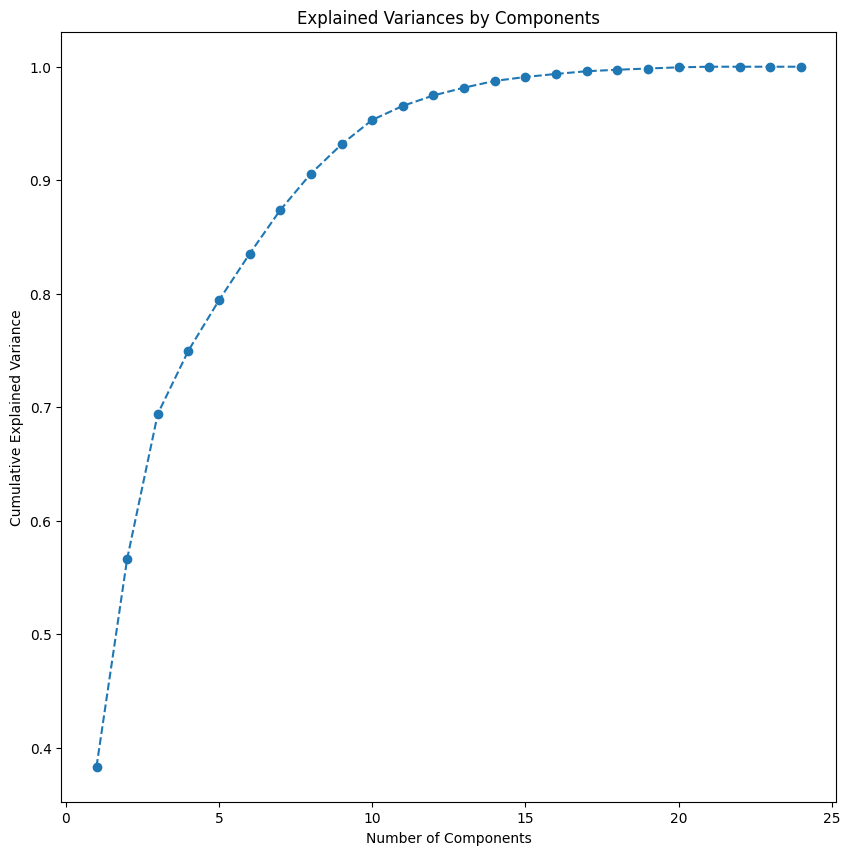

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

# visulaize the explained variance by individual components
plt.figure(figsize = (10,10))
plt.plot(range(1,n+1), pca1.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [195]:
# find the least number of components that can explain more than 80% variance
sum = 0
for ix, i in enumerate(exp_var1):
  sum = sum + i
  if(sum>0.80):
    print("Number of PCs that explain at least 80% variance: ", ix+1)
    break

Number of PCs that explain at least 80% variance:  6


In [196]:
# find the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(exp_var1):
  sum = sum + i
  if(sum>0.70):
    print("Number of PCs that explain at least 70% variance: ", ix+1)
    break

Number of PCs that explain at least 70% variance:  4


In [197]:
cols = ['PC1', 'PC2', 'PC3', 'PC4']

pc1 = pd.DataFrame(np.round(pca1.components_.T[:, 0:4],2), index=data_scaled.columns, columns=cols)

In [198]:
def color_high(val):
    if val <= -0.25: # you can decide any value as per your understanding
        return 'background: pink'
    elif val >= 0.25:
        return 'background: skyblue'   
    
pc1.style.applymap(color_high)

C:\Users\tutem\AppData\Local\Temp\ipykernel_30104\329474996.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pc1.style.applymap(color_high)


## Correlated Features

In [199]:
ABT.corr()

client_id  CreditCard_Premium  CreditCard_Active  \
client_id                  1.000000            0.044398          -0.148117   
CreditCard_Premium         0.044398            1.000000           0.254667   
CreditCard_Active         -0.148117            0.254667           1.000000   
Loan_Active                0.008420           -0.007414           0.038196   
Mortgage_Active           -0.125800           -0.015391          -0.052002   
...                             ...                 ...                ...   
Insurance_Mobile          -0.036124            0.079069           0.191357   
Insurance_ATM              0.013505           -0.047733          -0.019796   
Insurance_Unemployment     0.012061           -0.007771           0.013618   
TotalInsurances           -0.035528            0.031480           0.194221   
Porcent_Total_Insurances  -0.035528            0.031480           0.194221   

                          Loan_Active  Mortgage_Active  DebitCard_Active  \
client_id                    0.008420        -0.125800          0.149141   
CreditCard_Premium          -0.007414        -0.015391         -0.099862   
CreditCard_Active            0.038196        -0.052002         -0.285630   
Loan_Active                  1.000000        -0.037892          0.223872   
Mortgage_Active             -0.037892         1.000000          0.002179   
...                               ...              ...               ...   
Insurance_Mobile             0.067158        -0.021570         -0.058112   
Insurance_ATM                0.217906         0.045069          0.243219   
Insurance_Unemployment       0.708234        -0.035281          0.168320   
TotalInsurances              0.465033         0.016201          0.124437   
Porcent_Total_Insurances     0.465033         0.016201          0.124437   

                          Investment_Active       Sex  Client_Age_grp  \
client_id                         -0.035678 -0.058477       -0.302570   
CreditCard_Premium                -0.035889 -0.026809        0.020644   
CreditCard_Active                 -0.038765 -0.017215        0.172011   
Loan_Active                       -0.040017 -0.011554        0.063915   
Mortgage_Active                    0.019961  0.034384        0.002331   
...                                     ...       ...             ...   
Insurance_Mobile                  -0.019291  0.011712        0.132112   
Insurance_ATM                      0.037870  0.012652       -0.054322   
Insurance_Unemployment            -0.038151 -0.000777       -0.023123   
TotalInsurances                   -0.032341  0.032548        0.020222   
Porcent_Total_Insurances          -0.032341  0.032548        0.020222   

                            Mobile  ...  Porcent_Operations_HomeBanking  \
client_id                 0.038438  ...                        0.003432   
CreditCard_Premium        0.003805  ...                        0.033540   
CreditCard_Active         0.012443  ...                        0.111196   
Loan_Active               0.065383  ...                        0.005896   
Mortgage_Active          -0.029069  ...                        0.056854   
...                            ...  ...                             ...   
Insurance_Mobile          0.040485  ...                       -0.011414   
Insurance_ATM             0.058469  ...                        0.128352   
Insurance_Unemployment    0.051635  ...                        0.007100   
TotalInsurances           0.085595  ...                        0.088078   
Porcent_Total_Insurances  0.085595  ...                        0.088078   

                          Porcent_Operations_Mobile  Insurance_Life  \
client_id                                  0.086509       -0.006130   
CreditCard_Premium                         0.028793        0.029580   
CreditCard_Active                          0.078426        0.155410   
Loan_Active                                0.058987        0.270208   
Mortgage_Active                            

In [200]:
# if Inplace is False, return a copy, default drop(inplace=False)
corr_Matrix = ABT.drop(['client_id','TGT'], axis=1).corr().abs()
corr_Matrix

CreditCard_Premium  CreditCard_Active  Loan_Active  \
CreditCard_Premium                  1.000000           0.254667     0.007414   
CreditCard_Active                   0.254667           1.000000     0.038196   
Loan_Active                         0.007414           0.038196     1.000000   
Mortgage_Active                     0.015391           0.052002     0.037892   
DebitCard_Active                    0.099862           0.285630     0.223872   
...                                      ...                ...          ...   
Insurance_Mobile                    0.079069           0.191357     0.067158   
Insurance_ATM                       0.047733           0.019796     0.217906   
Insurance_Unemployment              0.007771           0.013618     0.708234   
TotalInsurances                     0.031480           0.194221     0.465033   
Porcent_Total_Insurances            0.031480           0.194221     0.465033   

                          Mortgage_Active  DebitCard_Active  \
CreditCard_Premium               0.015391          0.099862   
CreditCard_Active                0.052002          0.285630   
Loan_Active                      0.037892          0.223872   
Mortgage_Active                  1.000000          0.002179   
DebitCard_Active                 0.002179          1.000000   
...                                   ...               ...   
Insurance_Mobile                 0.021570          0.058112   
Insurance_ATM                    0.045069          0.243219   
Insurance_Unemployment           0.035281          0.168320   
TotalInsurances                  0.016201          0.124437   
Porcent_Total_Insurances         0.016201          0.124437   

                          Investment_Active       Sex  Client_Age_grp  \
CreditCard_Premium                 0.035889  0.026809        0.020644   
CreditCard_Active                  0.038765  0.017215        0.172011   
Loan_Active                        0.040017  0.011554        0.063915   
Mortgage_Active                    0.019961  0.034384        0.002331   
DebitCard_Active                   0.148153  0.022313        0.141464   
...                                     ...       ...             ...   
Insurance_Mobile                   0.019291  0.011712        0.132112   
Insurance_ATM                      0.037870  0.012652        0.054322   
Insurance_Unemployment             0.038151  0.000777        0.023123   
TotalInsurances                    0.032341  0.032548        0.020222   
Porcent_Total_Insurances           0.032341  0.032548        0.020222   

                            Mobile     Email  ...  \
CreditCard_Premium        0.003805  0.088081  ...   
CreditCard_Active         0.012443  0.089459  ...   
Loan_Active               0.065383  0.012032  ...   
Mortgage_Active           0.029069  0.007549  ...   
DebitCard_Active          0.118533  0.089266  ...   
...                            ...       ...  ...   
Insurance_Mobile          0.040485  0.019767  ...   
Insurance_ATM             0.058469  0.060119  ...   
Insurance_Unemployment    0.051635  0.012599  ...   
TotalInsurances           0.085595  0.060886  ...   
Porcent_Total_Insurances  0.085595  0.060886  ...   

                          Porcent_Operations_HomeBanking  \
CreditCard_Premium                              0.033540   
CreditCard_Active                               0.111196   
Loan_Active                                     0.005896   
Mortgage_Active                                 0.056854   
DebitCard_Active                                0.178398   
...                                                  ...   
Insurance_Mobile                                0.011414   
Insurance_ATM                                   0.128352   
Insurance_Unemployment                          0.007100   
TotalInsurances                                 0.088078   
Porcent_Total_Insurances                        0.088078   

                          Porcent_Operations_Mobile  Insurance_Life  \
Cr

<Axes: >

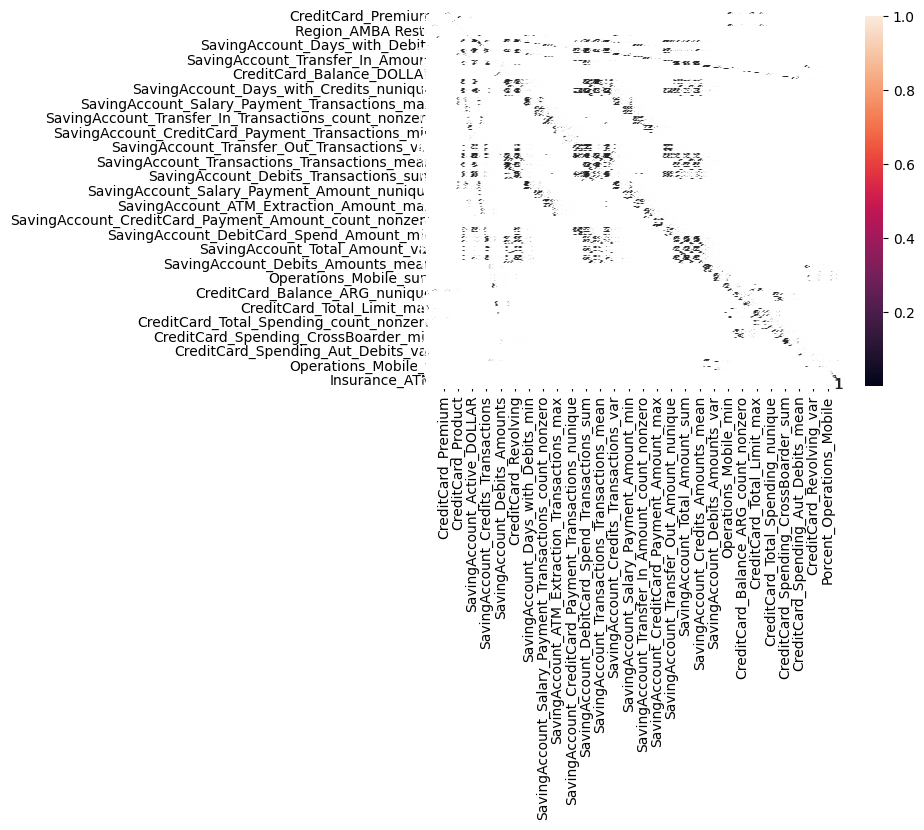

In [201]:
sns.heatmap(corr_Matrix, annot=True)

In [202]:
upper = corr_Matrix.where(np.triu(np.ones(corr_Matrix.shape),k=1).astype(bool)).fillna(0)

## features to drop, because correlation is up to 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
#len(to_drop)

to_drop

['CreditCard_Product',
 'SavingAccount_Active_ARG',
 'SavingAccount_Days_with_Debits',
 'SavingAccount_Transactions_Transactions',
 'SavingAccount_Credits_Transactions',
 'SavingAccount_Debits_Transactions',
 'SavingAccount_Salary_Payment_Amount',
 'SavingAccount_Transfer_In_Amount',
 'SavingAccount_ATM_Extraction_Amount',
 'SavingAccount_DebitCard_Spend_Amount',
 'SavingAccount_Credits_Amounts',
 'SavingAccount_Debits_Amounts',
 'CreditCard_Spending_1_Installment',
 'CreditCard_Spending_CrossBoarder',
 'SavingAccount_Days_with_Credits_sum',
 'SavingAccount_Days_with_Credits_max',
 'SavingAccount_Days_with_Credits_min',
 'SavingAccount_Days_with_Credits_mean',
 'SavingAccount_Days_with_Credits_nunique',
 'SavingAccount_Days_with_Debits_sum',
 'SavingAccount_Days_with_Debits_max',
 'SavingAccount_Days_with_Debits_min',
 'SavingAccount_Days_with_Debits_mean',
 'SavingAccount_Days_with_Debits_count_nonzero',
 'SavingAccount_Salary_Payment_Transactions_sum',
 'SavingAccount_Salary_Payment_

In [203]:
#drop features
ABT.drop(to_drop,axis=1, inplace=True)
ABT.shape

(23191, 87)

In [204]:
ABT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23191 entries, 0 to 23190
Data columns (total 87 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   client_id                                          23191 non-null  int32  
 1   CreditCard_Premium                                 23191 non-null  int32  
 2   CreditCard_Active                                  23191 non-null  int32  
 3   Loan_Active                                        23191 non-null  int32  
 4   Mortgage_Active                                    23191 non-null  int32  
 5   DebitCard_Active                                   23191 non-null  int32  
 6   Investment_Active                                  23191 non-null  int32  
 7   Sex                                                23191 non-null  int32  
 8   Client_Age_grp                                     23191 non-null  int64  
 9   Mobile

In [205]:
ABT

client_id  CreditCard_Premium  CreditCard_Active  Loan_Active  \
0        5928737                   0                  0            0   
1        6018047                   1                  1            0   
2        5359038                   1                  1            1   
3        6890812                   0                  0            1   
4         115383                   0                  0            0   
...          ...                 ...                ...          ...   
23186    6570413                   0                  1            0   
23187    6258895                   0                  0            0   
23188    6397274                   0                  1            0   
23189    6007291                   1                  1            0   
23190    6412619                   0                  0            1   

       Mortgage_Active  DebitCard_Active  Investment_Active  Sex  \
0                    0                 1                  0    1   
1                    0                 1                  0    1   
2                    0                 1                  0    1   
3                    0                 1                  0    1   
4                    0                 0                  0    1   
...                ...               ...                ...  ...   
23186                0                 1                  0    0   
23187                0                 1                  0    0   
23188                0                 0                  0    1   
23189                0                 0                  0    0   
23190                0                 1                  0    0   

       Client_Age_grp  Mobile  ...  Operations_Telemarketer  Operations_ATM  \
0                  30       1  ...                      0.0             0.0   
1                  60       1  ...                      0.0             0.0   
2                  40       1  ...                      0.0             7.0   
3                  40       1  ...                      1.0             0.0   
4                  70       0  ...                      0.0             0.0   
...               ...     ...  ...                      ...             ...   
23186              30       1  ...                      0.0             0.0   
23187              30       1  ...                      0.0             0.0   
23188              40       0  ...                      0.0             0.0   
23189              40       0  ...                      0.0             0.0   
23190              60       1  ...                      0.0             0.0   

       TotalOperations  Insurance_Life  Insurance_Home  Insurance_Accidents  \
0                  0.0               0               0                    0   
1                 11.0               0               0                    0   
2                 83.0               0               0                    0   
3                 73.0               1               0                    0   
4                  0.0               0               0                    0   
...                ...             ...             ...                  ...   
23186             10.0               0               0                    0   
23187              0.0               0               1                    0   
23188              0.0               1               0                    1   
23189              0.0               0               0                    0   
23190              6.0               1               1                    0   

       Insurance_Mobile  Insurance_ATM  Insurance_Unemployment  \
0                     0              0                       0   
1                     0              0                       0   
2                     0              0                       0   
3                     0              0                       1   
4                     0              0                       0   
...                 ...        

# Feature selection

In [206]:
names = [x for x in ABT.columns if (x != 'client_id') & (x != 'TGT') ]

scaler = StandardScaler(copy=True)
scaler.fit(ABT[names]) # Entrena
scaled_est = scaler.transform(ABT[names]) # Standariza el total de la base
scaled_est = pd.DataFrame(scaled_est, columns=names, index=ABT.index)

ABT.drop(names, axis=1, inplace = True)
ABT = pd.concat((ABT, scaled_est), axis=1, sort=False)

ABT.head(5)

client_id  TGT  CreditCard_Premium  CreditCard_Active  Loan_Active  \
0    5928737  0.0           -0.361090           -1.35619    -0.383097   
1    6018047  1.0            2.769392            0.73736    -0.383097   
2    5359038  1.0            2.769392            0.73736     2.610303   
3    6890812  0.0           -0.361090           -1.35619     2.610303   
4     115383  0.0           -0.361090           -1.35619    -0.383097   

   Mortgage_Active  DebitCard_Active  Investment_Active       Sex  \
0          -0.1513          0.702561          -0.240698  0.862295   
1          -0.1513          0.702561          -0.240698  0.862295   
2          -0.1513          0.702561          -0.240698  0.862295   
3          -0.1513          0.702561          -0.240698  0.862295   
4          -0.1513         -1.423364          -0.240698  0.862295   

   Client_Age_grp  ...  Operations_Telemarketer  Operations_ATM  \
0       -1.070796  ...                -0.431961       -0.251284   
1        1.159183  ...                -0.431961       -0.251284   
2       -0.327469  ...                -0.431961        1.489019   
3       -0.327469  ...                 0.312898       -0.251284   
4        1.902509  ...                -0.431961       -0.251284   

   TotalOperations  Insurance_Life  Insurance_Home  Insurance_Accidents  \
0        -0.639048       -0.489723       -0.412265             -0.43036   
1        -0.196695       -0.489723       -0.412265             -0.43036   
2         2.698708       -0.489723       -0.412265             -0.43036   
3         2.296569        2.041969       -0.412265             -0.43036   
4        -0.639048       -0.489723       -0.412265             -0.43036   

   Insurance_Mobile  Insurance_ATM  Insurance_Unemployment  TotalInsurances  
0         -0.287629      -0.410115               -0.290693        -0.675250  
1         -0.287629      -0.410115               -0.290693        -0.675250  
2         -0.287629      -0.410115               -0.290693        -0.675250  
3         -0.287629      -0.410115                3.440055         1.027172  
4         -0.287629      -0.410115               -0.290693        -0.675250  

[5 rows x 87 columns]

## searchCV

In [207]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


target_column = 'TGT'
numerical_cols = [x for x in ABT.columns if (x != 'client_id') & (x != 'TGT')]

estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

parameters = {
    'max_depth': np.arange(6, 10, 1),
    'learning_rate': np.arange(0.01, 1, 0.05),
    'gamma': np.arange(0.1, 2, 0.1),
    'alpha': np.arange(0,10,1),
    'lambda': np.arange(0,10,1),
    'subsample': np.arange(0.1, 1, 0.1),
    'n_estimators':  np.arange(15, 20, 1)
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 3,
    verbose=True
)

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

grid_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    n_iter= n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    verbose=True)

grid_search.fit(ABT[numerical_cols], ABT[target_column])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'lambda': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'max_depth': array([6, 7, 8, 9]),
                                        'n_estimators': array([15, 16, 17, 18, 19]),
                                        'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='roc_auc', verbose=True)

## importance feature

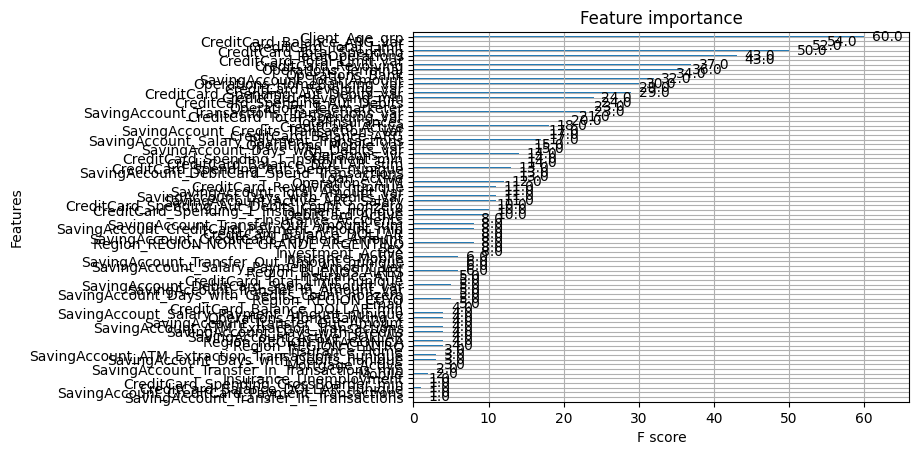

In [208]:
from xgboost import plot_importance
plot_importance(grid_search.best_estimator_)
plt.show()

<Axes: >

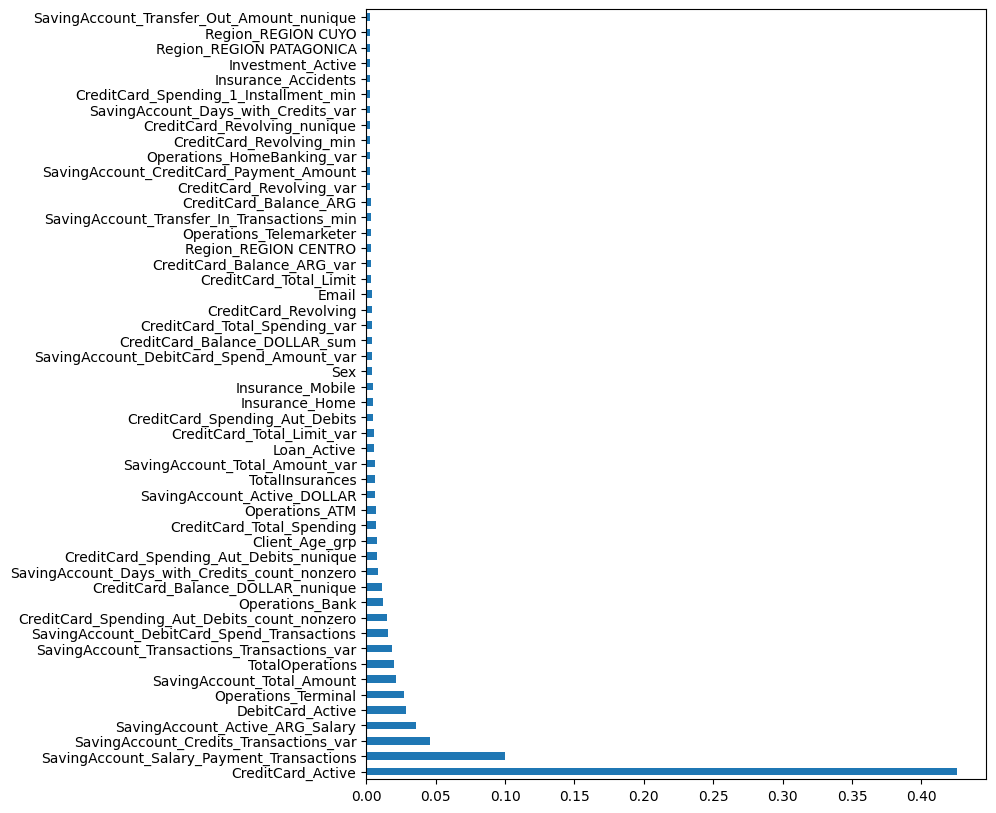

In [209]:
#grid_search.best_estimator_.feature_importances_
feat_imp = pd.Series(grid_search.best_estimator_.feature_importances_, index=ABT[numerical_cols].columns)
feat_imp.nlargest(50).plot(kind='barh', figsize=(8,10))

In [210]:
a = pd.DataFrame(feat_imp.nlargest(50))
a

0
CreditCard_Active                              0.425357
SavingAccount_Salary_Payment_Transactions      0.099960
SavingAccount_Credits_Transactions_var         0.045885
SavingAccount_Active_ARG_Salary                0.036049
DebitCard_Active                               0.028939
Operations_Terminal                            0.026871
SavingAccount_Total_Amount                     0.021772
TotalOperations                                0.020230
SavingAccount_Transactions_Transactions_var    0.018787
SavingAccount_DebitCard_Spend_Transactions     0.015601
CreditCard_Spending_Aut_Debits_count_nonzero   0.015040
Operations_Bank                                0.011762
CreditCard_Balance_DOLLAR_nunique              0.011465
SavingAccount_Days_with_Credits_count_nonzero  0.008424
CreditCard_Spending_Aut_Debits_nunique         0.008108
Client_Age_grp                                 0.007616
CreditCard_Total_Spending                      0.007233
Operations_ATM                                 0.006828
SavingAccount_Active_DOLLAR                    0.006652
TotalInsurances                                0.006639
SavingAccount_Total_Amount_var                 0.005980
Loan_Active                                    0.005865
CreditCard_Total_Limit_var                     0.005278
CreditCard_Spending_Aut_Debits                 0.005020
Insurance_Home                                 0.004995
Insurance_Mobile                               0.004971
Sex                                            0.004379
SavingAccount_DebitCard_Spend_Amount_var       0.004125
CreditCard_Balance_DOLLAR_sum                  0.003999
CreditCard_Total_Spending_var                  0.003977
CreditCard_Revolving                           0.003972
Email                                          0.003905
CreditCard_Total_Limit                         0.003788
CreditCard_Balance_ARG_var                     0.003671
Region_REGION CENTRO                           0.003612
Operations_Telemarketer                        0.003527
SavingAccount_Transfer_In_Transactions_min     0.003222
CreditCard_Balance_ARG                         0.003135
CreditCard_Revolving_var                       0.003038
SavingAccount_CreditCard_Payment_Amount        0.003027
Operations_HomeBanking_var                     0.003020
CreditCard_Revolving_min                       0.002877
CreditCard_Revolving_nunique                   0.002866
SavingAccount_Days_with_Credits_var            0.002843
CreditCard_Spending_1_Installment_min          0.002832
Insurance_Accidents                            0.002826
Investment_Active                              0.002787
Region_REGION PATAGONICA                       0.002747
Region_REGION CUYO                             0.002732
SavingAccount_Transfer_Out_Amount_nunique      0.002716

In [211]:
a.to_csv(r'result/top_50_Features.csv', sep='|')

In [212]:
a = pd.read_csv(r'result/top_50_Features.csv', sep='|')

a.columns = ['column', 'order']
a

column     order
0                               CreditCard_Active  0.425357
1       SavingAccount_Salary_Payment_Transactions  0.099960
2          SavingAccount_Credits_Transactions_var  0.045885
3                 SavingAccount_Active_ARG_Salary  0.036049
4                                DebitCard_Active  0.028939
5                             Operations_Terminal  0.026871
6                      SavingAccount_Total_Amount  0.021772
7                                 TotalOperations  0.020230
8     SavingAccount_Transactions_Transactions_var  0.018787
9      SavingAccount_DebitCard_Spend_Transactions  0.015601
10   CreditCard_Spending_Aut_Debits_count_nonzero  0.015040
11                                Operations_Bank  0.011762
12              CreditCard_Balance_DOLLAR_nunique  0.011465
13  SavingAccount_Days_with_Credits_count_nonzero  0.008424
14         CreditCard_Spending_Aut_Debits_nunique  0.008108
15                                 Client_Age_grp  0.007616
16                      CreditCard_Total_Spending  0.007233
17                                 Operations_ATM  0.006828
18                    SavingAccount_Active_DOLLAR  0.006652
19                                TotalInsurances  0.006639
20                 SavingAccount_Total_Amount_var  0.005980
21                                    Loan_Active  0.005865
22                     CreditCard_Total_Limit_var  0.005278
23                 CreditCard_Spending_Aut_Debits  0.005020
24                                 Insurance_Home  0.004995
25                               Insurance_Mobile  0.004971
26                                            Sex  0.004379
27       SavingAccount_DebitCard_Spend_Amount_var  0.004125
28                  CreditCard_Balance_DOLLAR_sum  0.003999
29                  CreditCard_Total_Spending_var  0.003977
30                           CreditCard_Revolving  0.003972
31                                          Email  0.003905
32                         CreditCard_Total_Limit  0.003788
33                     CreditCard_Balance_ARG_var  0.003671
34                           Region_REGION CENTRO  0.003612
35                        Operations_Telemarketer  0.003527
36     SavingAccount_Transfer_In_Transactions_min  0.003222
37                         CreditCard_Balance_ARG  0.003135
38                       CreditCard_Revolving_var  0.003038
39        SavingAccount_CreditCard_Payment_Amount  0.003027
40                     Operations_HomeBanking_var  0.003020
41                       CreditCard_Revolving_min  0.002877
42                   CreditCard_Revolving_nunique  0.002866
43            SavingAccount_Days_with_Credits_var  0.002843
44          CreditCard_Spending_1_Installment_min  0.002832
45                            Insurance_Accidents  0.002826
46                              Investment_Active  0.002787
47                       Region_REGION PATAGONICA  0.002747
48                             Region_REGION CUYO  0.002732
49      SavingAccount_Transfer_Out_Amount_nunique  0.002716

## Select the main features

In [213]:
selected_features = list(a['column'][:50])
selected_features += ['client_id', 'TGT']

In [214]:
selected_features

['CreditCard_Active',
 'SavingAccount_Salary_Payment_Transactions',
 'SavingAccount_Credits_Transactions_var',
 'SavingAccount_Active_ARG_Salary',
 'DebitCard_Active',
 'Operations_Terminal',
 'SavingAccount_Total_Amount',
 'TotalOperations',
 'SavingAccount_Transactions_Transactions_var',
 'SavingAccount_DebitCard_Spend_Transactions',
 'CreditCard_Spending_Aut_Debits_count_nonzero',
 'Operations_Bank',
 'CreditCard_Balance_DOLLAR_nunique',
 'SavingAccount_Days_with_Credits_count_nonzero',
 'CreditCard_Spending_Aut_Debits_nunique',
 'Client_Age_grp',
 'CreditCard_Total_Spending',
 'Operations_ATM',
 'SavingAccount_Active_DOLLAR',
 'TotalInsurances',
 'SavingAccount_Total_Amount_var',
 'Loan_Active',
 'CreditCard_Total_Limit_var',
 'CreditCard_Spending_Aut_Debits',
 'Insurance_Home',
 'Insurance_Mobile',
 'Sex',
 'SavingAccount_DebitCard_Spend_Amount_var',
 'CreditCard_Balance_DOLLAR_sum',
 'CreditCard_Total_Spending_var',
 'CreditCard_Revolving',
 'Email',
 'CreditCard_Total_Limit',
 '

In [215]:
ABT_Model_Select = ABT[selected_features].copy()

# Split in Train and Test

In [216]:
ABT_Model_Select.shape

(23191, 52)

In [217]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(ABT_Model_Select, test_size=0.3, random_state=42, stratify=ABT_Model_Select['TGT']);  

In [218]:
X_train.TGT.value_counts()

TGT
0.0    11457
1.0     4776
Name: count, dtype: int64

In [219]:
X_test.TGT.value_counts()

TGT
0.0    4911
1.0    2047
Name: count, dtype: int64

In [220]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

target_column = 'TGT'
numerical_cols = [x for x in ABT_Model_Select.columns if (x != 'client_id') & (x != 'TGT')]

estimator = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

parameters = {
    'max_depth': np.arange(6, 10, 1),
    'learning_rate': np.arange(0.01, 1, 0.05),
    'gamma': np.arange(0.1, 2, 0.1),
    'alpha': np.arange(0,10,1),
    'lambda': np.arange(0,10,1),
    'subsample': np.arange(0.1, 1, 0.1),
    'n_estimators': np.arange(15, 20, 1)
}

cross_val = StratifiedKFold(n_splits=3) 

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = cross_val,
    verbose=True
)

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

grid_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    n_iter= n_HP_points_to_test,
    scoring='roc_auc',
    cv= cross_val,
    refit= True,
    verbose= True)

grid_search.fit(X_train[numerical_cols], X_train[target_column])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                        'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'lambda': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'learning_rate': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
                                        'max_depth': array([6, 7, 8, 9]),
                                        'n_estimators': array([15, 16, 17, 18, 19]),
                                        'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='roc_auc', verbose=True)

In [221]:
best_parameters = grid_search.best_estimator_

In [222]:
best_parameters.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': None,
 'gamma': 1.1,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.26,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 42,
 'lambda': 4,
 'alpha': 6}

# Modelling

In [223]:
#create model
model = XGBClassifier(objective='binary:logistic',
                      booster='gbtree',
                      seed=42,
                      gamma=0.6,
                      learning_rate=0.16,
                      max_depth=6,
                      subsample=0.8,
                      n_estimators=19,
                     alpha=3,
                     reg_lambda=6,
                     )

# Train

In [224]:
# fit model
model.fit(X_train[numerical_cols], X_train[target_column])

XGBClassifier(alpha=3, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=19, n_jobs=None,
              num_parallel_tree=None, ...)

In [225]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(X_train[target_column], model.predict(X_train[numerical_cols])) * 100
print("Accuracy of Model: ",accuracy)
print(classification_report(X_train[target_column], model.predict(X_train[numerical_cols])))
pd.crosstab(X_train[target_column], model.predict(X_train[numerical_cols]))

Accuracy of Model:  80.92157949855233
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87     11457
         1.0       0.72      0.57      0.64      4776

    accuracy                           0.81     16233
   macro avg       0.78      0.74      0.75     16233
weighted avg       0.80      0.81      0.80     16233



col_0      0     1
TGT               
0.0    10425  1032
1.0     2065  2711

# Test

In [226]:
y_pred = model.predict(X_test[numerical_cols])

In [227]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(X_test[target_column], y_pred) * 100
print("Accuracy of Model: ",accuracy)
print(classification_report(X_test[target_column], y_pred))
pd.crosstab(X_test[target_column], y_pred)

Accuracy of Model:  78.52831273354413
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.85      4911
         1.0       0.68      0.52      0.59      2047

    accuracy                           0.79      6958
   macro avg       0.75      0.71      0.72      6958
weighted avg       0.78      0.79      0.78      6958



col_0     0     1
TGT              
0.0    4398   513
1.0     981  1066

## Deciles

In [228]:
# results..
from sklearn.metrics import mean_squared_error

probabilities_train = model.predict_proba(X_train[numerical_cols])
probabilities       = model.predict_proba(X_test[numerical_cols])

y_pred = model.predict(X_test[numerical_cols])

In [229]:
a = pd.DataFrame(X_train[['client_id', target_column]], columns=['TGT', 'idx'])
a = a.reset_index()
b = pd.DataFrame(probabilities_train[:,1], columns=['Prob1'])

result = pd.concat([a, b], axis=1)

result['porc'] = result['Prob1'].rank(pct=True) * 100

len(probabilities[:,1])

result.loc[result['porc'].between(0, 10, inclusive='neither'), 'decil'] = '10'
result.loc[result['porc'].between(10, 20, inclusive='both'), 'decil'] = '9'
result.loc[result['porc'].between(20, 30, inclusive='neither'), 'decil'] = '8'
result.loc[result['porc'].between(30, 40, inclusive='both'), 'decil'] = '7'
result.loc[result['porc'].between(40, 50, inclusive='neither'), 'decil'] = '6'
result.loc[result['porc'].between(50, 60, inclusive='both'), 'decil'] = '5'
result.loc[result['porc'].between(60, 70, inclusive='neither'), 'decil'] = '4'
result.loc[result['porc'].between(70, 80, inclusive='both'), 'decil'] = '3'
result.loc[result['porc'].between(80, 90, inclusive='neither'), 'decil'] = '2'
result.loc[result['porc'].between(90, 101, inclusive='both'), 'decil'] = '1'

print(result.decil.value_counts())
print(result[result.TGT == 1].decil.value_counts())

a = result.groupby('decil')['Prob1'].agg('min')
print(a)

decil
10    1925
7     1624
1     1624
4     1624
3     1623
6     1623
2     1623
5     1623
8     1603
9     1341
Name: count, dtype: int64
decil
1     1342
2     1109
3      784
4      603
5      449
6      263
7      154
8       53
9       16
10       3
Name: count, dtype: int64
decil
1     0.656633
10    0.023239
2     0.533970
3     0.425462
4     0.334067
5     0.257888
6     0.183655
7     0.091814
8     0.039546
9     0.024741
Name: Prob1, dtype: float32


In [230]:
##############################################
# test 

a = pd.DataFrame(X_test[[target_column, 'client_id']], columns=['TGT', 'idx'])
a = a.reset_index()
b = pd.DataFrame(probabilities[:,1], columns=['Prob1'])

result = pd.concat([a, b], axis=1)

result['porc'] = result['Prob1'].rank(pct=True) * 100

result['decil'] = np.where(result.Prob1 >= 0.636058               , 1, 
                            np.where((result.Prob1 >=  0.495332            ) & (result.Prob1 <  0.636058       ), 2,
                            np.where((result.Prob1 >=  0.390821               ) & (result.Prob1 < 0.495332                   ) , 3,
                            np.where((result.Prob1 >=  0.314308                ) & (result.Prob1 < 0.390821                 ), 4,
                            np.where((result.Prob1 >=  0.232692                 ) & (result.Prob1 < 0.314308               ), 5,
                            np.where((result.Prob1 >=  0.154669                ) & (result.Prob1 < 0.232692              ), 6,
                            np.where((result.Prob1 >=  0.035695                 ) & (result.Prob1 < 0.154669               ) , 7,
                            np.where((result.Prob1 >=  0.025761               ) & (result.Prob1 < 0.035695              ), 8,
                            np.where((result.Prob1 >=  0.025717                 ) & (result.Prob1 < 0.025761                    ), 9,
                            10)))))))))
print(result.decil.value_counts())
print(result[result.TGT == 1].decil.value_counts())

decil
7     1440
10     928
2      823
1      783
5      762
3      735
6      730
4      556
8      201
Name: count, dtype: int64
decil
1     593
2     487
3     356
5     212
4     195
6     124
7      75
8       3
10      2
Name: count, dtype: int64


# Performance

In [231]:
y_test = X_test['TGT']
y_pred = model.predict(X_test[numerical_cols])

In [232]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

print(cm)

[[4398  513]
 [ 981 1066]]


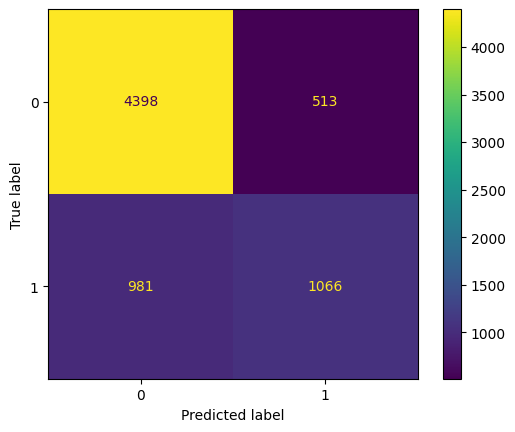

In [233]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

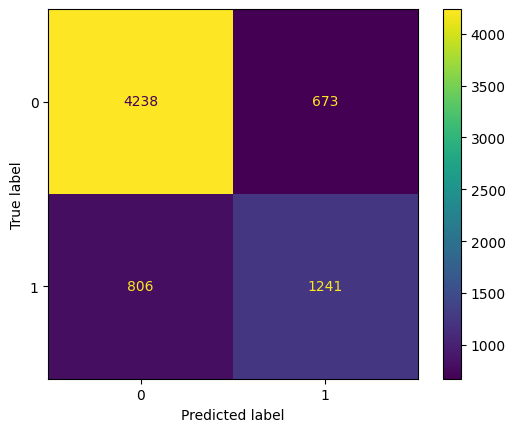

In [234]:
threshold = 0.45
y_pred = (model.predict_proba(X_test[numerical_cols])[:, 1] > threshold).astype('float')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

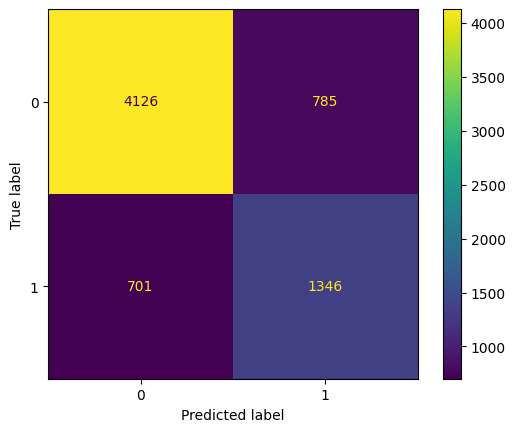

In [235]:
threshold = 0.42
y_pred = (model.predict_proba(X_test[numerical_cols])[:, 1] > threshold).astype('float')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

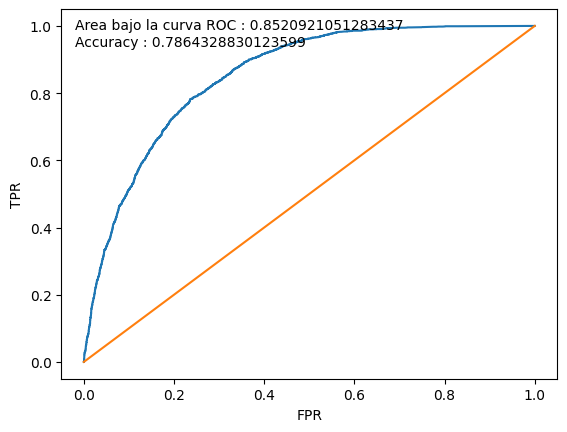

In [236]:
# ROC

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

yPred = y_pred
yScore = result['Prob1']
yTest = result['TGT']
areaBajoCurvaRoc = roc_auc_score(yTest, yScore)
accuracy = accuracy_score(yTest, yPred)
fpr, tpr, _ = roc_curve(yTest, yScore)
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC : {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.annotate('Accuracy : {}'.format(accuracy), (-0.02,0.94))
plt.show()
display()

In [237]:
pVar = 'Prob1'
result['porc'] = result[pVar].rank(pct=True) * 100

len(probabilities[:,1])

result.loc[result['porc'].between(0, 10, inclusive='neither'), 'decil'] = '10'
result.loc[result['porc'].between(10, 20, inclusive='both'), 'decil'] = '9'
result.loc[result['porc'].between(20, 30, inclusive='neither'), 'decil'] = '8'
result.loc[result['porc'].between(30, 40, inclusive='both'), 'decil'] = '7'
result.loc[result['porc'].between(40, 50, inclusive='neither'), 'decil'] = '6'
result.loc[result['porc'].between(50, 60, inclusive='both'), 'decil'] = '5'
result.loc[result['porc'].between(60, 70, inclusive='neither'), 'decil'] = '4'
result.loc[result['porc'].between(70, 80, inclusive='both'), 'decil'] = '3'
result.loc[result['porc'].between(80, 90, inclusive='neither'), 'decil'] = '2'
result.loc[result['porc'].between(90, 101, inclusive='both'), 'decil'] = '1'

a = pd.DataFrame(result.decil.value_counts().reset_index())
a.columns = ['index','decil']

b = pd.DataFrame(result[result.TGT == 1].decil.value_counts().reset_index())

b.columns = ['index','decil']

C:\Users\tutem\AppData\Local\Temp\ipykernel_30104\557752367.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  result.loc[result['porc'].between(0, 10, inclusive='neither'), 'decil'] = '10'


In [238]:
b

index  decil
0     1    530
1     2    444
2     3    353
3     4    277
4     5    193
5     6    138
6     7     78
7     8     25
8     9      7
9    10      2

In [239]:
c = a.merge(b, how='left', on='index')
c['TGT_%'] = (c['decil_y'] /c['decil_x'])*100
c

index  decil_x  decil_y      TGT_%
0    10      837        2   0.238949
1     8      696       25   3.591954
2     3      696      353  50.718391
3     1      696      530  76.149425
4     2      696      444  63.793103
5     5      696      193  27.729885
6     7      696       78  11.206897
7     4      696      277  39.798851
8     6      695      138  19.856115
9     9      554        7   1.263538